# Sciplex Dose

In [1]:
ood_seed = 9

In [2]:
num_ood = 1

In [3]:
import warnings
import os
import sys
import gc
import warnings

In [4]:
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import sklearn
import scipy.stats
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "cpa_GSM_new.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)

adata.X = adata.layers["counts"].copy()
del adata.layers
adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
gc.collect()

12

In [7]:
df = adata.obs.groupby(["condition", "dose"]).size()
df2 = adata.obs.groupby(["condition"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
df

condition  dose 
BMS        0.0         0
           0.1       654
           0.5       542
           1.0       344
           5.0       193
           10.0      153
           50.0       34
           100.0      19
Dex        0.0         0
           0.1       327
           0.5       372
           1.0       717
           5.0       694
           10.0      704
           50.0      864
           100.0     790
Nutlin     0.0         0
           0.1       419
           0.5       359
           1.0       567
           5.0       486
           10.0      657
           50.0      265
           100.0       7
SAHA       0.0         0
           0.1       561
           0.5       519
           1.0       543
           5.0       417
           10.0      426
           50.0      604
           100.0     419
Vehicle    0.0      2155
           0.1         0
           0.5         0
           1.0         0
           5.0         0
           10.0        0
           50.0        0
        

In [8]:
availables, len(availables)

([(('BMS', '5.0'), 193),
  (('BMS', '10.0'), 153),
  (('BMS', '50.0'), 34),
  (('Dex', '5.0'), 694),
  (('Dex', '10.0'), 704),
  (('Dex', '50.0'), 864),
  (('Dex', '100.0'), 790),
  (('Nutlin', '5.0'), 486),
  (('Nutlin', '10.0'), 657),
  (('Nutlin', '50.0'), 265),
  (('SAHA', '5.0'), 417),
  (('SAHA', '10.0'), 426),
  (('SAHA', '50.0'), 604),
  (('SAHA', '100.0'), 419)],
 14)

In [9]:
def adata_ood_creator(adata, seed, size):
    df = adata.obs.groupby(["condition", "dose"]).size()
    df2 = adata.obs.groupby(["condition"]).size()
    # availables = [(i, df[i]) for i in df.index if df[i] > 200 and df2[i[0]] > 100 and float(i[1])>4]
    # rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

(('Nutlin', '50.0'), 265)

Removed datapoint: 265


In [10]:
adata

AnnData object with n_obs × n_vars = 14546 × 4999
    obs: 'sample', 'size_factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'drug', 'dose', 'vehicle', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'product_dose', 'louvain', 'dose_val', 'cell_type', 'drug_dose_name', 'cov_drug_dose_name', 'condition', 'control', 'split', 'dose_training'
    var: 'id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dose_colors', 'drug_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'product_dose_colors', 'rank_genes_groups_cov', 'umap', 'vehicle_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [11]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"sciplex_cat_ood-seed-{ood_seed}_size-{num_ood}"
)

In [12]:
# vae = tardis.MyModel.load(dir_path, adata=adata)

In [13]:
model_level_metrics = [
    dict(
        metric_identifier = "metric_mi|dose_training",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    ),
    dict(
        metric_identifier = "metric_mi|condition",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    )
]

In [14]:
warmup_epoch_range = [6, 48]
dtc_w1 = 100
dtc_w2 = 10

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = "dose_training",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
    dict(
        obs_key = "condition",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]

In [15]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)),
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.5,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
    encode_covariates=False
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=64,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=5e-5,
        weight_decay=1e-2,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
    model_level_metrics=model_level_metrics,
    model_level_metrics_helper_covariates=['condition', 'dose_training']
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

tardis.MyModel.setup_wandb(
    wandb_configurations=tardis.config.wandb,
    hyperparams=dict(
        model_params=model_params,
        train_params=train_params,
        dataset_params=dataset_params,
    )
)

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

W&B logger initialized with the following parameters: 
Entity: inecik-academic
Project: tardis_conference
ID: wyc42zo3
Name: old-cantina-269
Tags: tardis, conference, figures, final
Notes: Final runs for Tardis before conference.
URL: https://wandb.ai/inecik-academic/tardis_conference/runs/wyc42zo3
Directory: /lustre/groups/ml01/workspace/kemal.inecik/wandb/run-20240505_004932-wyc42zo3/files



/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `dose_training` for `training` set. Number of elements in each group: 1726,1550,1431,1738,1424,1545,1229,994
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `condition` for `training` set. Number of elements in each group: 1552,3583,2023,2753,1726
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `dose_training` for `validation` set. Number of elements in each group: 429,411,361,433,366,395,273,241
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `condition` for `validation` set. Number of elements in each group: 387,885,472,736,429
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:12<2:07:15, 12.75s/it]

Epoch 1/600:   0%|          | 1/600 [00:12<2:07:15, 12.75s/it, v_num=o3_1, total_loss_train=2.66e+3, kl_local_train=31.7]

Epoch 2/600:   0%|          | 1/600 [00:12<2:07:15, 12.75s/it, v_num=o3_1, total_loss_train=2.66e+3, kl_local_train=31.7]

Epoch 2/600:   0%|          | 2/600 [00:24<2:03:05, 12.35s/it, v_num=o3_1, total_loss_train=2.66e+3, kl_local_train=31.7]

Epoch 2/600:   0%|          | 2/600 [00:24<2:03:05, 12.35s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=56.5]

Epoch 3/600:   0%|          | 2/600 [00:24<2:03:05, 12.35s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=56.5]

Epoch 3/600:   0%|          | 3/600 [00:36<2:01:31, 12.21s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=56.5]

Epoch 3/600:   0%|          | 3/600 [00:36<2:01:31, 12.21s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=61.7] 

Epoch 4/600:   0%|          | 3/600 [00:36<2:01:31, 12.21s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=61.7]

Epoch 4/600:   1%|          | 4/600 [00:48<2:00:34, 12.14s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=61.7]

Epoch 4/600:   1%|          | 4/600 [00:48<2:00:34, 12.14s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=63.2]

Epoch 5/600:   1%|          | 4/600 [00:48<2:00:34, 12.14s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=63.2]

Epoch 5/600:   1%|          | 5/600 [01:01<2:01:33, 12.26s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=63.2]

Epoch 5/600:   1%|          | 5/600 [01:01<2:01:33, 12.26s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=62.5]

Epoch 6/600:   1%|          | 5/600 [01:01<2:01:33, 12.26s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=62.5]

Epoch 6/600:   1%|          | 6/600 [01:12<1:59:08, 12.03s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=62.5]

Epoch 6/600:   1%|          | 6/600 [01:12<1:59:08, 12.03s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.0388, metric_mi|condition_train=0.0293]

Epoch 7/600:   1%|          | 6/600 [01:12<1:59:08, 12.03s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.0388, metric_mi|condition_train=0.0293]

Epoch 7/600:   1%|          | 7/600 [01:24<1:55:58, 11.73s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.0388, metric_mi|condition_train=0.0293]

Epoch 7/600:   1%|          | 7/600 [01:24<1:55:58, 11.73s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=56, metric_mi|dose_training_train=0.0388, metric_mi|condition_train=0.0293]  

Epoch 8/600:   1%|          | 7/600 [01:24<1:55:58, 11.73s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=56, metric_mi|dose_training_train=0.0388, metric_mi|condition_train=0.0293]

Epoch 8/600:   1%|▏         | 8/600 [01:35<1:53:34, 11.51s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=56, metric_mi|dose_training_train=0.0388, metric_mi|condition_train=0.0293]

Epoch 8/600:   1%|▏         | 8/600 [01:35<1:53:34, 11.51s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0388, metric_mi|condition_train=0.0293]

Epoch 9/600:   1%|▏         | 8/600 [01:35<1:53:34, 11.51s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0388, metric_mi|condition_train=0.0293]

Epoch 9/600:   2%|▏         | 9/600 [01:46<1:51:53, 11.36s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.0388, metric_mi|condition_train=0.0293]

Epoch 9/600:   2%|▏         | 9/600 [01:46<1:51:53, 11.36s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0388, metric_mi|condition_train=0.0293]

Epoch 10/600:   2%|▏         | 9/600 [01:46<1:51:53, 11.36s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0388, metric_mi|condition_train=0.0293]

Epoch 10/600:   2%|▏         | 10/600 [01:57<1:51:50, 11.37s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=36.7, metric_mi|dose_training_train=0.0388, metric_mi|condition_train=0.0293]

Epoch 10/600:   2%|▏         | 10/600 [01:57<1:51:50, 11.37s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0388, metric_mi|condition_train=0.0293]

Epoch 11/600:   2%|▏         | 10/600 [01:58<1:51:50, 11.37s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0388, metric_mi|condition_train=0.0293]

Epoch 11/600:   2%|▏         | 11/600 [02:09<1:52:08, 11.42s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0388, metric_mi|condition_train=0.0293]

Epoch 11/600:   2%|▏         | 11/600 [02:09<1:52:08, 11.42s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0485, metric_mi|condition_train=0.097] 

Epoch 12/600:   2%|▏         | 11/600 [02:09<1:52:08, 11.42s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0485, metric_mi|condition_train=0.097]

Epoch 12/600:   2%|▏         | 12/600 [02:20<1:50:40, 11.29s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0485, metric_mi|condition_train=0.097]

Epoch 12/600:   2%|▏         | 12/600 [02:20<1:50:40, 11.29s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=42.3, metric_mi|dose_training_train=0.0485, metric_mi|condition_train=0.097]

Epoch 13/600:   2%|▏         | 12/600 [02:20<1:50:40, 11.29s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=42.3, metric_mi|dose_training_train=0.0485, metric_mi|condition_train=0.097]

Epoch 13/600:   2%|▏         | 13/600 [02:31<1:49:40, 11.21s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=42.3, metric_mi|dose_training_train=0.0485, metric_mi|condition_train=0.097]

Epoch 13/600:   2%|▏         | 13/600 [02:31<1:49:40, 11.21s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0485, metric_mi|condition_train=0.097]

Epoch 14/600:   2%|▏         | 13/600 [02:31<1:49:40, 11.21s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0485, metric_mi|condition_train=0.097]

Epoch 14/600:   2%|▏         | 14/600 [02:42<1:48:53, 11.15s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.0485, metric_mi|condition_train=0.097]

Epoch 14/600:   2%|▏         | 14/600 [02:42<1:48:53, 11.15s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49, metric_mi|dose_training_train=0.0485, metric_mi|condition_train=0.097]  

Epoch 15/600:   2%|▏         | 14/600 [02:42<1:48:53, 11.15s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49, metric_mi|dose_training_train=0.0485, metric_mi|condition_train=0.097]

Epoch 15/600:   2%|▎         | 15/600 [02:53<1:49:39, 11.25s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49, metric_mi|dose_training_train=0.0485, metric_mi|condition_train=0.097]

Epoch 15/600:   2%|▎         | 15/600 [02:53<1:49:39, 11.25s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0485, metric_mi|condition_train=0.097]

Epoch 16/600:   2%|▎         | 15/600 [02:54<1:49:39, 11.25s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0485, metric_mi|condition_train=0.097]

Epoch 16/600:   3%|▎         | 16/600 [03:05<1:50:17, 11.33s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=52.5, metric_mi|dose_training_train=0.0485, metric_mi|condition_train=0.097]

Epoch 16/600:   3%|▎         | 16/600 [03:05<1:50:17, 11.33s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0586, metric_mi|condition_train=0.129]

Epoch 17/600:   3%|▎         | 16/600 [03:05<1:50:17, 11.33s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0586, metric_mi|condition_train=0.129]

Epoch 17/600:   3%|▎         | 17/600 [03:16<1:49:18, 11.25s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=54.5, metric_mi|dose_training_train=0.0586, metric_mi|condition_train=0.129]

Epoch 17/600:   3%|▎         | 17/600 [03:16<1:49:18, 11.25s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0586, metric_mi|condition_train=0.129]

Epoch 18/600:   3%|▎         | 17/600 [03:16<1:49:18, 11.25s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0586, metric_mi|condition_train=0.129]

Epoch 18/600:   3%|▎         | 18/600 [03:27<1:48:33, 11.19s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55.9, metric_mi|dose_training_train=0.0586, metric_mi|condition_train=0.129]

Epoch 18/600:   3%|▎         | 18/600 [03:27<1:48:33, 11.19s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.0586, metric_mi|condition_train=0.129]

Epoch 19/600:   3%|▎         | 18/600 [03:27<1:48:33, 11.19s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.0586, metric_mi|condition_train=0.129]

Epoch 19/600:   3%|▎         | 19/600 [03:38<1:47:54, 11.14s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.0586, metric_mi|condition_train=0.129]

Epoch 19/600:   3%|▎         | 19/600 [03:38<1:47:54, 11.14s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=59.5, metric_mi|dose_training_train=0.0586, metric_mi|condition_train=0.129]

Epoch 20/600:   3%|▎         | 19/600 [03:38<1:47:54, 11.14s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=59.5, metric_mi|dose_training_train=0.0586, metric_mi|condition_train=0.129]

Epoch 20/600:   3%|▎         | 20/600 [03:50<1:50:27, 11.43s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=59.5, metric_mi|dose_training_train=0.0586, metric_mi|condition_train=0.129]

Epoch 20/600:   3%|▎         | 20/600 [03:50<1:50:27, 11.43s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.0586, metric_mi|condition_train=0.129]

Epoch 21/600:   3%|▎         | 20/600 [03:50<1:50:27, 11.43s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.0586, metric_mi|condition_train=0.129]

Epoch 21/600:   4%|▎         | 21/600 [04:01<1:50:37, 11.46s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=65.3, metric_mi|dose_training_train=0.0586, metric_mi|condition_train=0.129]

Epoch 21/600:   4%|▎         | 21/600 [04:01<1:50:37, 11.46s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=66.5, metric_mi|dose_training_train=0.0596, metric_mi|condition_train=0.126]

Epoch 22/600:   4%|▎         | 21/600 [04:01<1:50:37, 11.46s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=66.5, metric_mi|dose_training_train=0.0596, metric_mi|condition_train=0.126]

Epoch 22/600:   4%|▎         | 22/600 [04:13<1:50:02, 11.42s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=66.5, metric_mi|dose_training_train=0.0596, metric_mi|condition_train=0.126]

Epoch 22/600:   4%|▎         | 22/600 [04:13<1:50:02, 11.42s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.0596, metric_mi|condition_train=0.126]

Epoch 23/600:   4%|▎         | 22/600 [04:13<1:50:02, 11.42s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.0596, metric_mi|condition_train=0.126]

Epoch 23/600:   4%|▍         | 23/600 [04:24<1:49:26, 11.38s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=67.7, metric_mi|dose_training_train=0.0596, metric_mi|condition_train=0.126]

Epoch 23/600:   4%|▍         | 23/600 [04:24<1:49:26, 11.38s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=68, metric_mi|dose_training_train=0.0596, metric_mi|condition_train=0.126]  

Epoch 24/600:   4%|▍         | 23/600 [04:24<1:49:26, 11.38s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=68, metric_mi|dose_training_train=0.0596, metric_mi|condition_train=0.126]

Epoch 24/600:   4%|▍         | 24/600 [04:35<1:48:17, 11.28s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=68, metric_mi|dose_training_train=0.0596, metric_mi|condition_train=0.126]

Epoch 24/600:   4%|▍         | 24/600 [04:35<1:48:17, 11.28s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=70.1, metric_mi|dose_training_train=0.0596, metric_mi|condition_train=0.126]

Epoch 25/600:   4%|▍         | 24/600 [04:35<1:48:17, 11.28s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=70.1, metric_mi|dose_training_train=0.0596, metric_mi|condition_train=0.126]

Epoch 25/600:   4%|▍         | 25/600 [04:47<1:50:18, 11.51s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=70.1, metric_mi|dose_training_train=0.0596, metric_mi|condition_train=0.126]

Epoch 25/600:   4%|▍         | 25/600 [04:47<1:50:18, 11.51s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=74.6, metric_mi|dose_training_train=0.0596, metric_mi|condition_train=0.126]

Epoch 26/600:   4%|▍         | 25/600 [04:48<1:50:18, 11.51s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=74.6, metric_mi|dose_training_train=0.0596, metric_mi|condition_train=0.126]

Epoch 26/600:   4%|▍         | 26/600 [04:59<1:50:37, 11.56s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=74.6, metric_mi|dose_training_train=0.0596, metric_mi|condition_train=0.126]

Epoch 26/600:   4%|▍         | 26/600 [04:59<1:50:37, 11.56s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=77, metric_mi|dose_training_train=0.0571, metric_mi|condition_train=0.119]   

Epoch 27/600:   4%|▍         | 26/600 [04:59<1:50:37, 11.56s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=77, metric_mi|dose_training_train=0.0571, metric_mi|condition_train=0.119]

Epoch 27/600:   4%|▍         | 27/600 [05:10<1:49:22, 11.45s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=77, metric_mi|dose_training_train=0.0571, metric_mi|condition_train=0.119]

Epoch 27/600:   4%|▍         | 27/600 [05:10<1:49:22, 11.45s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.0571, metric_mi|condition_train=0.119]

Epoch 28/600:   4%|▍         | 27/600 [05:10<1:49:22, 11.45s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.0571, metric_mi|condition_train=0.119]

Epoch 28/600:   5%|▍         | 28/600 [05:21<1:48:23, 11.37s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=77.8, metric_mi|dose_training_train=0.0571, metric_mi|condition_train=0.119]

Epoch 28/600:   5%|▍         | 28/600 [05:21<1:48:23, 11.37s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.0571, metric_mi|condition_train=0.119]

Epoch 29/600:   5%|▍         | 28/600 [05:21<1:48:23, 11.37s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.0571, metric_mi|condition_train=0.119]

Epoch 29/600:   5%|▍         | 29/600 [05:32<1:47:39, 11.31s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.0571, metric_mi|condition_train=0.119]

Epoch 29/600:   5%|▍         | 29/600 [05:32<1:47:39, 11.31s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=84.1, metric_mi|dose_training_train=0.0571, metric_mi|condition_train=0.119]

Epoch 30/600:   5%|▍         | 29/600 [05:32<1:47:39, 11.31s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=84.1, metric_mi|dose_training_train=0.0571, metric_mi|condition_train=0.119]

Epoch 30/600:   5%|▌         | 30/600 [05:44<1:49:36, 11.54s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=84.1, metric_mi|dose_training_train=0.0571, metric_mi|condition_train=0.119]

Epoch 30/600:   5%|▌         | 30/600 [05:44<1:49:36, 11.54s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=86.9, metric_mi|dose_training_train=0.0571, metric_mi|condition_train=0.119]

Epoch 31/600:   5%|▌         | 30/600 [05:45<1:49:36, 11.54s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=86.9, metric_mi|dose_training_train=0.0571, metric_mi|condition_train=0.119]

Epoch 31/600:   5%|▌         | 31/600 [05:57<1:52:08, 11.83s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=86.9, metric_mi|dose_training_train=0.0571, metric_mi|condition_train=0.119]

Epoch 31/600:   5%|▌         | 31/600 [05:57<1:52:08, 11.83s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=88.7, metric_mi|dose_training_train=0.0612, metric_mi|condition_train=0.121]

Epoch 32/600:   5%|▌         | 31/600 [05:57<1:52:08, 11.83s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=88.7, metric_mi|dose_training_train=0.0612, metric_mi|condition_train=0.121]

Epoch 32/600:   5%|▌         | 32/600 [06:09<1:53:11, 11.96s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=88.7, metric_mi|dose_training_train=0.0612, metric_mi|condition_train=0.121]

Epoch 32/600:   5%|▌         | 32/600 [06:09<1:53:11, 11.96s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=90.8, metric_mi|dose_training_train=0.0612, metric_mi|condition_train=0.121]

Epoch 33/600:   5%|▌         | 32/600 [06:09<1:53:11, 11.96s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=90.8, metric_mi|dose_training_train=0.0612, metric_mi|condition_train=0.121]

Epoch 33/600:   6%|▌         | 33/600 [06:22<1:56:19, 12.31s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=90.8, metric_mi|dose_training_train=0.0612, metric_mi|condition_train=0.121]

Epoch 33/600:   6%|▌         | 33/600 [06:22<1:56:19, 12.31s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=93.7, metric_mi|dose_training_train=0.0612, metric_mi|condition_train=0.121]

Epoch 34/600:   6%|▌         | 33/600 [06:22<1:56:19, 12.31s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=93.7, metric_mi|dose_training_train=0.0612, metric_mi|condition_train=0.121]

Epoch 34/600:   6%|▌         | 34/600 [06:35<1:58:18, 12.54s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=93.7, metric_mi|dose_training_train=0.0612, metric_mi|condition_train=0.121]

Epoch 34/600:   6%|▌         | 34/600 [06:35<1:58:18, 12.54s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=90.4, metric_mi|dose_training_train=0.0612, metric_mi|condition_train=0.121]

Epoch 35/600:   6%|▌         | 34/600 [06:35<1:58:18, 12.54s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=90.4, metric_mi|dose_training_train=0.0612, metric_mi|condition_train=0.121]

Epoch 35/600:   6%|▌         | 35/600 [06:49<2:00:13, 12.77s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=90.4, metric_mi|dose_training_train=0.0612, metric_mi|condition_train=0.121]

Epoch 35/600:   6%|▌         | 35/600 [06:49<2:00:13, 12.77s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.0612, metric_mi|condition_train=0.121]

Epoch 36/600:   6%|▌         | 35/600 [06:49<2:00:13, 12.77s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.0612, metric_mi|condition_train=0.121]

Epoch 36/600:   6%|▌         | 36/600 [07:02<2:02:43, 13.06s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.0612, metric_mi|condition_train=0.121]

Epoch 36/600:   6%|▌         | 36/600 [07:02<2:02:43, 13.06s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=92.9, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.123]

Epoch 37/600:   6%|▌         | 36/600 [07:02<2:02:43, 13.06s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=92.9, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.123]

Epoch 37/600:   6%|▌         | 37/600 [07:16<2:03:22, 13.15s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=92.9, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.123]

Epoch 37/600:   6%|▌         | 37/600 [07:16<2:03:22, 13.15s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=93.9, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.123]

Epoch 38/600:   6%|▌         | 37/600 [07:16<2:03:22, 13.15s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=93.9, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.123]

Epoch 38/600:   6%|▋         | 38/600 [07:29<2:03:58, 13.24s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=93.9, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.123]

Epoch 38/600:   6%|▋         | 38/600 [07:29<2:03:58, 13.24s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=96.4, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.123]

Epoch 39/600:   6%|▋         | 38/600 [07:29<2:03:58, 13.24s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=96.4, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.123]

Epoch 39/600:   6%|▋         | 39/600 [07:43<2:04:08, 13.28s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=96.4, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.123]

Epoch 39/600:   6%|▋         | 39/600 [07:43<2:04:08, 13.28s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=102, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.123] 

Epoch 40/600:   6%|▋         | 39/600 [07:43<2:04:08, 13.28s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=102, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.123]

Epoch 40/600:   7%|▋         | 40/600 [07:56<2:05:06, 13.40s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=102, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.123]

Epoch 40/600:   7%|▋         | 40/600 [07:56<2:05:06, 13.40s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=104, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.123]

Epoch 41/600:   7%|▋         | 40/600 [07:57<2:05:06, 13.40s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=104, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.123]

Epoch 41/600:   7%|▋         | 41/600 [08:10<2:05:55, 13.52s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=104, metric_mi|dose_training_train=0.0627, metric_mi|condition_train=0.123]

Epoch 41/600:   7%|▋         | 41/600 [08:10<2:05:55, 13.52s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=104, metric_mi|dose_training_train=0.0659, metric_mi|condition_train=0.133]

Epoch 42/600:   7%|▋         | 41/600 [08:10<2:05:55, 13.52s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=104, metric_mi|dose_training_train=0.0659, metric_mi|condition_train=0.133]

Epoch 42/600:   7%|▋         | 42/600 [08:23<2:04:56, 13.43s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=104, metric_mi|dose_training_train=0.0659, metric_mi|condition_train=0.133]

Epoch 42/600:   7%|▋         | 42/600 [08:23<2:04:56, 13.43s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=104, metric_mi|dose_training_train=0.0659, metric_mi|condition_train=0.133]

Epoch 43/600:   7%|▋         | 42/600 [08:23<2:04:56, 13.43s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=104, metric_mi|dose_training_train=0.0659, metric_mi|condition_train=0.133]

Epoch 43/600:   7%|▋         | 43/600 [08:37<2:04:11, 13.38s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=104, metric_mi|dose_training_train=0.0659, metric_mi|condition_train=0.133]

Epoch 43/600:   7%|▋         | 43/600 [08:37<2:04:11, 13.38s/it, v_num=o3_1, total_loss_train=2.25e+3, kl_local_train=106, metric_mi|dose_training_train=0.0659, metric_mi|condition_train=0.133]

Epoch 44/600:   7%|▋         | 43/600 [08:37<2:04:11, 13.38s/it, v_num=o3_1, total_loss_train=2.25e+3, kl_local_train=106, metric_mi|dose_training_train=0.0659, metric_mi|condition_train=0.133]

Epoch 44/600:   7%|▋         | 44/600 [08:50<2:03:35, 13.34s/it, v_num=o3_1, total_loss_train=2.25e+3, kl_local_train=106, metric_mi|dose_training_train=0.0659, metric_mi|condition_train=0.133]

Epoch 44/600:   7%|▋         | 44/600 [08:50<2:03:35, 13.34s/it, v_num=o3_1, total_loss_train=2.25e+3, kl_local_train=106, metric_mi|dose_training_train=0.0659, metric_mi|condition_train=0.133]

Epoch 45/600:   7%|▋         | 44/600 [08:50<2:03:35, 13.34s/it, v_num=o3_1, total_loss_train=2.25e+3, kl_local_train=106, metric_mi|dose_training_train=0.0659, metric_mi|condition_train=0.133]

Epoch 45/600:   8%|▊         | 45/600 [09:04<2:04:31, 13.46s/it, v_num=o3_1, total_loss_train=2.25e+3, kl_local_train=106, metric_mi|dose_training_train=0.0659, metric_mi|condition_train=0.133]

Epoch 45/600:   8%|▊         | 45/600 [09:04<2:04:31, 13.46s/it, v_num=o3_1, total_loss_train=2.25e+3, kl_local_train=108, metric_mi|dose_training_train=0.0659, metric_mi|condition_train=0.133]

Epoch 46/600:   8%|▊         | 45/600 [09:04<2:04:31, 13.46s/it, v_num=o3_1, total_loss_train=2.25e+3, kl_local_train=108, metric_mi|dose_training_train=0.0659, metric_mi|condition_train=0.133]

Epoch 46/600:   8%|▊         | 46/600 [09:18<2:05:44, 13.62s/it, v_num=o3_1, total_loss_train=2.25e+3, kl_local_train=108, metric_mi|dose_training_train=0.0659, metric_mi|condition_train=0.133]

Epoch 46/600:   8%|▊         | 46/600 [09:18<2:05:44, 13.62s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=111, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.136]

Epoch 47/600:   8%|▊         | 46/600 [09:18<2:05:44, 13.62s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=111, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.136]

Epoch 47/600:   8%|▊         | 47/600 [09:31<2:03:58, 13.45s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=111, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.136]

Epoch 47/600:   8%|▊         | 47/600 [09:31<2:03:58, 13.45s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=112, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.136]

Epoch 48/600:   8%|▊         | 47/600 [09:31<2:03:58, 13.45s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=112, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.136]

Epoch 48/600:   8%|▊         | 48/600 [09:44<2:03:05, 13.38s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=112, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.136]

Epoch 48/600:   8%|▊         | 48/600 [09:44<2:03:05, 13.38s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=114, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.136]

Epoch 49/600:   8%|▊         | 48/600 [09:44<2:03:05, 13.38s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=114, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.136]

Epoch 49/600:   8%|▊         | 49/600 [09:57<2:02:33, 13.35s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=114, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.136]

Epoch 49/600:   8%|▊         | 49/600 [09:57<2:02:33, 13.35s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=115, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.136]

Epoch 50/600:   8%|▊         | 49/600 [09:57<2:02:33, 13.35s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=115, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.136]

Epoch 50/600:   8%|▊         | 50/600 [10:11<2:02:57, 13.41s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=115, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.136]

Epoch 50/600:   8%|▊         | 50/600 [10:11<2:02:57, 13.41s/it, v_num=o3_1, total_loss_train=2.27e+3, kl_local_train=114, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.136]

Epoch 51/600:   8%|▊         | 50/600 [10:11<2:02:57, 13.41s/it, v_num=o3_1, total_loss_train=2.27e+3, kl_local_train=114, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.136]

Epoch 51/600:   8%|▊         | 51/600 [10:24<2:03:26, 13.49s/it, v_num=o3_1, total_loss_train=2.27e+3, kl_local_train=114, metric_mi|dose_training_train=0.0704, metric_mi|condition_train=0.136]

Epoch 51/600:   8%|▊         | 51/600 [10:24<2:03:26, 13.49s/it, v_num=o3_1, total_loss_train=2.27e+3, kl_local_train=112, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.153]

Epoch 52/600:   8%|▊         | 51/600 [10:24<2:03:26, 13.49s/it, v_num=o3_1, total_loss_train=2.27e+3, kl_local_train=112, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.153]

Epoch 52/600:   9%|▊         | 52/600 [10:37<2:01:35, 13.31s/it, v_num=o3_1, total_loss_train=2.27e+3, kl_local_train=112, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.153]

Epoch 52/600:   9%|▊         | 52/600 [10:37<2:01:35, 13.31s/it, v_num=o3_1, total_loss_train=2.27e+3, kl_local_train=113, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.153]

Epoch 53/600:   9%|▊         | 52/600 [10:37<2:01:35, 13.31s/it, v_num=o3_1, total_loss_train=2.27e+3, kl_local_train=113, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.153]

Epoch 53/600:   9%|▉         | 53/600 [10:50<2:00:48, 13.25s/it, v_num=o3_1, total_loss_train=2.27e+3, kl_local_train=113, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.153]

Epoch 53/600:   9%|▉         | 53/600 [10:50<2:00:48, 13.25s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=115, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.153]

Epoch 54/600:   9%|▉         | 53/600 [10:50<2:00:48, 13.25s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=115, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.153]

Epoch 54/600:   9%|▉         | 54/600 [11:03<2:00:22, 13.23s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=115, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.153]

Epoch 54/600:   9%|▉         | 54/600 [11:03<2:00:22, 13.23s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=116, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.153]

Epoch 55/600:   9%|▉         | 54/600 [11:03<2:00:22, 13.23s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=116, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.153]

Epoch 55/600:   9%|▉         | 55/600 [11:17<2:01:30, 13.38s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=116, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.153]

Epoch 55/600:   9%|▉         | 55/600 [11:17<2:01:30, 13.38s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=117, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.153]

Epoch 56/600:   9%|▉         | 55/600 [11:18<2:01:30, 13.38s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=117, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.153]

Epoch 56/600:   9%|▉         | 56/600 [11:31<2:02:05, 13.47s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=117, metric_mi|dose_training_train=0.0745, metric_mi|condition_train=0.153]

Epoch 56/600:   9%|▉         | 56/600 [11:31<2:02:05, 13.47s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=115, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.162]

Epoch 57/600:   9%|▉         | 56/600 [11:31<2:02:05, 13.47s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=115, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.162]

Epoch 57/600:  10%|▉         | 57/600 [11:44<2:00:45, 13.34s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=115, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.162]

Epoch 57/600:  10%|▉         | 57/600 [11:44<2:00:45, 13.34s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=113, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.162]

Epoch 58/600:  10%|▉         | 57/600 [11:44<2:00:45, 13.34s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=113, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.162]

Epoch 58/600:  10%|▉         | 58/600 [11:57<1:59:14, 13.20s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=113, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.162]

Epoch 58/600:  10%|▉         | 58/600 [11:57<1:59:14, 13.20s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=113, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.162]

Epoch 59/600:  10%|▉         | 58/600 [11:57<1:59:14, 13.20s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=113, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.162]

Epoch 59/600:  10%|▉         | 59/600 [12:10<1:58:50, 13.18s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=113, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.162]

Epoch 59/600:  10%|▉         | 59/600 [12:10<1:58:50, 13.18s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=114, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.162]

Epoch 60/600:  10%|▉         | 59/600 [12:10<1:58:50, 13.18s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=114, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.162]

Epoch 60/600:  10%|█         | 60/600 [12:24<1:59:43, 13.30s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=114, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.162]

Epoch 60/600:  10%|█         | 60/600 [12:24<1:59:43, 13.30s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=113, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.162]

Epoch 61/600:  10%|█         | 60/600 [12:24<1:59:43, 13.30s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=113, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.162]

Epoch 61/600:  10%|█         | 61/600 [12:37<2:00:35, 13.42s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=113, metric_mi|dose_training_train=0.0757, metric_mi|condition_train=0.162]

Epoch 61/600:  10%|█         | 61/600 [12:37<2:00:35, 13.42s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=112, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.165]

Epoch 62/600:  10%|█         | 61/600 [12:37<2:00:35, 13.42s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=112, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.165]

Epoch 62/600:  10%|█         | 62/600 [12:50<1:59:11, 13.29s/it, v_num=o3_1, total_loss_train=2.26e+3, kl_local_train=112, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.165]

Epoch 62/600:  10%|█         | 62/600 [12:50<1:59:11, 13.29s/it, v_num=o3_1, total_loss_train=2.25e+3, kl_local_train=112, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.165]

Epoch 63/600:  10%|█         | 62/600 [12:50<1:59:11, 13.29s/it, v_num=o3_1, total_loss_train=2.25e+3, kl_local_train=112, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.165]

Epoch 63/600:  10%|█         | 63/600 [13:03<1:58:13, 13.21s/it, v_num=o3_1, total_loss_train=2.25e+3, kl_local_train=112, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.165]

Epoch 63/600:  10%|█         | 63/600 [13:03<1:58:13, 13.21s/it, v_num=o3_1, total_loss_train=2.25e+3, kl_local_train=112, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.165]

Epoch 64/600:  10%|█         | 63/600 [13:03<1:58:13, 13.21s/it, v_num=o3_1, total_loss_train=2.25e+3, kl_local_train=112, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.165]

Epoch 64/600:  11%|█         | 64/600 [13:16<1:57:26, 13.15s/it, v_num=o3_1, total_loss_train=2.25e+3, kl_local_train=112, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.165]

Epoch 64/600:  11%|█         | 64/600 [13:16<1:57:26, 13.15s/it, v_num=o3_1, total_loss_train=2.25e+3, kl_local_train=109, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.165]

Epoch 65/600:  11%|█         | 64/600 [13:16<1:57:26, 13.15s/it, v_num=o3_1, total_loss_train=2.25e+3, kl_local_train=109, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.165]

Epoch 65/600:  11%|█         | 65/600 [13:30<1:58:06, 13.25s/it, v_num=o3_1, total_loss_train=2.25e+3, kl_local_train=109, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.165]

Epoch 65/600:  11%|█         | 65/600 [13:30<1:58:06, 13.25s/it, v_num=o3_1, total_loss_train=2.25e+3, kl_local_train=107, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.165]

Epoch 66/600:  11%|█         | 65/600 [13:30<1:58:06, 13.25s/it, v_num=o3_1, total_loss_train=2.25e+3, kl_local_train=107, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.165]

Epoch 66/600:  11%|█         | 66/600 [13:43<1:58:41, 13.34s/it, v_num=o3_1, total_loss_train=2.25e+3, kl_local_train=107, metric_mi|dose_training_train=0.0766, metric_mi|condition_train=0.165]

Epoch 66/600:  11%|█         | 66/600 [13:43<1:58:41, 13.34s/it, v_num=o3_1, total_loss_train=2.25e+3, kl_local_train=105, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.17] 

Epoch 67/600:  11%|█         | 66/600 [13:43<1:58:41, 13.34s/it, v_num=o3_1, total_loss_train=2.25e+3, kl_local_train=105, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.17]

Epoch 67/600:  11%|█         | 67/600 [13:56<1:57:34, 13.24s/it, v_num=o3_1, total_loss_train=2.25e+3, kl_local_train=105, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.17]

Epoch 67/600:  11%|█         | 67/600 [13:56<1:57:34, 13.24s/it, v_num=o3_1, total_loss_train=2.25e+3, kl_local_train=104, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.17]

Epoch 68/600:  11%|█         | 67/600 [13:56<1:57:34, 13.24s/it, v_num=o3_1, total_loss_train=2.25e+3, kl_local_train=104, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.17]

Epoch 68/600:  11%|█▏        | 68/600 [14:09<1:56:16, 13.11s/it, v_num=o3_1, total_loss_train=2.25e+3, kl_local_train=104, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.17]

Epoch 68/600:  11%|█▏        | 68/600 [14:09<1:56:16, 13.11s/it, v_num=o3_1, total_loss_train=2.25e+3, kl_local_train=103, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.17]

Epoch 69/600:  11%|█▏        | 68/600 [14:09<1:56:16, 13.11s/it, v_num=o3_1, total_loss_train=2.25e+3, kl_local_train=103, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.17]

Epoch 69/600:  12%|█▏        | 69/600 [14:22<1:55:53, 13.10s/it, v_num=o3_1, total_loss_train=2.25e+3, kl_local_train=103, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.17]

Epoch 69/600:  12%|█▏        | 69/600 [14:22<1:55:53, 13.10s/it, v_num=o3_1, total_loss_train=2.25e+3, kl_local_train=101, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.17]

Epoch 70/600:  12%|█▏        | 69/600 [14:22<1:55:53, 13.10s/it, v_num=o3_1, total_loss_train=2.25e+3, kl_local_train=101, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.17]

Epoch 70/600:  12%|█▏        | 70/600 [14:36<1:56:49, 13.23s/it, v_num=o3_1, total_loss_train=2.25e+3, kl_local_train=101, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.17]

Epoch 70/600:  12%|█▏        | 70/600 [14:36<1:56:49, 13.23s/it, v_num=o3_1, total_loss_train=2.25e+3, kl_local_train=102, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.17]

Epoch 71/600:  12%|█▏        | 70/600 [14:36<1:56:49, 13.23s/it, v_num=o3_1, total_loss_train=2.25e+3, kl_local_train=102, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.17]

Epoch 71/600:  12%|█▏        | 71/600 [14:49<1:57:30, 13.33s/it, v_num=o3_1, total_loss_train=2.25e+3, kl_local_train=102, metric_mi|dose_training_train=0.0781, metric_mi|condition_train=0.17]

Epoch 71/600:  12%|█▏        | 71/600 [14:49<1:57:30, 13.33s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=102, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.173]

Epoch 72/600:  12%|█▏        | 71/600 [14:49<1:57:30, 13.33s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=102, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.173]

Epoch 72/600:  12%|█▏        | 72/600 [15:02<1:56:32, 13.24s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=102, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.173]

Epoch 72/600:  12%|█▏        | 72/600 [15:02<1:56:32, 13.24s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=101, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.173]

Epoch 73/600:  12%|█▏        | 72/600 [15:02<1:56:32, 13.24s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=101, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.173]

Epoch 73/600:  12%|█▏        | 73/600 [15:15<1:55:45, 13.18s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=101, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.173]

Epoch 73/600:  12%|█▏        | 73/600 [15:15<1:55:45, 13.18s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=100, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.173]

Epoch 74/600:  12%|█▏        | 73/600 [15:15<1:55:45, 13.18s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=100, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.173]

Epoch 74/600:  12%|█▏        | 74/600 [15:28<1:54:33, 13.07s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=100, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.173]

Epoch 74/600:  12%|█▏        | 74/600 [15:28<1:54:33, 13.07s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=100, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.173]

Epoch 75/600:  12%|█▏        | 74/600 [15:28<1:54:33, 13.07s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=100, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.173]

Epoch 75/600:  12%|█▎        | 75/600 [15:41<1:55:08, 13.16s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=100, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.173]

Epoch 75/600:  12%|█▎        | 75/600 [15:41<1:55:08, 13.16s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=99, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.173] 

Epoch 76/600:  12%|█▎        | 75/600 [15:42<1:55:08, 13.16s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=99, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.173]

Epoch 76/600:  13%|█▎        | 76/600 [15:55<1:55:58, 13.28s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=99, metric_mi|dose_training_train=0.0799, metric_mi|condition_train=0.173]

Epoch 76/600:  13%|█▎        | 76/600 [15:55<1:55:58, 13.28s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=97, metric_mi|dose_training_train=0.0825, metric_mi|condition_train=0.177]

Epoch 77/600:  13%|█▎        | 76/600 [15:55<1:55:58, 13.28s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=97, metric_mi|dose_training_train=0.0825, metric_mi|condition_train=0.177]

Epoch 77/600:  13%|█▎        | 77/600 [16:08<1:55:14, 13.22s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=97, metric_mi|dose_training_train=0.0825, metric_mi|condition_train=0.177]

Epoch 77/600:  13%|█▎        | 77/600 [16:08<1:55:14, 13.22s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=96.6, metric_mi|dose_training_train=0.0825, metric_mi|condition_train=0.177]

Epoch 78/600:  13%|█▎        | 77/600 [16:08<1:55:14, 13.22s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=96.6, metric_mi|dose_training_train=0.0825, metric_mi|condition_train=0.177]

Epoch 78/600:  13%|█▎        | 78/600 [16:21<1:54:32, 13.17s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=96.6, metric_mi|dose_training_train=0.0825, metric_mi|condition_train=0.177]

Epoch 78/600:  13%|█▎        | 78/600 [16:21<1:54:32, 13.17s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=98.3, metric_mi|dose_training_train=0.0825, metric_mi|condition_train=0.177]

Epoch 79/600:  13%|█▎        | 78/600 [16:21<1:54:32, 13.17s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=98.3, metric_mi|dose_training_train=0.0825, metric_mi|condition_train=0.177]

Epoch 79/600:  13%|█▎        | 79/600 [16:34<1:53:21, 13.06s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=98.3, metric_mi|dose_training_train=0.0825, metric_mi|condition_train=0.177]

Epoch 79/600:  13%|█▎        | 79/600 [16:34<1:53:21, 13.06s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=98, metric_mi|dose_training_train=0.0825, metric_mi|condition_train=0.177]  

Epoch 80/600:  13%|█▎        | 79/600 [16:34<1:53:21, 13.06s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=98, metric_mi|dose_training_train=0.0825, metric_mi|condition_train=0.177]

Epoch 80/600:  13%|█▎        | 80/600 [16:47<1:53:48, 13.13s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=98, metric_mi|dose_training_train=0.0825, metric_mi|condition_train=0.177]

Epoch 80/600:  13%|█▎        | 80/600 [16:47<1:53:48, 13.13s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=97.3, metric_mi|dose_training_train=0.0825, metric_mi|condition_train=0.177]

Epoch 81/600:  13%|█▎        | 80/600 [16:48<1:53:48, 13.13s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=97.3, metric_mi|dose_training_train=0.0825, metric_mi|condition_train=0.177]

Epoch 81/600:  14%|█▎        | 81/600 [17:01<1:54:41, 13.26s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=97.3, metric_mi|dose_training_train=0.0825, metric_mi|condition_train=0.177]

Epoch 81/600:  14%|█▎        | 81/600 [17:01<1:54:41, 13.26s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=97.5, metric_mi|dose_training_train=0.0853, metric_mi|condition_train=0.181]

Epoch 82/600:  14%|█▎        | 81/600 [17:01<1:54:41, 13.26s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=97.5, metric_mi|dose_training_train=0.0853, metric_mi|condition_train=0.181]

Epoch 82/600:  14%|█▎        | 82/600 [17:14<1:54:00, 13.21s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=97.5, metric_mi|dose_training_train=0.0853, metric_mi|condition_train=0.181]

Epoch 82/600:  14%|█▎        | 82/600 [17:14<1:54:00, 13.21s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=99.1, metric_mi|dose_training_train=0.0853, metric_mi|condition_train=0.181]

Epoch 83/600:  14%|█▎        | 82/600 [17:14<1:54:00, 13.21s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=99.1, metric_mi|dose_training_train=0.0853, metric_mi|condition_train=0.181]

Epoch 83/600:  14%|█▍        | 83/600 [17:27<1:53:25, 13.16s/it, v_num=o3_1, total_loss_train=2.24e+3, kl_local_train=99.1, metric_mi|dose_training_train=0.0853, metric_mi|condition_train=0.181]

Epoch 83/600:  14%|█▍        | 83/600 [17:27<1:53:25, 13.16s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=98.6, metric_mi|dose_training_train=0.0853, metric_mi|condition_train=0.181]

Epoch 84/600:  14%|█▍        | 83/600 [17:27<1:53:25, 13.16s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=98.6, metric_mi|dose_training_train=0.0853, metric_mi|condition_train=0.181]

Epoch 84/600:  14%|█▍        | 84/600 [17:40<1:52:28, 13.08s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=98.6, metric_mi|dose_training_train=0.0853, metric_mi|condition_train=0.181]

Epoch 84/600:  14%|█▍        | 84/600 [17:40<1:52:28, 13.08s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=97.3, metric_mi|dose_training_train=0.0853, metric_mi|condition_train=0.181]

Epoch 85/600:  14%|█▍        | 84/600 [17:40<1:52:28, 13.08s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=97.3, metric_mi|dose_training_train=0.0853, metric_mi|condition_train=0.181]

Epoch 85/600:  14%|█▍        | 85/600 [17:53<1:52:56, 13.16s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=97.3, metric_mi|dose_training_train=0.0853, metric_mi|condition_train=0.181]

Epoch 85/600:  14%|█▍        | 85/600 [17:53<1:52:56, 13.16s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=97, metric_mi|dose_training_train=0.0853, metric_mi|condition_train=0.181]  

Epoch 86/600:  14%|█▍        | 85/600 [17:54<1:52:56, 13.16s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=97, metric_mi|dose_training_train=0.0853, metric_mi|condition_train=0.181]

Epoch 86/600:  14%|█▍        | 86/600 [18:07<1:53:48, 13.29s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=97, metric_mi|dose_training_train=0.0853, metric_mi|condition_train=0.181]

Epoch 86/600:  14%|█▍        | 86/600 [18:07<1:53:48, 13.29s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=94.6, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.184]

Epoch 87/600:  14%|█▍        | 86/600 [18:07<1:53:48, 13.29s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=94.6, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.184]

Epoch 87/600:  14%|█▍        | 87/600 [18:20<1:53:07, 13.23s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=94.6, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.184]

Epoch 87/600:  14%|█▍        | 87/600 [18:20<1:53:07, 13.23s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=94.2, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.184]

Epoch 88/600:  14%|█▍        | 87/600 [18:20<1:53:07, 13.23s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=94.2, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.184]

Epoch 88/600:  15%|█▍        | 88/600 [18:33<1:52:27, 13.18s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=94.2, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.184]

Epoch 88/600:  15%|█▍        | 88/600 [18:33<1:52:27, 13.18s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=94.1, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.184]

Epoch 89/600:  15%|█▍        | 88/600 [18:33<1:52:27, 13.18s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=94.1, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.184]

Epoch 89/600:  15%|█▍        | 89/600 [18:46<1:52:02, 13.16s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=94.1, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.184]

Epoch 89/600:  15%|█▍        | 89/600 [18:46<1:52:02, 13.16s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=93.9, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.184]

Epoch 90/600:  15%|█▍        | 89/600 [18:46<1:52:02, 13.16s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=93.9, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.184]

Epoch 90/600:  15%|█▌        | 90/600 [18:59<1:52:14, 13.20s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=93.9, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.184]

Epoch 90/600:  15%|█▌        | 90/600 [18:59<1:52:14, 13.20s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=91.7, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.184]

Epoch 91/600:  15%|█▌        | 90/600 [19:00<1:52:14, 13.20s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=91.7, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.184]

Epoch 91/600:  15%|█▌        | 91/600 [19:13<1:52:37, 13.28s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=91.7, metric_mi|dose_training_train=0.0896, metric_mi|condition_train=0.184]

Epoch 91/600:  15%|█▌        | 91/600 [19:13<1:52:37, 13.28s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=91.2, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.185]

Epoch 92/600:  15%|█▌        | 91/600 [19:13<1:52:37, 13.28s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=91.2, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.185]

Epoch 92/600:  15%|█▌        | 92/600 [19:26<1:52:06, 13.24s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=91.2, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.185]

Epoch 92/600:  15%|█▌        | 92/600 [19:26<1:52:06, 13.24s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=92.1, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.185]

Epoch 93/600:  15%|█▌        | 92/600 [19:26<1:52:06, 13.24s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=92.1, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.185]

Epoch 93/600:  16%|█▌        | 93/600 [19:39<1:51:31, 13.20s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=92.1, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.185]

Epoch 93/600:  16%|█▌        | 93/600 [19:39<1:51:31, 13.20s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=90.5, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.185]

Epoch 94/600:  16%|█▌        | 93/600 [19:39<1:51:31, 13.20s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=90.5, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.185]

Epoch 94/600:  16%|█▌        | 94/600 [19:52<1:51:13, 13.19s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=90.5, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.185]

Epoch 94/600:  16%|█▌        | 94/600 [19:52<1:51:13, 13.19s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=92.4, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.185]

Epoch 95/600:  16%|█▌        | 94/600 [19:52<1:51:13, 13.19s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=92.4, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.185]

Epoch 95/600:  16%|█▌        | 95/600 [20:06<1:51:35, 13.26s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=92.4, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.185]

Epoch 95/600:  16%|█▌        | 95/600 [20:06<1:51:35, 13.26s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=92, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.185]  

Epoch 96/600:  16%|█▌        | 95/600 [20:06<1:51:35, 13.26s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=92, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.185]

Epoch 96/600:  16%|█▌        | 96/600 [20:19<1:52:11, 13.36s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=92, metric_mi|dose_training_train=0.0921, metric_mi|condition_train=0.185]

Epoch 96/600:  16%|█▌        | 96/600 [20:19<1:52:11, 13.36s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.0953, metric_mi|condition_train=0.188]

Epoch 97/600:  16%|█▌        | 96/600 [20:19<1:52:11, 13.36s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.0953, metric_mi|condition_train=0.188]

Epoch 97/600:  16%|█▌        | 97/600 [20:32<1:51:10, 13.26s/it, v_num=o3_1, total_loss_train=2.23e+3, kl_local_train=90.2, metric_mi|dose_training_train=0.0953, metric_mi|condition_train=0.188]

Epoch 97/600:  16%|█▌        | 97/600 [20:32<1:51:10, 13.26s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=90.5, metric_mi|dose_training_train=0.0953, metric_mi|condition_train=0.188]

Epoch 98/600:  16%|█▌        | 97/600 [20:32<1:51:10, 13.26s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=90.5, metric_mi|dose_training_train=0.0953, metric_mi|condition_train=0.188]

Epoch 98/600:  16%|█▋        | 98/600 [20:45<1:49:57, 13.14s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=90.5, metric_mi|dose_training_train=0.0953, metric_mi|condition_train=0.188]

Epoch 98/600:  16%|█▋        | 98/600 [20:45<1:49:57, 13.14s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.0953, metric_mi|condition_train=0.188]

Epoch 99/600:  16%|█▋        | 98/600 [20:45<1:49:57, 13.14s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.0953, metric_mi|condition_train=0.188]

Epoch 99/600:  16%|█▋        | 99/600 [20:58<1:49:30, 13.11s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=90.3, metric_mi|dose_training_train=0.0953, metric_mi|condition_train=0.188]

Epoch 99/600:  16%|█▋        | 99/600 [20:58<1:49:30, 13.11s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=89.4, metric_mi|dose_training_train=0.0953, metric_mi|condition_train=0.188]

Epoch 100/600:  16%|█▋        | 99/600 [20:58<1:49:30, 13.11s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=89.4, metric_mi|dose_training_train=0.0953, metric_mi|condition_train=0.188]

Epoch 100/600:  17%|█▋        | 100/600 [21:12<1:49:53, 13.19s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=89.4, metric_mi|dose_training_train=0.0953, metric_mi|condition_train=0.188]

Epoch 100/600:  17%|█▋        | 100/600 [21:12<1:49:53, 13.19s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=89, metric_mi|dose_training_train=0.0953, metric_mi|condition_train=0.188]  

Epoch 101/600:  17%|█▋        | 100/600 [21:12<1:49:53, 13.19s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=89, metric_mi|dose_training_train=0.0953, metric_mi|condition_train=0.188]

Epoch 101/600:  17%|█▋        | 101/600 [21:25<1:50:59, 13.35s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=89, metric_mi|dose_training_train=0.0953, metric_mi|condition_train=0.188]

Epoch 101/600:  17%|█▋        | 101/600 [21:25<1:50:59, 13.35s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=89.5, metric_mi|dose_training_train=0.0989, metric_mi|condition_train=0.192]

Epoch 102/600:  17%|█▋        | 101/600 [21:25<1:50:59, 13.35s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=89.5, metric_mi|dose_training_train=0.0989, metric_mi|condition_train=0.192]

Epoch 102/600:  17%|█▋        | 102/600 [21:38<1:50:06, 13.27s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=89.5, metric_mi|dose_training_train=0.0989, metric_mi|condition_train=0.192]

Epoch 102/600:  17%|█▋        | 102/600 [21:38<1:50:06, 13.27s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=90.5, metric_mi|dose_training_train=0.0989, metric_mi|condition_train=0.192]

Epoch 103/600:  17%|█▋        | 102/600 [21:38<1:50:06, 13.27s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=90.5, metric_mi|dose_training_train=0.0989, metric_mi|condition_train=0.192]

Epoch 103/600:  17%|█▋        | 103/600 [21:51<1:49:15, 13.19s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=90.5, metric_mi|dose_training_train=0.0989, metric_mi|condition_train=0.192]

Epoch 103/600:  17%|█▋        | 103/600 [21:51<1:49:15, 13.19s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=89.2, metric_mi|dose_training_train=0.0989, metric_mi|condition_train=0.192]

Epoch 104/600:  17%|█▋        | 103/600 [21:51<1:49:15, 13.19s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=89.2, metric_mi|dose_training_train=0.0989, metric_mi|condition_train=0.192]

Epoch 104/600:  17%|█▋        | 104/600 [22:04<1:48:39, 13.14s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=89.2, metric_mi|dose_training_train=0.0989, metric_mi|condition_train=0.192]

Epoch 104/600:  17%|█▋        | 104/600 [22:04<1:48:39, 13.14s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=88.5, metric_mi|dose_training_train=0.0989, metric_mi|condition_train=0.192]

Epoch 105/600:  17%|█▋        | 104/600 [22:04<1:48:39, 13.14s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=88.5, metric_mi|dose_training_train=0.0989, metric_mi|condition_train=0.192]

Epoch 105/600:  18%|█▊        | 105/600 [22:18<1:48:48, 13.19s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=88.5, metric_mi|dose_training_train=0.0989, metric_mi|condition_train=0.192]

Epoch 105/600:  18%|█▊        | 105/600 [22:18<1:48:48, 13.19s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=87.7, metric_mi|dose_training_train=0.0989, metric_mi|condition_train=0.192]

Epoch 106/600:  18%|█▊        | 105/600 [22:18<1:48:48, 13.19s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=87.7, metric_mi|dose_training_train=0.0989, metric_mi|condition_train=0.192]

Epoch 106/600:  18%|█▊        | 106/600 [22:31<1:49:36, 13.31s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=87.7, metric_mi|dose_training_train=0.0989, metric_mi|condition_train=0.192]

Epoch 106/600:  18%|█▊        | 106/600 [22:31<1:49:36, 13.31s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=87.8, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.189] 

Epoch 107/600:  18%|█▊        | 106/600 [22:31<1:49:36, 13.31s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=87.8, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.189]

Epoch 107/600:  18%|█▊        | 107/600 [22:44<1:48:40, 13.23s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=87.8, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.189]

Epoch 107/600:  18%|█▊        | 107/600 [22:44<1:48:40, 13.23s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.189]

Epoch 108/600:  18%|█▊        | 107/600 [22:44<1:48:40, 13.23s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.189]

Epoch 108/600:  18%|█▊        | 108/600 [22:57<1:48:02, 13.18s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.189]

Epoch 108/600:  18%|█▊        | 108/600 [22:57<1:48:02, 13.18s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=87.2, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.189]

Epoch 109/600:  18%|█▊        | 108/600 [22:57<1:48:02, 13.18s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=87.2, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.189]

Epoch 109/600:  18%|█▊        | 109/600 [23:10<1:47:25, 13.13s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=87.2, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.189]

Epoch 109/600:  18%|█▊        | 109/600 [23:10<1:47:25, 13.13s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=87, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.189]  

Epoch 110/600:  18%|█▊        | 109/600 [23:10<1:47:25, 13.13s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=87, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.189]

Epoch 110/600:  18%|█▊        | 110/600 [23:24<1:47:55, 13.22s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=87, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.189]

Epoch 110/600:  18%|█▊        | 110/600 [23:24<1:47:55, 13.22s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.189]

Epoch 111/600:  18%|█▊        | 110/600 [23:24<1:47:55, 13.22s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.189]

Epoch 111/600:  18%|█▊        | 111/600 [23:37<1:48:25, 13.30s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=86.8, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.189]

Epoch 111/600:  18%|█▊        | 111/600 [23:37<1:48:25, 13.30s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=87.6, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.191]

Epoch 112/600:  18%|█▊        | 111/600 [23:37<1:48:25, 13.30s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=87.6, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.191]

Epoch 112/600:  19%|█▊        | 112/600 [23:50<1:46:52, 13.14s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=87.6, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.191]

Epoch 112/600:  19%|█▊        | 112/600 [23:50<1:46:52, 13.14s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=87.1, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.191]

Epoch 113/600:  19%|█▊        | 112/600 [23:50<1:46:52, 13.14s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=87.1, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.191]

Epoch 113/600:  19%|█▉        | 113/600 [24:03<1:46:25, 13.11s/it, v_num=o3_1, total_loss_train=2.22e+3, kl_local_train=87.1, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.191]

Epoch 113/600:  19%|█▉        | 113/600 [24:03<1:46:25, 13.11s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=87.8, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.191]

Epoch 114/600:  19%|█▉        | 113/600 [24:03<1:46:25, 13.11s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=87.8, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.191]

Epoch 114/600:  19%|█▉        | 114/600 [24:16<1:45:57, 13.08s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=87.8, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.191]

Epoch 114/600:  19%|█▉        | 114/600 [24:16<1:45:57, 13.08s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=87.1, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.191]

Epoch 115/600:  19%|█▉        | 114/600 [24:16<1:45:57, 13.08s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=87.1, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.191]

Epoch 115/600:  19%|█▉        | 115/600 [24:29<1:46:18, 13.15s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=87.1, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.191]

Epoch 115/600:  19%|█▉        | 115/600 [24:29<1:46:18, 13.15s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=86.2, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.191]

Epoch 116/600:  19%|█▉        | 115/600 [24:30<1:46:18, 13.15s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=86.2, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.191]

Epoch 116/600:  19%|█▉        | 116/600 [24:43<1:47:04, 13.27s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=86.2, metric_mi|dose_training_train=0.103, metric_mi|condition_train=0.191]

Epoch 116/600:  19%|█▉        | 116/600 [24:43<1:47:04, 13.27s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=85.5, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.195]

Epoch 117/600:  19%|█▉        | 116/600 [24:43<1:47:04, 13.27s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=85.5, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.195]

Epoch 117/600:  20%|█▉        | 117/600 [24:56<1:46:20, 13.21s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=85.5, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.195]

Epoch 117/600:  20%|█▉        | 117/600 [24:56<1:46:20, 13.21s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=85.1, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.195]

Epoch 118/600:  20%|█▉        | 117/600 [24:56<1:46:20, 13.21s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=85.1, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.195]

Epoch 118/600:  20%|█▉        | 118/600 [25:09<1:45:41, 13.16s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=85.1, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.195]

Epoch 118/600:  20%|█▉        | 118/600 [25:09<1:45:41, 13.16s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=85.1, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.195]

Epoch 119/600:  20%|█▉        | 118/600 [25:09<1:45:41, 13.16s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=85.1, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.195]

Epoch 119/600:  20%|█▉        | 119/600 [25:22<1:45:12, 13.12s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=85.1, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.195]

Epoch 119/600:  20%|█▉        | 119/600 [25:22<1:45:12, 13.12s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=84.7, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.195]

Epoch 120/600:  20%|█▉        | 119/600 [25:22<1:45:12, 13.12s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=84.7, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.195]

Epoch 120/600:  20%|██        | 120/600 [25:35<1:45:25, 13.18s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=84.7, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.195]

Epoch 120/600:  20%|██        | 120/600 [25:35<1:45:25, 13.18s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=83.8, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.195]

Epoch 121/600:  20%|██        | 120/600 [25:36<1:45:25, 13.18s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=83.8, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.195]

Epoch 121/600:  20%|██        | 121/600 [25:49<1:45:50, 13.26s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=83.8, metric_mi|dose_training_train=0.109, metric_mi|condition_train=0.195]

Epoch 121/600:  20%|██        | 121/600 [25:49<1:45:50, 13.26s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=84.2, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.195]

Epoch 122/600:  20%|██        | 121/600 [25:49<1:45:50, 13.26s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=84.2, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.195]

Epoch 122/600:  20%|██        | 122/600 [26:02<1:44:37, 13.13s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=84.2, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.195]

Epoch 122/600:  20%|██        | 122/600 [26:02<1:44:37, 13.13s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=84.4, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.195]

Epoch 123/600:  20%|██        | 122/600 [26:02<1:44:37, 13.13s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=84.4, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.195]

Epoch 123/600:  20%|██        | 123/600 [26:15<1:44:09, 13.10s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=84.4, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.195]

Epoch 123/600:  20%|██        | 123/600 [26:15<1:44:09, 13.10s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=82.6, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.195]

Epoch 124/600:  20%|██        | 123/600 [26:15<1:44:09, 13.10s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=82.6, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.195]

Epoch 124/600:  21%|██        | 124/600 [26:28<1:44:13, 13.14s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=82.6, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.195]

Epoch 124/600:  21%|██        | 124/600 [26:28<1:44:13, 13.14s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.195]

Epoch 125/600:  21%|██        | 124/600 [26:28<1:44:13, 13.14s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.195]

Epoch 125/600:  21%|██        | 125/600 [26:41<1:44:39, 13.22s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=82.3, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.195]

Epoch 125/600:  21%|██        | 125/600 [26:41<1:44:39, 13.22s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=82.2, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.195]

Epoch 126/600:  21%|██        | 125/600 [26:42<1:44:39, 13.22s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=82.2, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.195]

Epoch 126/600:  21%|██        | 126/600 [26:55<1:45:20, 13.33s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=82.2, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.195]

Epoch 126/600:  21%|██        | 126/600 [26:55<1:45:20, 13.33s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=82.5, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.195]

Epoch 127/600:  21%|██        | 126/600 [26:55<1:45:20, 13.33s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=82.5, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.195]

Epoch 127/600:  21%|██        | 127/600 [27:08<1:44:27, 13.25s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=82.5, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.195]

Epoch 127/600:  21%|██        | 127/600 [27:08<1:44:27, 13.25s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=81.7, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.195]

Epoch 128/600:  21%|██        | 127/600 [27:08<1:44:27, 13.25s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=81.7, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.195]

Epoch 128/600:  21%|██▏       | 128/600 [27:21<1:43:49, 13.20s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=81.7, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.195]

Epoch 128/600:  21%|██▏       | 128/600 [27:21<1:43:49, 13.20s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=81.9, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.195]

Epoch 129/600:  21%|██▏       | 128/600 [27:21<1:43:49, 13.20s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=81.9, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.195]

Epoch 129/600:  22%|██▏       | 129/600 [27:34<1:43:15, 13.15s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=81.9, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.195]

Epoch 129/600:  22%|██▏       | 129/600 [27:34<1:43:15, 13.15s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=81.5, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.195]

Epoch 130/600:  22%|██▏       | 129/600 [27:34<1:43:15, 13.15s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=81.5, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.195]

Epoch 130/600:  22%|██▏       | 130/600 [27:47<1:42:51, 13.13s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=81.5, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.195]

Epoch 130/600:  22%|██▏       | 130/600 [27:47<1:42:51, 13.13s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.195]

Epoch 131/600:  22%|██▏       | 130/600 [27:48<1:42:51, 13.13s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.195]

Epoch 131/600:  22%|██▏       | 131/600 [28:01<1:43:45, 13.27s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=81.2, metric_mi|dose_training_train=0.113, metric_mi|condition_train=0.195]

Epoch 131/600:  22%|██▏       | 131/600 [28:01<1:43:45, 13.27s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=81, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.198]  

Epoch 132/600:  22%|██▏       | 131/600 [28:01<1:43:45, 13.27s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=81, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.198]

Epoch 132/600:  22%|██▏       | 132/600 [28:14<1:43:01, 13.21s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=81, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.198]

Epoch 132/600:  22%|██▏       | 132/600 [28:14<1:43:01, 13.21s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=80.6, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.198]

Epoch 133/600:  22%|██▏       | 132/600 [28:14<1:43:01, 13.21s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=80.6, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.198]

Epoch 133/600:  22%|██▏       | 133/600 [28:27<1:42:27, 13.16s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=80.6, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.198]

Epoch 133/600:  22%|██▏       | 133/600 [28:27<1:42:27, 13.16s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.198]

Epoch 134/600:  22%|██▏       | 133/600 [28:27<1:42:27, 13.16s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.198]

Epoch 134/600:  22%|██▏       | 134/600 [28:40<1:41:48, 13.11s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=80.8, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.198]

Epoch 134/600:  22%|██▏       | 134/600 [28:40<1:41:48, 13.11s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.198]

Epoch 135/600:  22%|██▏       | 134/600 [28:40<1:41:48, 13.11s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.198]

Epoch 135/600:  22%|██▎       | 135/600 [28:53<1:41:59, 13.16s/it, v_num=o3_1, total_loss_train=2.21e+3, kl_local_train=80.7, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.198]

Epoch 135/600:  22%|██▎       | 135/600 [28:53<1:41:59, 13.16s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=80.5, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.198] 

Epoch 136/600:  22%|██▎       | 135/600 [28:54<1:41:59, 13.16s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=80.5, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.198]

Epoch 136/600:  23%|██▎       | 136/600 [29:06<1:40:05, 12.94s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=80.5, metric_mi|dose_training_train=0.115, metric_mi|condition_train=0.198]

Epoch 136/600:  23%|██▎       | 136/600 [29:06<1:40:05, 12.94s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.201]

Epoch 137/600:  23%|██▎       | 136/600 [29:06<1:40:05, 12.94s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.201]

Epoch 137/600:  23%|██▎       | 137/600 [29:18<1:37:33, 12.64s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=79.4, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.201]

Epoch 137/600:  23%|██▎       | 137/600 [29:18<1:37:33, 12.64s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=79.1, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.201]

Epoch 138/600:  23%|██▎       | 137/600 [29:18<1:37:33, 12.64s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=79.1, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.201]

Epoch 138/600:  23%|██▎       | 138/600 [29:30<1:35:59, 12.47s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=79.1, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.201]

Epoch 138/600:  23%|██▎       | 138/600 [29:30<1:35:59, 12.47s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=80.2, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.201]

Epoch 139/600:  23%|██▎       | 138/600 [29:30<1:35:59, 12.47s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=80.2, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.201]

Epoch 139/600:  23%|██▎       | 139/600 [29:42<1:34:43, 12.33s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=80.2, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.201]

Epoch 139/600:  23%|██▎       | 139/600 [29:42<1:34:43, 12.33s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.201]

Epoch 140/600:  23%|██▎       | 139/600 [29:42<1:34:43, 12.33s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.201]

Epoch 140/600:  23%|██▎       | 140/600 [29:55<1:36:54, 12.64s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=79.8, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.201]

Epoch 140/600:  23%|██▎       | 140/600 [29:55<1:36:54, 12.64s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.201]

Epoch 141/600:  23%|██▎       | 140/600 [29:56<1:36:54, 12.64s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.201]

Epoch 141/600:  24%|██▎       | 141/600 [30:08<1:36:24, 12.60s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=78.6, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.201]

Epoch 141/600:  24%|██▎       | 141/600 [30:08<1:36:24, 12.60s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=77.9, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.202]

Epoch 142/600:  24%|██▎       | 141/600 [30:08<1:36:24, 12.60s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=77.9, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.202]

Epoch 142/600:  24%|██▎       | 142/600 [30:19<1:34:22, 12.36s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=77.9, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.202]

Epoch 142/600:  24%|██▎       | 142/600 [30:19<1:34:22, 12.36s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=76.5, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.202]

Epoch 143/600:  24%|██▎       | 142/600 [30:19<1:34:22, 12.36s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=76.5, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.202]

Epoch 143/600:  24%|██▍       | 143/600 [30:31<1:33:23, 12.26s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=76.5, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.202]

Epoch 143/600:  24%|██▍       | 143/600 [30:31<1:33:23, 12.26s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=76.9, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.202]

Epoch 144/600:  24%|██▍       | 143/600 [30:31<1:33:23, 12.26s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=76.9, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.202]

Epoch 144/600:  24%|██▍       | 144/600 [30:43<1:32:30, 12.17s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=76.9, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.202]

Epoch 144/600:  24%|██▍       | 144/600 [30:43<1:32:30, 12.17s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=76.6, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.202]

Epoch 145/600:  24%|██▍       | 144/600 [30:43<1:32:30, 12.17s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=76.6, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.202]

Epoch 145/600:  24%|██▍       | 145/600 [30:57<1:34:45, 12.50s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=76.6, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.202]

Epoch 145/600:  24%|██▍       | 145/600 [30:57<1:34:45, 12.50s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=76.5, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.202]

Epoch 146/600:  24%|██▍       | 145/600 [30:57<1:34:45, 12.50s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=76.5, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.202]

Epoch 146/600:  24%|██▍       | 146/600 [31:09<1:34:44, 12.52s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=76.5, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.202]

Epoch 146/600:  24%|██▍       | 146/600 [31:09<1:34:44, 12.52s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=77.2, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.202]

Epoch 147/600:  24%|██▍       | 146/600 [31:09<1:34:44, 12.52s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=77.2, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.202]

Epoch 147/600:  24%|██▍       | 147/600 [31:21<1:33:33, 12.39s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=77.2, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.202]

Epoch 147/600:  24%|██▍       | 147/600 [31:21<1:33:33, 12.39s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=76.2, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.202]

Epoch 148/600:  24%|██▍       | 147/600 [31:21<1:33:33, 12.39s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=76.2, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.202]

Epoch 148/600:  25%|██▍       | 148/600 [31:33<1:32:19, 12.25s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=76.2, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.202]

Epoch 148/600:  25%|██▍       | 148/600 [31:33<1:32:19, 12.25s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=75.8, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.202]

Epoch 149/600:  25%|██▍       | 148/600 [31:33<1:32:19, 12.25s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=75.8, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.202]

Epoch 149/600:  25%|██▍       | 149/600 [31:45<1:31:39, 12.19s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=75.8, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.202]

Epoch 149/600:  25%|██▍       | 149/600 [31:45<1:31:39, 12.19s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=75.5, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.202]

Epoch 150/600:  25%|██▍       | 149/600 [31:45<1:31:39, 12.19s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=75.5, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.202]

Epoch 150/600:  25%|██▌       | 150/600 [31:59<1:34:02, 12.54s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=75.5, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.202]

Epoch 150/600:  25%|██▌       | 150/600 [31:59<1:34:02, 12.54s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=74.9, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.202]

Epoch 151/600:  25%|██▌       | 150/600 [31:59<1:34:02, 12.54s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=74.9, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.202]

Epoch 151/600:  25%|██▌       | 151/600 [32:11<1:33:59, 12.56s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=74.9, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.202]

Epoch 151/600:  25%|██▌       | 151/600 [32:11<1:33:59, 12.56s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=74.2, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.204]

Epoch 152/600:  25%|██▌       | 151/600 [32:11<1:33:59, 12.56s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=74.2, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.204]

Epoch 152/600:  25%|██▌       | 152/600 [32:23<1:32:33, 12.40s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=74.2, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.204]

Epoch 152/600:  25%|██▌       | 152/600 [32:23<1:32:33, 12.40s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=73.9, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.204]

Epoch 153/600:  25%|██▌       | 152/600 [32:23<1:32:33, 12.40s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=73.9, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.204]

Epoch 153/600:  26%|██▌       | 153/600 [32:35<1:31:03, 12.22s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=73.9, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.204]

Epoch 153/600:  26%|██▌       | 153/600 [32:35<1:31:03, 12.22s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=73.8, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.204]

Epoch 154/600:  26%|██▌       | 153/600 [32:35<1:31:03, 12.22s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=73.8, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.204]

Epoch 154/600:  26%|██▌       | 154/600 [32:47<1:30:21, 12.16s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=73.8, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.204]

Epoch 154/600:  26%|██▌       | 154/600 [32:47<1:30:21, 12.16s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=74.3, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.204]

Epoch 155/600:  26%|██▌       | 154/600 [32:47<1:30:21, 12.16s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=74.3, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.204]

Epoch 155/600:  26%|██▌       | 155/600 [33:00<1:32:43, 12.50s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=74.3, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.204]

Epoch 155/600:  26%|██▌       | 155/600 [33:00<1:32:43, 12.50s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=74.1, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.204]

Epoch 156/600:  26%|██▌       | 155/600 [33:01<1:32:43, 12.50s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=74.1, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.204]

Epoch 156/600:  26%|██▌       | 156/600 [33:13<1:32:29, 12.50s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=74.1, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.204]

Epoch 156/600:  26%|██▌       | 156/600 [33:13<1:32:29, 12.50s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=73.3, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.2]  

Epoch 157/600:  26%|██▌       | 156/600 [33:13<1:32:29, 12.50s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=73.3, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.2]

Epoch 157/600:  26%|██▌       | 157/600 [33:25<1:31:14, 12.36s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=73.3, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.2]

Epoch 157/600:  26%|██▌       | 157/600 [33:25<1:31:14, 12.36s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=73.6, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.2]

Epoch 158/600:  26%|██▌       | 157/600 [33:25<1:31:14, 12.36s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=73.6, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.2]

Epoch 158/600:  26%|██▋       | 158/600 [33:37<1:30:14, 12.25s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=73.6, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.2]

Epoch 158/600:  26%|██▋       | 158/600 [33:37<1:30:14, 12.25s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=72.6, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.2]

Epoch 159/600:  26%|██▋       | 158/600 [33:37<1:30:14, 12.25s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=72.6, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.2]

Epoch 159/600:  26%|██▋       | 159/600 [33:49<1:29:21, 12.16s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=72.6, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.2]

Epoch 159/600:  26%|██▋       | 159/600 [33:49<1:29:21, 12.16s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=72.8, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.2]

Epoch 160/600:  26%|██▋       | 159/600 [33:49<1:29:21, 12.16s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=72.8, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.2]

Epoch 160/600:  27%|██▋       | 160/600 [34:02<1:31:43, 12.51s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=72.8, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.2]

Epoch 160/600:  27%|██▋       | 160/600 [34:02<1:31:43, 12.51s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=73.3, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.2]

Epoch 161/600:  27%|██▋       | 160/600 [34:03<1:31:43, 12.51s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=73.3, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.2]

Epoch 161/600:  27%|██▋       | 161/600 [34:15<1:33:20, 12.76s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=73.3, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.2]

Epoch 161/600:  27%|██▋       | 161/600 [34:15<1:33:20, 12.76s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.201]

Epoch 162/600:  27%|██▋       | 161/600 [34:15<1:33:20, 12.76s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.201]

Epoch 162/600:  27%|██▋       | 162/600 [34:29<1:33:55, 12.87s/it, v_num=o3_1, total_loss_train=2.2e+3, kl_local_train=73.1, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.201]

Epoch 162/600:  27%|██▋       | 162/600 [34:29<1:33:55, 12.87s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=72.8, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.201]

Epoch 163/600:  27%|██▋       | 162/600 [34:29<1:33:55, 12.87s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=72.8, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.201]

Epoch 163/600:  27%|██▋       | 163/600 [34:42<1:34:10, 12.93s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=72.8, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.201]

Epoch 163/600:  27%|██▋       | 163/600 [34:42<1:34:10, 12.93s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=72.1, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.201]

Epoch 164/600:  27%|██▋       | 163/600 [34:42<1:34:10, 12.93s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=72.1, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.201]

Epoch 164/600:  27%|██▋       | 164/600 [34:55<1:34:26, 13.00s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=72.1, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.201]

Epoch 164/600:  27%|██▋       | 164/600 [34:55<1:34:26, 13.00s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=71.5, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.201]

Epoch 165/600:  27%|██▋       | 164/600 [34:55<1:34:26, 13.00s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=71.5, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.201]

Epoch 165/600:  28%|██▊       | 165/600 [35:08<1:35:00, 13.11s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=71.5, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.201]

Epoch 165/600:  28%|██▊       | 165/600 [35:08<1:35:00, 13.11s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=70.6, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.201]

Epoch 166/600:  28%|██▊       | 165/600 [35:09<1:35:00, 13.11s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=70.6, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.201]

Epoch 166/600:  28%|██▊       | 166/600 [35:22<1:35:31, 13.21s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=70.6, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.201]

Epoch 166/600:  28%|██▊       | 166/600 [35:22<1:35:31, 13.21s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=71.1, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.201]

Epoch 167/600:  28%|██▊       | 166/600 [35:22<1:35:31, 13.21s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=71.1, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.201]

Epoch 167/600:  28%|██▊       | 167/600 [35:35<1:35:11, 13.19s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=71.1, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.201]

Epoch 167/600:  28%|██▊       | 167/600 [35:35<1:35:11, 13.19s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=71.2, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.201]

Epoch 168/600:  28%|██▊       | 167/600 [35:35<1:35:11, 13.19s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=71.2, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.201]

Epoch 168/600:  28%|██▊       | 168/600 [35:48<1:34:55, 13.18s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=71.2, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.201]

Epoch 168/600:  28%|██▊       | 168/600 [35:48<1:34:55, 13.18s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.201]

Epoch 169/600:  28%|██▊       | 168/600 [35:48<1:34:55, 13.18s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.201]

Epoch 169/600:  28%|██▊       | 169/600 [36:01<1:34:37, 13.17s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.201]

Epoch 169/600:  28%|██▊       | 169/600 [36:01<1:34:37, 13.17s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.201]

Epoch 170/600:  28%|██▊       | 169/600 [36:01<1:34:37, 13.17s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.201]

Epoch 170/600:  28%|██▊       | 170/600 [36:15<1:34:59, 13.25s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=70.9, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.201]

Epoch 170/600:  28%|██▊       | 170/600 [36:15<1:34:59, 13.25s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=71.1, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.201]

Epoch 171/600:  28%|██▊       | 170/600 [36:15<1:34:59, 13.25s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=71.1, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.201]

Epoch 171/600:  28%|██▊       | 171/600 [36:28<1:35:34, 13.37s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=71.1, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.201]

Epoch 171/600:  28%|██▊       | 171/600 [36:28<1:35:34, 13.37s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=71, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.202]   

Epoch 172/600:  28%|██▊       | 171/600 [36:28<1:35:34, 13.37s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=71, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.202]

Epoch 172/600:  29%|██▊       | 172/600 [36:41<1:34:20, 13.23s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=71, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.202]

Epoch 172/600:  29%|██▊       | 172/600 [36:41<1:34:20, 13.23s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=70.2, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.202]

Epoch 173/600:  29%|██▊       | 172/600 [36:41<1:34:20, 13.23s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=70.2, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.202]

Epoch 173/600:  29%|██▉       | 173/600 [36:54<1:32:48, 13.04s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=70.2, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.202]

Epoch 173/600:  29%|██▉       | 173/600 [36:54<1:32:48, 13.04s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=69.7, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.202]

Epoch 174/600:  29%|██▉       | 173/600 [36:54<1:32:48, 13.04s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=69.7, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.202]

Epoch 174/600:  29%|██▉       | 174/600 [37:06<1:30:33, 12.75s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=69.7, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.202]

Epoch 174/600:  29%|██▉       | 174/600 [37:06<1:30:33, 12.75s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=69.2, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.202]

Epoch 175/600:  29%|██▉       | 174/600 [37:06<1:30:33, 12.75s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=69.2, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.202]

Epoch 175/600:  29%|██▉       | 175/600 [37:18<1:29:57, 12.70s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=69.2, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.202]

Epoch 175/600:  29%|██▉       | 175/600 [37:18<1:29:57, 12.70s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=69.6, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.202]

Epoch 176/600:  29%|██▉       | 175/600 [37:19<1:29:57, 12.70s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=69.6, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.202]

Epoch 176/600:  29%|██▉       | 176/600 [37:31<1:29:35, 12.68s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=69.6, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.202]

Epoch 176/600:  29%|██▉       | 176/600 [37:31<1:29:35, 12.68s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=68.7, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.2] 

Epoch 177/600:  29%|██▉       | 176/600 [37:31<1:29:35, 12.68s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=68.7, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.2]

Epoch 177/600:  30%|██▉       | 177/600 [37:43<1:28:07, 12.50s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=68.7, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.2]

Epoch 177/600:  30%|██▉       | 177/600 [37:43<1:28:07, 12.50s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=69.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.2]

Epoch 178/600:  30%|██▉       | 177/600 [37:43<1:28:07, 12.50s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=69.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.2]

Epoch 178/600:  30%|██▉       | 178/600 [37:55<1:27:09, 12.39s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=69.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.2]

Epoch 178/600:  30%|██▉       | 178/600 [37:55<1:27:09, 12.39s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=69.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.2]

Epoch 179/600:  30%|██▉       | 178/600 [37:55<1:27:09, 12.39s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=69.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.2]

Epoch 179/600:  30%|██▉       | 179/600 [38:07<1:26:37, 12.35s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=69.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.2]

Epoch 179/600:  30%|██▉       | 179/600 [38:07<1:26:37, 12.35s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=68.9, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.2]

Epoch 180/600:  30%|██▉       | 179/600 [38:07<1:26:37, 12.35s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=68.9, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.2]

Epoch 180/600:  30%|███       | 180/600 [38:20<1:26:46, 12.40s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=68.9, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.2]

Epoch 180/600:  30%|███       | 180/600 [38:20<1:26:46, 12.40s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=69.3, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.2]

Epoch 181/600:  30%|███       | 180/600 [38:20<1:26:46, 12.40s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=69.3, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.2]

Epoch 181/600:  30%|███       | 181/600 [38:33<1:27:20, 12.51s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=69.3, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.2]

Epoch 181/600:  30%|███       | 181/600 [38:33<1:27:20, 12.51s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=69.5, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.198]

Epoch 182/600:  30%|███       | 181/600 [38:33<1:27:20, 12.51s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=69.5, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.198]

Epoch 182/600:  30%|███       | 182/600 [38:45<1:26:30, 12.42s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=69.5, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.198]

Epoch 182/600:  30%|███       | 182/600 [38:45<1:26:30, 12.42s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=69, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.198]  

Epoch 183/600:  30%|███       | 182/600 [38:45<1:26:30, 12.42s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=69, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.198]

Epoch 183/600:  30%|███       | 183/600 [38:57<1:25:51, 12.35s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=69, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.198]

Epoch 183/600:  30%|███       | 183/600 [38:57<1:25:51, 12.35s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=68.7, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.198]

Epoch 184/600:  30%|███       | 183/600 [38:57<1:25:51, 12.35s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=68.7, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.198]

Epoch 184/600:  31%|███       | 184/600 [39:09<1:25:27, 12.33s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=68.7, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.198]

Epoch 184/600:  31%|███       | 184/600 [39:09<1:25:27, 12.33s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=68.4, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.198]

Epoch 185/600:  31%|███       | 184/600 [39:09<1:25:27, 12.33s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=68.4, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.198]

Epoch 185/600:  31%|███       | 185/600 [39:23<1:27:02, 12.58s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=68.4, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.198]

Epoch 185/600:  31%|███       | 185/600 [39:23<1:27:02, 12.58s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=67.5, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.198]

Epoch 186/600:  31%|███       | 185/600 [39:23<1:27:02, 12.58s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=67.5, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.198]

Epoch 186/600:  31%|███       | 186/600 [39:36<1:29:17, 12.94s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=67.5, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.198]

Epoch 186/600:  31%|███       | 186/600 [39:36<1:29:17, 12.94s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=67.3, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.197]

Epoch 187/600:  31%|███       | 186/600 [39:36<1:29:17, 12.94s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=67.3, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.197]

Epoch 187/600:  31%|███       | 187/600 [39:50<1:29:46, 13.04s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=67.3, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.197]

Epoch 187/600:  31%|███       | 187/600 [39:50<1:29:46, 13.04s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=67.1, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.197]

Epoch 188/600:  31%|███       | 187/600 [39:50<1:29:46, 13.04s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=67.1, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.197]

Epoch 188/600:  31%|███▏      | 188/600 [40:03<1:30:06, 13.12s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=67.1, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.197]

Epoch 188/600:  31%|███▏      | 188/600 [40:03<1:30:06, 13.12s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=66.3, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.197]

Epoch 189/600:  31%|███▏      | 188/600 [40:03<1:30:06, 13.12s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=66.3, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.197]

Epoch 189/600:  32%|███▏      | 189/600 [40:16<1:30:15, 13.18s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=66.3, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.197]

Epoch 189/600:  32%|███▏      | 189/600 [40:16<1:30:15, 13.18s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=66, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.197]  

Epoch 190/600:  32%|███▏      | 189/600 [40:16<1:30:15, 13.18s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=66, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.197]

Epoch 190/600:  32%|███▏      | 190/600 [40:30<1:30:53, 13.30s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=66, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.197]

Epoch 190/600:  32%|███▏      | 190/600 [40:30<1:30:53, 13.30s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=65.5, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.197]

Epoch 191/600:  32%|███▏      | 190/600 [40:30<1:30:53, 13.30s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=65.5, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.197]

Epoch 191/600:  32%|███▏      | 191/600 [40:44<1:31:45, 13.46s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=65.5, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.197]

Epoch 191/600:  32%|███▏      | 191/600 [40:44<1:31:45, 13.46s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=66.1, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.197] 

Epoch 192/600:  32%|███▏      | 191/600 [40:44<1:31:45, 13.46s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=66.1, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.197]

Epoch 192/600:  32%|███▏      | 192/600 [40:57<1:30:39, 13.33s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=66.1, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.197]

Epoch 192/600:  32%|███▏      | 192/600 [40:57<1:30:39, 13.33s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=65.8, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.197]

Epoch 193/600:  32%|███▏      | 192/600 [40:57<1:30:39, 13.33s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=65.8, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.197]

Epoch 193/600:  32%|███▏      | 193/600 [41:10<1:30:32, 13.35s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=65.8, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.197]

Epoch 193/600:  32%|███▏      | 193/600 [41:10<1:30:32, 13.35s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=64.9, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.197]

Epoch 194/600:  32%|███▏      | 193/600 [41:10<1:30:32, 13.35s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=64.9, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.197]

Epoch 194/600:  32%|███▏      | 194/600 [41:23<1:30:14, 13.34s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=64.9, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.197]

Epoch 194/600:  32%|███▏      | 194/600 [41:23<1:30:14, 13.34s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=65.9, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.197]

Epoch 195/600:  32%|███▏      | 194/600 [41:23<1:30:14, 13.34s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=65.9, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.197]

Epoch 195/600:  32%|███▎      | 195/600 [41:37<1:30:39, 13.43s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=65.9, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.197]

Epoch 195/600:  32%|███▎      | 195/600 [41:37<1:30:39, 13.43s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.197]

Epoch 196/600:  32%|███▎      | 195/600 [41:38<1:30:39, 13.43s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.197]

Epoch 196/600:  33%|███▎      | 196/600 [41:51<1:31:17, 13.56s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=65.2, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.197]

Epoch 196/600:  33%|███▎      | 196/600 [41:51<1:31:17, 13.56s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=64.6, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.194]

Epoch 197/600:  33%|███▎      | 196/600 [41:51<1:31:17, 13.56s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=64.6, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.194]

Epoch 197/600:  33%|███▎      | 197/600 [42:04<1:30:33, 13.48s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=64.6, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.194]

Epoch 197/600:  33%|███▎      | 197/600 [42:04<1:30:33, 13.48s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.194]

Epoch 198/600:  33%|███▎      | 197/600 [42:04<1:30:33, 13.48s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.194]

Epoch 198/600:  33%|███▎      | 198/600 [42:18<1:29:59, 13.43s/it, v_num=o3_1, total_loss_train=2.19e+3, kl_local_train=64.8, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.194]

Epoch 198/600:  33%|███▎      | 198/600 [42:18<1:29:59, 13.43s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.194]

Epoch 199/600:  33%|███▎      | 198/600 [42:18<1:29:59, 13.43s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.194]

Epoch 199/600:  33%|███▎      | 199/600 [42:31<1:29:35, 13.41s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=64.3, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.194]

Epoch 199/600:  33%|███▎      | 199/600 [42:31<1:29:35, 13.41s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.194]

Epoch 200/600:  33%|███▎      | 199/600 [42:31<1:29:35, 13.41s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.194]

Epoch 200/600:  33%|███▎      | 200/600 [42:44<1:29:45, 13.46s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=63.9, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.194]

Epoch 200/600:  33%|███▎      | 200/600 [42:44<1:29:45, 13.46s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.194]

Epoch 201/600:  33%|███▎      | 200/600 [42:45<1:29:45, 13.46s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.194]

Epoch 201/600:  34%|███▎      | 201/600 [42:58<1:30:09, 13.56s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=63.7, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.194]

Epoch 201/600:  34%|███▎      | 201/600 [42:58<1:30:09, 13.56s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=64, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]  

Epoch 202/600:  34%|███▎      | 201/600 [42:58<1:30:09, 13.56s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=64, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 202/600:  34%|███▎      | 202/600 [43:12<1:29:20, 13.47s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=64, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 202/600:  34%|███▎      | 202/600 [43:12<1:29:20, 13.47s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 203/600:  34%|███▎      | 202/600 [43:12<1:29:20, 13.47s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 203/600:  34%|███▍      | 203/600 [43:25<1:28:19, 13.35s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 203/600:  34%|███▍      | 203/600 [43:25<1:28:19, 13.35s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 204/600:  34%|███▍      | 203/600 [43:25<1:28:19, 13.35s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 204/600:  34%|███▍      | 204/600 [43:38<1:28:09, 13.36s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=63.3, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 204/600:  34%|███▍      | 204/600 [43:38<1:28:09, 13.36s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 205/600:  34%|███▍      | 204/600 [43:38<1:28:09, 13.36s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 205/600:  34%|███▍      | 205/600 [43:52<1:28:35, 13.46s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 205/600:  34%|███▍      | 205/600 [43:52<1:28:35, 13.46s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=63.4, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 206/600:  34%|███▍      | 205/600 [43:52<1:28:35, 13.46s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=63.4, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 206/600:  34%|███▍      | 206/600 [44:06<1:29:14, 13.59s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=63.4, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.192]

Epoch 206/600:  34%|███▍      | 206/600 [44:06<1:29:14, 13.59s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.19] 

Epoch 207/600:  34%|███▍      | 206/600 [44:06<1:29:14, 13.59s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.19]

Epoch 207/600:  34%|███▍      | 207/600 [44:19<1:28:40, 13.54s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.19]

Epoch 207/600:  34%|███▍      | 207/600 [44:19<1:28:40, 13.54s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.19]

Epoch 208/600:  34%|███▍      | 207/600 [44:19<1:28:40, 13.54s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.19]

Epoch 208/600:  35%|███▍      | 208/600 [44:32<1:28:12, 13.50s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=63.6, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.19]

Epoch 208/600:  35%|███▍      | 208/600 [44:32<1:28:12, 13.50s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.19]

Epoch 209/600:  35%|███▍      | 208/600 [44:32<1:28:12, 13.50s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.19]

Epoch 209/600:  35%|███▍      | 209/600 [44:46<1:27:50, 13.48s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=63.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.19]

Epoch 209/600:  35%|███▍      | 209/600 [44:46<1:27:50, 13.48s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.19]

Epoch 210/600:  35%|███▍      | 209/600 [44:46<1:27:50, 13.48s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.19]

Epoch 210/600:  35%|███▌      | 210/600 [45:00<1:28:08, 13.56s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=62.9, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.19]

Epoch 210/600:  35%|███▌      | 210/600 [45:00<1:28:08, 13.56s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=62.6, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.19]

Epoch 211/600:  35%|███▌      | 210/600 [45:00<1:28:08, 13.56s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=62.6, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.19]

Epoch 211/600:  35%|███▌      | 211/600 [45:13<1:28:18, 13.62s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=62.6, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.19]

Epoch 211/600:  35%|███▌      | 211/600 [45:13<1:28:18, 13.62s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=62, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.187] 

Epoch 212/600:  35%|███▌      | 211/600 [45:13<1:28:18, 13.62s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=62, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.187]

Epoch 212/600:  35%|███▌      | 212/600 [45:27<1:28:02, 13.61s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=62, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.187]

Epoch 212/600:  35%|███▌      | 212/600 [45:27<1:28:02, 13.61s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=61.7, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.187]

Epoch 213/600:  35%|███▌      | 212/600 [45:27<1:28:02, 13.61s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=61.7, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.187]

Epoch 213/600:  36%|███▌      | 213/600 [45:40<1:27:35, 13.58s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=61.7, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.187]

Epoch 213/600:  36%|███▌      | 213/600 [45:40<1:27:35, 13.58s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=61.7, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.187]

Epoch 214/600:  36%|███▌      | 213/600 [45:40<1:27:35, 13.58s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=61.7, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.187]

Epoch 214/600:  36%|███▌      | 214/600 [45:54<1:27:15, 13.56s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=61.7, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.187]

Epoch 214/600:  36%|███▌      | 214/600 [45:54<1:27:15, 13.56s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.187]

Epoch 215/600:  36%|███▌      | 214/600 [45:54<1:27:15, 13.56s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.187]

Epoch 215/600:  36%|███▌      | 215/600 [46:08<1:27:36, 13.65s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=61.6, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.187]

Epoch 215/600:  36%|███▌      | 215/600 [46:08<1:27:36, 13.65s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.187]

Epoch 216/600:  36%|███▌      | 215/600 [46:08<1:27:36, 13.65s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.187]

Epoch 216/600:  36%|███▌      | 216/600 [46:22<1:27:56, 13.74s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=61.8, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.187]

Epoch 216/600:  36%|███▌      | 216/600 [46:22<1:27:56, 13.74s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 217/600:  36%|███▌      | 216/600 [46:22<1:27:56, 13.74s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 217/600:  36%|███▌      | 217/600 [46:35<1:27:02, 13.64s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=61.3, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 217/600:  36%|███▌      | 217/600 [46:35<1:27:02, 13.64s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=61, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]  

Epoch 218/600:  36%|███▌      | 217/600 [46:35<1:27:02, 13.64s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=61, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 218/600:  36%|███▋      | 218/600 [46:49<1:26:20, 13.56s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=61, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 218/600:  36%|███▋      | 218/600 [46:49<1:26:20, 13.56s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=61, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 219/600:  36%|███▋      | 218/600 [46:49<1:26:20, 13.56s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=61, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 219/600:  36%|███▋      | 219/600 [47:02<1:25:28, 13.46s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=61, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 219/600:  36%|███▋      | 219/600 [47:02<1:25:28, 13.46s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 220/600:  36%|███▋      | 219/600 [47:02<1:25:28, 13.46s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 220/600:  37%|███▋      | 220/600 [47:16<1:25:49, 13.55s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=60.8, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 220/600:  37%|███▋      | 220/600 [47:16<1:25:49, 13.55s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=60.4, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 221/600:  37%|███▋      | 220/600 [47:16<1:25:49, 13.55s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=60.4, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 221/600:  37%|███▋      | 221/600 [47:30<1:26:29, 13.69s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=60.4, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 221/600:  37%|███▋      | 221/600 [47:30<1:26:29, 13.69s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.186]

Epoch 222/600:  37%|███▋      | 221/600 [47:30<1:26:29, 13.69s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.186]

Epoch 222/600:  37%|███▋      | 222/600 [47:43<1:25:55, 13.64s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=60.2, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.186]

Epoch 222/600:  37%|███▋      | 222/600 [47:43<1:25:55, 13.64s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.186]

Epoch 223/600:  37%|███▋      | 222/600 [47:43<1:25:55, 13.64s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.186]

Epoch 223/600:  37%|███▋      | 223/600 [47:57<1:25:24, 13.59s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=60.3, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.186]

Epoch 223/600:  37%|███▋      | 223/600 [47:57<1:25:24, 13.59s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.186]

Epoch 224/600:  37%|███▋      | 223/600 [47:57<1:25:24, 13.59s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.186]

Epoch 224/600:  37%|███▋      | 224/600 [48:10<1:25:01, 13.57s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=60.1, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.186]

Epoch 224/600:  37%|███▋      | 224/600 [48:10<1:25:01, 13.57s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.186]

Epoch 225/600:  37%|███▋      | 224/600 [48:10<1:25:01, 13.57s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.186]

Epoch 225/600:  38%|███▊      | 225/600 [48:24<1:25:18, 13.65s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=59.6, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.186]

Epoch 225/600:  38%|███▊      | 225/600 [48:24<1:25:18, 13.65s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.186]

Epoch 226/600:  38%|███▊      | 225/600 [48:24<1:25:18, 13.65s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.186]

Epoch 226/600:  38%|███▊      | 226/600 [48:38<1:25:03, 13.65s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.118, metric_mi|condition_train=0.186]

Epoch 226/600:  38%|███▊      | 226/600 [48:38<1:25:03, 13.65s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.185]

Epoch 227/600:  38%|███▊      | 226/600 [48:38<1:25:03, 13.65s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.185]

Epoch 227/600:  38%|███▊      | 227/600 [48:51<1:24:27, 13.59s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=59.3, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.185]

Epoch 227/600:  38%|███▊      | 227/600 [48:51<1:24:27, 13.59s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=59.2, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.185]

Epoch 228/600:  38%|███▊      | 227/600 [48:51<1:24:27, 13.59s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=59.2, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.185]

Epoch 228/600:  38%|███▊      | 228/600 [49:04<1:23:56, 13.54s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=59.2, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.185]

Epoch 228/600:  38%|███▊      | 228/600 [49:04<1:23:56, 13.54s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.185]

Epoch 229/600:  38%|███▊      | 228/600 [49:04<1:23:56, 13.54s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.185]

Epoch 229/600:  38%|███▊      | 229/600 [49:18<1:23:19, 13.48s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.185]

Epoch 229/600:  38%|███▊      | 229/600 [49:18<1:23:19, 13.48s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.185]

Epoch 230/600:  38%|███▊      | 229/600 [49:18<1:23:19, 13.48s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.185]

Epoch 230/600:  38%|███▊      | 230/600 [49:32<1:23:49, 13.59s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=58.8, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.185]

Epoch 230/600:  38%|███▊      | 230/600 [49:32<1:23:49, 13.59s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.185]

Epoch 231/600:  38%|███▊      | 230/600 [49:32<1:23:49, 13.59s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.185]

Epoch 231/600:  38%|███▊      | 231/600 [49:45<1:23:42, 13.61s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.185]

Epoch 231/600:  38%|███▊      | 231/600 [49:45<1:23:42, 13.61s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 232/600:  38%|███▊      | 231/600 [49:45<1:23:42, 13.61s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 232/600:  39%|███▊      | 232/600 [49:59<1:23:16, 13.58s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 232/600:  39%|███▊      | 232/600 [49:59<1:23:16, 13.58s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 233/600:  39%|███▊      | 232/600 [49:59<1:23:16, 13.58s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 233/600:  39%|███▉      | 233/600 [50:12<1:22:50, 13.54s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 233/600:  39%|███▉      | 233/600 [50:12<1:22:50, 13.54s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 234/600:  39%|███▉      | 233/600 [50:12<1:22:50, 13.54s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 234/600:  39%|███▉      | 234/600 [50:26<1:22:31, 13.53s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 234/600:  39%|███▉      | 234/600 [50:26<1:22:31, 13.53s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=59.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 235/600:  39%|███▉      | 234/600 [50:26<1:22:31, 13.53s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=59.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 235/600:  39%|███▉      | 235/600 [50:39<1:22:30, 13.56s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=59.2, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 235/600:  39%|███▉      | 235/600 [50:39<1:22:30, 13.56s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 236/600:  39%|███▉      | 235/600 [50:40<1:22:30, 13.56s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 236/600:  39%|███▉      | 236/600 [50:53<1:22:30, 13.60s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=59.4, metric_mi|dose_training_train=0.119, metric_mi|condition_train=0.187]

Epoch 236/600:  39%|███▉      | 236/600 [50:53<1:22:30, 13.60s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.19]  

Epoch 237/600:  39%|███▉      | 236/600 [50:53<1:22:30, 13.60s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.19]

Epoch 237/600:  40%|███▉      | 237/600 [51:07<1:22:06, 13.57s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=58.7, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.19]

Epoch 237/600:  40%|███▉      | 237/600 [51:07<1:22:06, 13.57s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.19]

Epoch 238/600:  40%|███▉      | 237/600 [51:07<1:22:06, 13.57s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.19]

Epoch 238/600:  40%|███▉      | 238/600 [51:20<1:21:41, 13.54s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=58.9, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.19]

Epoch 238/600:  40%|███▉      | 238/600 [51:20<1:21:41, 13.54s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.19]

Epoch 239/600:  40%|███▉      | 238/600 [51:20<1:21:41, 13.54s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.19]

Epoch 239/600:  40%|███▉      | 239/600 [51:33<1:21:22, 13.53s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=58.6, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.19]

Epoch 239/600:  40%|███▉      | 239/600 [51:33<1:21:22, 13.53s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=58, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.19]  

Epoch 240/600:  40%|███▉      | 239/600 [51:34<1:21:22, 13.53s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=58, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.19]

Epoch 240/600:  40%|████      | 240/600 [51:47<1:21:36, 13.60s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=58, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.19]

Epoch 240/600:  40%|████      | 240/600 [51:47<1:21:36, 13.60s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.19]

Epoch 241/600:  40%|████      | 240/600 [51:48<1:21:36, 13.60s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.19]

Epoch 241/600:  40%|████      | 241/600 [52:01<1:22:15, 13.75s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.12, metric_mi|condition_train=0.19]

Epoch 241/600:  40%|████      | 241/600 [52:01<1:22:15, 13.75s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=58.1, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 242/600:  40%|████      | 241/600 [52:01<1:22:15, 13.75s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=58.1, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 242/600:  40%|████      | 242/600 [52:15<1:21:29, 13.66s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=58.1, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 242/600:  40%|████      | 242/600 [52:15<1:21:29, 13.66s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 243/600:  40%|████      | 242/600 [52:15<1:21:29, 13.66s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 243/600:  40%|████      | 243/600 [52:28<1:20:34, 13.54s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=57.8, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 243/600:  40%|████      | 243/600 [52:28<1:20:34, 13.54s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 244/600:  40%|████      | 243/600 [52:28<1:20:34, 13.54s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 244/600:  41%|████      | 244/600 [52:41<1:20:01, 13.49s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 244/600:  41%|████      | 244/600 [52:41<1:20:01, 13.49s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 245/600:  41%|████      | 244/600 [52:41<1:20:01, 13.49s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 245/600:  41%|████      | 245/600 [52:55<1:20:11, 13.55s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 245/600:  41%|████      | 245/600 [52:55<1:20:11, 13.55s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 246/600:  41%|████      | 245/600 [52:56<1:20:11, 13.55s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 246/600:  41%|████      | 246/600 [53:09<1:20:53, 13.71s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=57.9, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.193]

Epoch 246/600:  41%|████      | 246/600 [53:09<1:20:53, 13.71s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.195]

Epoch 247/600:  41%|████      | 246/600 [53:09<1:20:53, 13.71s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.195]

Epoch 247/600:  41%|████      | 247/600 [53:23<1:20:10, 13.63s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=57.7, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.195]

Epoch 247/600:  41%|████      | 247/600 [53:23<1:20:10, 13.63s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.195]

Epoch 248/600:  41%|████      | 247/600 [53:23<1:20:10, 13.63s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.195]

Epoch 248/600:  41%|████▏     | 248/600 [53:36<1:19:11, 13.50s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=57.5, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.195]

Epoch 248/600:  41%|████▏     | 248/600 [53:36<1:19:11, 13.50s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.195]

Epoch 249/600:  41%|████▏     | 248/600 [53:36<1:19:11, 13.50s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.195]

Epoch 249/600:  42%|████▏     | 249/600 [53:49<1:18:58, 13.50s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.195]

Epoch 249/600:  42%|████▏     | 249/600 [53:49<1:18:58, 13.50s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.195]

Epoch 250/600:  42%|████▏     | 249/600 [53:49<1:18:58, 13.50s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.195]

Epoch 250/600:  42%|████▏     | 250/600 [54:03<1:19:22, 13.61s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=57.1, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.195]

Epoch 250/600:  42%|████▏     | 250/600 [54:03<1:19:22, 13.61s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.195]

Epoch 251/600:  42%|████▏     | 250/600 [54:04<1:19:22, 13.61s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.195]

Epoch 251/600:  42%|████▏     | 251/600 [54:17<1:19:55, 13.74s/it, v_num=o3_1, total_loss_train=2.18e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.195]

Epoch 251/600:  42%|████▏     | 251/600 [54:17<1:19:55, 13.74s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.195]

Epoch 252/600:  42%|████▏     | 251/600 [54:17<1:19:55, 13.74s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.195]

Epoch 252/600:  42%|████▏     | 252/600 [54:31<1:19:15, 13.66s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=56.7, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.195]

Epoch 252/600:  42%|████▏     | 252/600 [54:31<1:19:15, 13.66s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.195]

Epoch 253/600:  42%|████▏     | 252/600 [54:31<1:19:15, 13.66s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.195]

Epoch 253/600:  42%|████▏     | 253/600 [54:44<1:18:51, 13.64s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=56.6, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.195]

Epoch 253/600:  42%|████▏     | 253/600 [54:44<1:18:51, 13.64s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.195]

Epoch 254/600:  42%|████▏     | 253/600 [54:44<1:18:51, 13.64s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.195]

Epoch 254/600:  42%|████▏     | 254/600 [54:58<1:18:22, 13.59s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=56.2, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.195]

Epoch 254/600:  42%|████▏     | 254/600 [54:58<1:18:22, 13.59s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.195]

Epoch 255/600:  42%|████▏     | 254/600 [54:58<1:18:22, 13.59s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.195]

Epoch 255/600:  42%|████▎     | 255/600 [55:12<1:18:33, 13.66s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.195]

Epoch 255/600:  42%|████▎     | 255/600 [55:12<1:18:33, 13.66s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.195]

Epoch 256/600:  42%|████▎     | 255/600 [55:12<1:18:33, 13.66s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.195]

Epoch 256/600:  43%|████▎     | 256/600 [55:26<1:18:54, 13.76s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=56.3, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.195]

Epoch 256/600:  43%|████▎     | 256/600 [55:26<1:18:54, 13.76s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=56, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.193]  

Epoch 257/600:  43%|████▎     | 256/600 [55:26<1:18:54, 13.76s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=56, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.193]

Epoch 257/600:  43%|████▎     | 257/600 [55:39<1:17:42, 13.59s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=56, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.193]

Epoch 257/600:  43%|████▎     | 257/600 [55:39<1:17:42, 13.59s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.193]

Epoch 258/600:  43%|████▎     | 257/600 [55:39<1:17:42, 13.59s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.193]

Epoch 258/600:  43%|████▎     | 258/600 [55:52<1:17:20, 13.57s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=56.1, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.193]

Epoch 258/600:  43%|████▎     | 258/600 [55:52<1:17:20, 13.57s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.193]

Epoch 259/600:  43%|████▎     | 258/600 [55:52<1:17:20, 13.57s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.193]

Epoch 259/600:  43%|████▎     | 259/600 [56:06<1:16:58, 13.54s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.193]

Epoch 259/600:  43%|████▎     | 259/600 [56:06<1:16:58, 13.54s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.193]

Epoch 260/600:  43%|████▎     | 259/600 [56:06<1:16:58, 13.54s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.193]

Epoch 260/600:  43%|████▎     | 260/600 [56:20<1:17:06, 13.61s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55.6, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.193]

Epoch 260/600:  43%|████▎     | 260/600 [56:20<1:17:06, 13.61s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.193]

Epoch 261/600:  43%|████▎     | 260/600 [56:20<1:17:06, 13.61s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.193]

Epoch 261/600:  44%|████▎     | 261/600 [56:34<1:17:35, 13.73s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.122, metric_mi|condition_train=0.193]

Epoch 261/600:  44%|████▎     | 261/600 [56:34<1:17:35, 13.73s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.192]

Epoch 262/600:  44%|████▎     | 261/600 [56:34<1:17:35, 13.73s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.192]

Epoch 262/600:  44%|████▎     | 262/600 [56:47<1:16:38, 13.61s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55.5, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.192]

Epoch 262/600:  44%|████▎     | 262/600 [56:47<1:16:38, 13.61s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.192]

Epoch 263/600:  44%|████▎     | 262/600 [56:47<1:16:38, 13.61s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.192]

Epoch 263/600:  44%|████▍     | 263/600 [57:01<1:16:25, 13.61s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.192]

Epoch 263/600:  44%|████▍     | 263/600 [57:01<1:16:25, 13.61s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.192]

Epoch 264/600:  44%|████▍     | 263/600 [57:01<1:16:25, 13.61s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.192]

Epoch 264/600:  44%|████▍     | 264/600 [57:14<1:15:30, 13.48s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55.7, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.192]

Epoch 264/600:  44%|████▍     | 264/600 [57:14<1:15:30, 13.48s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.192]

Epoch 265/600:  44%|████▍     | 264/600 [57:14<1:15:30, 13.48s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.192]

Epoch 265/600:  44%|████▍     | 265/600 [57:28<1:15:57, 13.60s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.192]

Epoch 265/600:  44%|████▍     | 265/600 [57:28<1:15:57, 13.60s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.192]  

Epoch 266/600:  44%|████▍     | 265/600 [57:28<1:15:57, 13.60s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.192]

Epoch 266/600:  44%|████▍     | 266/600 [57:42<1:16:24, 13.72s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55, metric_mi|dose_training_train=0.121, metric_mi|condition_train=0.192]

Epoch 266/600:  44%|████▍     | 266/600 [57:42<1:16:24, 13.72s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.188]

Epoch 267/600:  44%|████▍     | 266/600 [57:42<1:16:24, 13.72s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.188]

Epoch 267/600:  44%|████▍     | 267/600 [57:55<1:15:52, 13.67s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.188]

Epoch 267/600:  44%|████▍     | 267/600 [57:55<1:15:52, 13.67s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.188]

Epoch 268/600:  44%|████▍     | 267/600 [57:55<1:15:52, 13.67s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.188]

Epoch 268/600:  45%|████▍     | 268/600 [58:09<1:15:18, 13.61s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.188]

Epoch 268/600:  45%|████▍     | 268/600 [58:09<1:15:18, 13.61s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.188]

Epoch 269/600:  45%|████▍     | 268/600 [58:09<1:15:18, 13.61s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.188]

Epoch 269/600:  45%|████▍     | 269/600 [58:22<1:14:25, 13.49s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55.2, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.188]

Epoch 269/600:  45%|████▍     | 269/600 [58:22<1:14:25, 13.49s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.188]

Epoch 270/600:  45%|████▍     | 269/600 [58:22<1:14:25, 13.49s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.188]

Epoch 270/600:  45%|████▌     | 270/600 [58:36<1:14:38, 13.57s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=55.1, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.188]

Epoch 270/600:  45%|████▌     | 270/600 [58:36<1:14:38, 13.57s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.188]

Epoch 271/600:  45%|████▌     | 270/600 [58:36<1:14:38, 13.57s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.188]

Epoch 271/600:  45%|████▌     | 271/600 [58:50<1:14:58, 13.67s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=54.8, metric_mi|dose_training_train=0.117, metric_mi|condition_train=0.188]

Epoch 271/600:  45%|████▌     | 271/600 [58:50<1:14:58, 13.67s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 272/600:  45%|████▌     | 271/600 [58:50<1:14:58, 13.67s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 272/600:  45%|████▌     | 272/600 [59:03<1:14:15, 13.58s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 272/600:  45%|████▌     | 272/600 [59:03<1:14:15, 13.58s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 273/600:  45%|████▌     | 272/600 [59:03<1:14:15, 13.58s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 273/600:  46%|████▌     | 273/600 [59:16<1:13:39, 13.51s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 273/600:  46%|████▌     | 273/600 [59:16<1:13:39, 13.51s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 274/600:  46%|████▌     | 273/600 [59:16<1:13:39, 13.51s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 274/600:  46%|████▌     | 274/600 [59:30<1:13:11, 13.47s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 274/600:  46%|████▌     | 274/600 [59:30<1:13:11, 13.47s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 275/600:  46%|████▌     | 274/600 [59:30<1:13:11, 13.47s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 275/600:  46%|████▌     | 275/600 [59:43<1:13:01, 13.48s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 275/600:  46%|████▌     | 275/600 [59:43<1:13:01, 13.48s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 276/600:  46%|████▌     | 275/600 [59:44<1:13:01, 13.48s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 276/600:  46%|████▌     | 276/600 [59:57<1:13:12, 13.56s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.114, metric_mi|condition_train=0.186]

Epoch 276/600:  46%|████▌     | 276/600 [59:57<1:13:12, 13.56s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.185]

Epoch 277/600:  46%|████▌     | 276/600 [59:57<1:13:12, 13.56s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.185]

Epoch 277/600:  46%|████▌     | 277/600 [1:00:10<1:12:58, 13.56s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.185]

Epoch 277/600:  46%|████▌     | 277/600 [1:00:10<1:12:58, 13.56s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.185]

Epoch 278/600:  46%|████▌     | 277/600 [1:00:10<1:12:58, 13.56s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.185]

Epoch 278/600:  46%|████▋     | 278/600 [1:00:24<1:12:39, 13.54s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=54.2, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.185]

Epoch 278/600:  46%|████▋     | 278/600 [1:00:24<1:12:39, 13.54s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.185]

Epoch 279/600:  46%|████▋     | 278/600 [1:00:24<1:12:39, 13.54s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.185]

Epoch 279/600:  46%|████▋     | 279/600 [1:00:37<1:12:26, 13.54s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=53.9, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.185]

Epoch 279/600:  46%|████▋     | 279/600 [1:00:37<1:12:26, 13.54s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.185]

Epoch 280/600:  46%|████▋     | 279/600 [1:00:37<1:12:26, 13.54s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.185]

Epoch 280/600:  47%|████▋     | 280/600 [1:00:51<1:12:30, 13.60s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.185]

Epoch 280/600:  47%|████▋     | 280/600 [1:00:51<1:12:30, 13.60s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.185]

Epoch 281/600:  47%|████▋     | 280/600 [1:00:52<1:12:30, 13.60s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.185]

Epoch 281/600:  47%|████▋     | 281/600 [1:01:05<1:12:52, 13.71s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.111, metric_mi|condition_train=0.185]

Epoch 281/600:  47%|████▋     | 281/600 [1:01:05<1:12:52, 13.71s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.182]

Epoch 282/600:  47%|████▋     | 281/600 [1:01:05<1:12:52, 13.71s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.182]

Epoch 282/600:  47%|████▋     | 282/600 [1:01:18<1:12:00, 13.59s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=53.8, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.182]

Epoch 282/600:  47%|████▋     | 282/600 [1:01:18<1:12:00, 13.59s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.182]

Epoch 283/600:  47%|████▋     | 282/600 [1:01:18<1:12:00, 13.59s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.182]

Epoch 283/600:  47%|████▋     | 283/600 [1:01:31<1:10:55, 13.42s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.182]

Epoch 283/600:  47%|████▋     | 283/600 [1:01:31<1:10:55, 13.42s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.182]

Epoch 284/600:  47%|████▋     | 283/600 [1:01:32<1:10:55, 13.42s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.182]

Epoch 284/600:  47%|████▋     | 284/600 [1:01:45<1:10:39, 13.42s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=53.7, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.182]

Epoch 284/600:  47%|████▋     | 284/600 [1:01:45<1:10:39, 13.42s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.182]

Epoch 285/600:  47%|████▋     | 284/600 [1:01:45<1:10:39, 13.42s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.182]

Epoch 285/600:  48%|████▊     | 285/600 [1:01:58<1:10:36, 13.45s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=53.5, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.182]

Epoch 285/600:  48%|████▊     | 285/600 [1:01:58<1:10:36, 13.45s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.182]

Epoch 286/600:  48%|████▊     | 285/600 [1:01:59<1:10:36, 13.45s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.182]

Epoch 286/600:  48%|████▊     | 286/600 [1:02:12<1:11:08, 13.59s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=53.3, metric_mi|dose_training_train=0.106, metric_mi|condition_train=0.182]

Epoch 286/600:  48%|████▊     | 286/600 [1:02:12<1:11:08, 13.59s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.18] 

Epoch 287/600:  48%|████▊     | 286/600 [1:02:12<1:11:08, 13.59s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.18]

Epoch 287/600:  48%|████▊     | 287/600 [1:02:26<1:10:31, 13.52s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.18]

Epoch 287/600:  48%|████▊     | 287/600 [1:02:26<1:10:31, 13.52s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=53, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.18]  

Epoch 288/600:  48%|████▊     | 287/600 [1:02:26<1:10:31, 13.52s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=53, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.18]

Epoch 288/600:  48%|████▊     | 288/600 [1:02:39<1:09:59, 13.46s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=53, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.18]

Epoch 288/600:  48%|████▊     | 288/600 [1:02:39<1:09:59, 13.46s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.18]

Epoch 289/600:  48%|████▊     | 288/600 [1:02:39<1:09:59, 13.46s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.18]

Epoch 289/600:  48%|████▊     | 289/600 [1:02:52<1:09:31, 13.41s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52.9, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.18]

Epoch 289/600:  48%|████▊     | 289/600 [1:02:52<1:09:31, 13.41s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.18]

Epoch 290/600:  48%|████▊     | 289/600 [1:02:52<1:09:31, 13.41s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.18]

Epoch 290/600:  48%|████▊     | 290/600 [1:03:06<1:09:13, 13.40s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52.4, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.18]

Epoch 290/600:  48%|████▊     | 290/600 [1:03:06<1:09:13, 13.40s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.18]

Epoch 291/600:  48%|████▊     | 290/600 [1:03:06<1:09:13, 13.40s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.18]

Epoch 291/600:  48%|████▊     | 291/600 [1:03:20<1:10:08, 13.62s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.104, metric_mi|condition_train=0.18]

Epoch 291/600:  48%|████▊     | 291/600 [1:03:20<1:10:08, 13.62s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.179]

Epoch 292/600:  48%|████▊     | 291/600 [1:03:20<1:10:08, 13.62s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.179]

Epoch 292/600:  49%|████▊     | 292/600 [1:03:33<1:09:08, 13.47s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52.8, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.179]

Epoch 292/600:  49%|████▊     | 292/600 [1:03:33<1:09:08, 13.47s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.179]

Epoch 293/600:  49%|████▊     | 292/600 [1:03:33<1:09:08, 13.47s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.179]

Epoch 293/600:  49%|████▉     | 293/600 [1:03:46<1:08:53, 13.46s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.179]

Epoch 293/600:  49%|████▉     | 293/600 [1:03:46<1:08:53, 13.46s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.179]

Epoch 294/600:  49%|████▉     | 293/600 [1:03:46<1:08:53, 13.46s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.179]

Epoch 294/600:  49%|████▉     | 294/600 [1:04:00<1:08:41, 13.47s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.179]

Epoch 294/600:  49%|████▉     | 294/600 [1:04:00<1:08:41, 13.47s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.179]

Epoch 295/600:  49%|████▉     | 294/600 [1:04:00<1:08:41, 13.47s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.179]

Epoch 295/600:  49%|████▉     | 295/600 [1:04:14<1:08:57, 13.57s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.179]

Epoch 295/600:  49%|████▉     | 295/600 [1:04:14<1:08:57, 13.57s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.179]

Epoch 296/600:  49%|████▉     | 295/600 [1:04:14<1:08:57, 13.57s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.179]

Epoch 296/600:  49%|████▉     | 296/600 [1:04:28<1:09:10, 13.65s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52.6, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.179]

Epoch 296/600:  49%|████▉     | 296/600 [1:04:28<1:09:10, 13.65s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.0965, metric_mi|condition_train=0.176]

Epoch 297/600:  49%|████▉     | 296/600 [1:04:28<1:09:10, 13.65s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.0965, metric_mi|condition_train=0.176]

Epoch 297/600:  50%|████▉     | 297/600 [1:04:41<1:08:26, 13.55s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52.7, metric_mi|dose_training_train=0.0965, metric_mi|condition_train=0.176]

Epoch 297/600:  50%|████▉     | 297/600 [1:04:41<1:08:26, 13.55s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0965, metric_mi|condition_train=0.176]

Epoch 298/600:  50%|████▉     | 297/600 [1:04:41<1:08:26, 13.55s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0965, metric_mi|condition_train=0.176]

Epoch 298/600:  50%|████▉     | 298/600 [1:04:54<1:07:51, 13.48s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0965, metric_mi|condition_train=0.176]

Epoch 298/600:  50%|████▉     | 298/600 [1:04:54<1:07:51, 13.48s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0965, metric_mi|condition_train=0.176]

Epoch 299/600:  50%|████▉     | 298/600 [1:04:54<1:07:51, 13.48s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0965, metric_mi|condition_train=0.176]

Epoch 299/600:  50%|████▉     | 299/600 [1:05:08<1:07:33, 13.47s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52.3, metric_mi|dose_training_train=0.0965, metric_mi|condition_train=0.176]

Epoch 299/600:  50%|████▉     | 299/600 [1:05:08<1:07:33, 13.47s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52, metric_mi|dose_training_train=0.0965, metric_mi|condition_train=0.176]  

Epoch 300/600:  50%|████▉     | 299/600 [1:05:08<1:07:33, 13.47s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52, metric_mi|dose_training_train=0.0965, metric_mi|condition_train=0.176]

Epoch 300/600:  50%|█████     | 300/600 [1:05:21<1:07:35, 13.52s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=52, metric_mi|dose_training_train=0.0965, metric_mi|condition_train=0.176]

Epoch 300/600:  50%|█████     | 300/600 [1:05:21<1:07:35, 13.52s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0965, metric_mi|condition_train=0.176]

Epoch 301/600:  50%|█████     | 300/600 [1:05:22<1:07:35, 13.52s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0965, metric_mi|condition_train=0.176]

Epoch 301/600:  50%|█████     | 301/600 [1:05:35<1:08:01, 13.65s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0965, metric_mi|condition_train=0.176]

Epoch 301/600:  50%|█████     | 301/600 [1:05:35<1:08:01, 13.65s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.175]

Epoch 302/600:  50%|█████     | 301/600 [1:05:35<1:08:01, 13.65s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.175]

Epoch 302/600:  50%|█████     | 302/600 [1:05:49<1:07:32, 13.60s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.175]

Epoch 302/600:  50%|█████     | 302/600 [1:05:49<1:07:32, 13.60s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.175]

Epoch 303/600:  50%|█████     | 302/600 [1:05:49<1:07:32, 13.60s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.175]

Epoch 303/600:  50%|█████     | 303/600 [1:06:02<1:07:04, 13.55s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.9, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.175]

Epoch 303/600:  50%|█████     | 303/600 [1:06:02<1:07:04, 13.55s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.175]

Epoch 304/600:  50%|█████     | 303/600 [1:06:02<1:07:04, 13.55s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.175]

Epoch 304/600:  51%|█████     | 304/600 [1:06:15<1:06:14, 13.43s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.7, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.175]

Epoch 304/600:  51%|█████     | 304/600 [1:06:15<1:06:14, 13.43s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.175]

Epoch 305/600:  51%|█████     | 304/600 [1:06:15<1:06:14, 13.43s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.175]

Epoch 305/600:  51%|█████     | 305/600 [1:06:29<1:06:25, 13.51s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.6, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.175]

Epoch 305/600:  51%|█████     | 305/600 [1:06:29<1:06:25, 13.51s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.175]

Epoch 306/600:  51%|█████     | 305/600 [1:06:29<1:06:25, 13.51s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.175]

Epoch 306/600:  51%|█████     | 306/600 [1:06:43<1:06:49, 13.64s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.175]

Epoch 306/600:  51%|█████     | 306/600 [1:06:43<1:06:49, 13.64s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.175]

Epoch 307/600:  51%|█████     | 306/600 [1:06:43<1:06:49, 13.64s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.175]

Epoch 307/600:  51%|█████     | 307/600 [1:06:56<1:06:21, 13.59s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.175]

Epoch 307/600:  51%|█████     | 307/600 [1:06:56<1:06:21, 13.59s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.175]

Epoch 308/600:  51%|█████     | 307/600 [1:06:56<1:06:21, 13.59s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.175]

Epoch 308/600:  51%|█████▏    | 308/600 [1:07:10<1:05:53, 13.54s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.175]

Epoch 308/600:  51%|█████▏    | 308/600 [1:07:10<1:05:53, 13.54s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.175]

Epoch 309/600:  51%|█████▏    | 308/600 [1:07:10<1:05:53, 13.54s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.175]

Epoch 309/600:  52%|█████▏    | 309/600 [1:07:23<1:05:41, 13.54s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.175]

Epoch 309/600:  52%|█████▏    | 309/600 [1:07:23<1:05:41, 13.54s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.175]

Epoch 310/600:  52%|█████▏    | 309/600 [1:07:23<1:05:41, 13.54s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.175]

Epoch 310/600:  52%|█████▏    | 310/600 [1:07:37<1:05:45, 13.60s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.175]

Epoch 310/600:  52%|█████▏    | 310/600 [1:07:37<1:05:45, 13.60s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.175]

Epoch 311/600:  52%|█████▏    | 310/600 [1:07:38<1:05:45, 13.60s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.175]

Epoch 311/600:  52%|█████▏    | 311/600 [1:07:51<1:05:56, 13.69s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0941, metric_mi|condition_train=0.175]

Epoch 311/600:  52%|█████▏    | 311/600 [1:07:51<1:05:56, 13.69s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.174]

Epoch 312/600:  52%|█████▏    | 311/600 [1:07:51<1:05:56, 13.69s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.174]

Epoch 312/600:  52%|█████▏    | 312/600 [1:08:04<1:05:01, 13.55s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.4, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.174]

Epoch 312/600:  52%|█████▏    | 312/600 [1:08:04<1:05:01, 13.55s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.174]

Epoch 313/600:  52%|█████▏    | 312/600 [1:08:04<1:05:01, 13.55s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.174]

Epoch 313/600:  52%|█████▏    | 313/600 [1:08:17<1:04:28, 13.48s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.3, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.174]

Epoch 313/600:  52%|█████▏    | 313/600 [1:08:17<1:04:28, 13.48s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.174]

Epoch 314/600:  52%|█████▏    | 313/600 [1:08:18<1:04:28, 13.48s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.174]

Epoch 314/600:  52%|█████▏    | 314/600 [1:08:31<1:04:13, 13.47s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=51.1, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.174]

Epoch 314/600:  52%|█████▏    | 314/600 [1:08:31<1:04:13, 13.47s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.174]

Epoch 315/600:  52%|█████▏    | 314/600 [1:08:31<1:04:13, 13.47s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.174]

Epoch 315/600:  52%|█████▎    | 315/600 [1:08:45<1:04:20, 13.54s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.9, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.174]

Epoch 315/600:  52%|█████▎    | 315/600 [1:08:45<1:04:20, 13.54s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.174]

Epoch 316/600:  52%|█████▎    | 315/600 [1:08:45<1:04:20, 13.54s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.174]

Epoch 316/600:  53%|█████▎    | 316/600 [1:08:59<1:04:43, 13.67s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.8, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.174]

Epoch 316/600:  53%|█████▎    | 316/600 [1:08:59<1:04:43, 13.67s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.172]

Epoch 317/600:  53%|█████▎    | 316/600 [1:08:59<1:04:43, 13.67s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.172]

Epoch 317/600:  53%|█████▎    | 317/600 [1:09:12<1:04:09, 13.60s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.172]

Epoch 317/600:  53%|█████▎    | 317/600 [1:09:12<1:04:09, 13.60s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.172]

Epoch 318/600:  53%|█████▎    | 317/600 [1:09:12<1:04:09, 13.60s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.172]

Epoch 318/600:  53%|█████▎    | 318/600 [1:09:26<1:03:43, 13.56s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.172]

Epoch 318/600:  53%|█████▎    | 318/600 [1:09:26<1:03:43, 13.56s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.172]

Epoch 319/600:  53%|█████▎    | 318/600 [1:09:26<1:03:43, 13.56s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.172]

Epoch 319/600:  53%|█████▎    | 319/600 [1:09:39<1:03:18, 13.52s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.172]

Epoch 319/600:  53%|█████▎    | 319/600 [1:09:39<1:03:18, 13.52s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.172]

Epoch 320/600:  53%|█████▎    | 319/600 [1:09:39<1:03:18, 13.52s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.172]

Epoch 320/600:  53%|█████▎    | 320/600 [1:09:53<1:03:10, 13.54s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.172]

Epoch 320/600:  53%|█████▎    | 320/600 [1:09:53<1:03:10, 13.54s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.172]

Epoch 321/600:  53%|█████▎    | 320/600 [1:09:53<1:03:10, 13.54s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.172]

Epoch 321/600:  54%|█████▎    | 321/600 [1:10:06<1:03:29, 13.65s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.172]

Epoch 321/600:  54%|█████▎    | 321/600 [1:10:06<1:03:29, 13.65s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.172]

Epoch 322/600:  54%|█████▎    | 321/600 [1:10:06<1:03:29, 13.65s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.172]

Epoch 322/600:  54%|█████▎    | 322/600 [1:10:20<1:02:29, 13.49s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.7, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.172]

Epoch 322/600:  54%|█████▎    | 322/600 [1:10:20<1:02:29, 13.49s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.172]

Epoch 323/600:  54%|█████▎    | 322/600 [1:10:20<1:02:29, 13.49s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.172]

Epoch 323/600:  54%|█████▍    | 323/600 [1:10:33<1:02:11, 13.47s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.5, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.172]

Epoch 323/600:  54%|█████▍    | 323/600 [1:10:33<1:02:11, 13.47s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.172]

Epoch 324/600:  54%|█████▍    | 323/600 [1:10:33<1:02:11, 13.47s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.172]

Epoch 324/600:  54%|█████▍    | 324/600 [1:10:46<1:01:23, 13.34s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.172]

Epoch 324/600:  54%|█████▍    | 324/600 [1:10:46<1:01:23, 13.34s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.172]

Epoch 325/600:  54%|█████▍    | 324/600 [1:10:46<1:01:23, 13.34s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.172]

Epoch 325/600:  54%|█████▍    | 325/600 [1:10:59<1:00:02, 13.10s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.3, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.172]

Epoch 325/600:  54%|█████▍    | 325/600 [1:10:59<1:00:02, 13.10s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.172]

Epoch 326/600:  54%|█████▍    | 325/600 [1:10:59<1:00:02, 13.10s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.172]

Epoch 326/600:  54%|█████▍    | 326/600 [1:11:11<59:13, 12.97s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.4, metric_mi|dose_training_train=0.0922, metric_mi|condition_train=0.172]  

Epoch 326/600:  54%|█████▍    | 326/600 [1:11:11<59:13, 12.97s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0937, metric_mi|condition_train=0.172]

Epoch 327/600:  54%|█████▍    | 326/600 [1:11:11<59:13, 12.97s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0937, metric_mi|condition_train=0.172]

Epoch 327/600:  55%|█████▍    | 327/600 [1:11:23<57:50, 12.71s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.2, metric_mi|dose_training_train=0.0937, metric_mi|condition_train=0.172]

Epoch 327/600:  55%|█████▍    | 327/600 [1:11:23<57:50, 12.71s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0937, metric_mi|condition_train=0.172]

Epoch 328/600:  55%|█████▍    | 327/600 [1:11:23<57:50, 12.71s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0937, metric_mi|condition_train=0.172]

Epoch 328/600:  55%|█████▍    | 328/600 [1:11:36<56:59, 12.57s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0937, metric_mi|condition_train=0.172]

Epoch 328/600:  55%|█████▍    | 328/600 [1:11:36<56:59, 12.57s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0937, metric_mi|condition_train=0.172]

Epoch 329/600:  55%|█████▍    | 328/600 [1:11:36<56:59, 12.57s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0937, metric_mi|condition_train=0.172]

Epoch 329/600:  55%|█████▍    | 329/600 [1:11:48<56:20, 12.47s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0937, metric_mi|condition_train=0.172]

Epoch 329/600:  55%|█████▍    | 329/600 [1:11:48<56:20, 12.47s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50, metric_mi|dose_training_train=0.0937, metric_mi|condition_train=0.172]  

Epoch 330/600:  55%|█████▍    | 329/600 [1:11:48<56:20, 12.47s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50, metric_mi|dose_training_train=0.0937, metric_mi|condition_train=0.172]

Epoch 330/600:  55%|█████▌    | 330/600 [1:12:00<56:22, 12.53s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50, metric_mi|dose_training_train=0.0937, metric_mi|condition_train=0.172]

Epoch 330/600:  55%|█████▌    | 330/600 [1:12:00<56:22, 12.53s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0937, metric_mi|condition_train=0.172]

Epoch 331/600:  55%|█████▌    | 330/600 [1:12:01<56:22, 12.53s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0937, metric_mi|condition_train=0.172]

Epoch 331/600:  55%|█████▌    | 331/600 [1:12:13<56:30, 12.61s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=50.1, metric_mi|dose_training_train=0.0937, metric_mi|condition_train=0.172]

Epoch 331/600:  55%|█████▌    | 331/600 [1:12:13<56:30, 12.61s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.172]

Epoch 332/600:  55%|█████▌    | 331/600 [1:12:13<56:30, 12.61s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.172]

Epoch 332/600:  55%|█████▌    | 332/600 [1:12:26<55:50, 12.50s/it, v_num=o3_1, total_loss_train=2.17e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.172]

Epoch 332/600:  55%|█████▌    | 332/600 [1:12:26<55:50, 12.50s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.172]

Epoch 333/600:  55%|█████▌    | 332/600 [1:12:26<55:50, 12.50s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.172]

Epoch 333/600:  56%|█████▌    | 333/600 [1:12:38<55:19, 12.43s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.172]

Epoch 333/600:  56%|█████▌    | 333/600 [1:12:38<55:19, 12.43s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.172]

Epoch 334/600:  56%|█████▌    | 333/600 [1:12:38<55:19, 12.43s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.172]

Epoch 334/600:  56%|█████▌    | 334/600 [1:12:50<55:23, 12.49s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.9, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.172]

Epoch 334/600:  56%|█████▌    | 334/600 [1:12:50<55:23, 12.49s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.172]

Epoch 335/600:  56%|█████▌    | 334/600 [1:12:50<55:23, 12.49s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.172]

Epoch 335/600:  56%|█████▌    | 335/600 [1:13:04<56:33, 12.81s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.172]

Epoch 335/600:  56%|█████▌    | 335/600 [1:13:04<56:33, 12.81s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.172]

Epoch 336/600:  56%|█████▌    | 335/600 [1:13:05<56:33, 12.81s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.172]

Epoch 336/600:  56%|█████▌    | 336/600 [1:13:18<57:40, 13.11s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.7, metric_mi|dose_training_train=0.0949, metric_mi|condition_train=0.172]

Epoch 336/600:  56%|█████▌    | 336/600 [1:13:18<57:40, 13.11s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0958, metric_mi|condition_train=0.169]

Epoch 337/600:  56%|█████▌    | 336/600 [1:13:18<57:40, 13.11s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0958, metric_mi|condition_train=0.169]

Epoch 337/600:  56%|█████▌    | 337/600 [1:13:31<57:42, 13.16s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.6, metric_mi|dose_training_train=0.0958, metric_mi|condition_train=0.169]

Epoch 337/600:  56%|█████▌    | 337/600 [1:13:31<57:42, 13.16s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0958, metric_mi|condition_train=0.169]

Epoch 338/600:  56%|█████▌    | 337/600 [1:13:31<57:42, 13.16s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0958, metric_mi|condition_train=0.169]

Epoch 338/600:  56%|█████▋    | 338/600 [1:13:44<57:32, 13.18s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0958, metric_mi|condition_train=0.169]

Epoch 338/600:  56%|█████▋    | 338/600 [1:13:44<57:32, 13.18s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0958, metric_mi|condition_train=0.169]

Epoch 339/600:  56%|█████▋    | 338/600 [1:13:44<57:32, 13.18s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0958, metric_mi|condition_train=0.169]

Epoch 339/600:  56%|█████▋    | 339/600 [1:13:57<57:08, 13.13s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0958, metric_mi|condition_train=0.169]

Epoch 339/600:  56%|█████▋    | 339/600 [1:13:57<57:08, 13.13s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0958, metric_mi|condition_train=0.169]

Epoch 340/600:  56%|█████▋    | 339/600 [1:13:57<57:08, 13.13s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0958, metric_mi|condition_train=0.169]

Epoch 340/600:  57%|█████▋    | 340/600 [1:14:11<57:36, 13.29s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.5, metric_mi|dose_training_train=0.0958, metric_mi|condition_train=0.169]

Epoch 340/600:  57%|█████▋    | 340/600 [1:14:11<57:36, 13.29s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0958, metric_mi|condition_train=0.169]

Epoch 341/600:  57%|█████▋    | 340/600 [1:14:12<57:36, 13.29s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0958, metric_mi|condition_train=0.169]

Epoch 341/600:  57%|█████▋    | 341/600 [1:14:25<57:56, 13.42s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.3, metric_mi|dose_training_train=0.0958, metric_mi|condition_train=0.169]

Epoch 341/600:  57%|█████▋    | 341/600 [1:14:25<57:56, 13.42s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0971, metric_mi|condition_train=0.168]

Epoch 342/600:  57%|█████▋    | 341/600 [1:14:25<57:56, 13.42s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0971, metric_mi|condition_train=0.168]

Epoch 342/600:  57%|█████▋    | 342/600 [1:14:38<57:34, 13.39s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0971, metric_mi|condition_train=0.168]

Epoch 342/600:  57%|█████▋    | 342/600 [1:14:38<57:34, 13.39s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0971, metric_mi|condition_train=0.168]

Epoch 343/600:  57%|█████▋    | 342/600 [1:14:38<57:34, 13.39s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0971, metric_mi|condition_train=0.168]

Epoch 343/600:  57%|█████▋    | 343/600 [1:14:51<57:12, 13.36s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0971, metric_mi|condition_train=0.168]

Epoch 343/600:  57%|█████▋    | 343/600 [1:14:51<57:12, 13.36s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49, metric_mi|dose_training_train=0.0971, metric_mi|condition_train=0.168]  

Epoch 344/600:  57%|█████▋    | 343/600 [1:14:51<57:12, 13.36s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49, metric_mi|dose_training_train=0.0971, metric_mi|condition_train=0.168]

Epoch 344/600:  57%|█████▋    | 344/600 [1:15:05<56:52, 13.33s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49, metric_mi|dose_training_train=0.0971, metric_mi|condition_train=0.168]

Epoch 344/600:  57%|█████▋    | 344/600 [1:15:05<56:52, 13.33s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0971, metric_mi|condition_train=0.168]

Epoch 345/600:  57%|█████▋    | 344/600 [1:15:05<56:52, 13.33s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0971, metric_mi|condition_train=0.168]

Epoch 345/600:  57%|█████▊    | 345/600 [1:15:18<56:34, 13.31s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0971, metric_mi|condition_train=0.168]

Epoch 345/600:  57%|█████▊    | 345/600 [1:15:18<56:34, 13.31s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0971, metric_mi|condition_train=0.168]

Epoch 346/600:  57%|█████▊    | 345/600 [1:15:18<56:34, 13.31s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0971, metric_mi|condition_train=0.168]

Epoch 346/600:  58%|█████▊    | 346/600 [1:15:32<56:56, 13.45s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.1, metric_mi|dose_training_train=0.0971, metric_mi|condition_train=0.168]

Epoch 346/600:  58%|█████▊    | 346/600 [1:15:32<56:56, 13.45s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0976, metric_mi|condition_train=0.165]

Epoch 347/600:  58%|█████▊    | 346/600 [1:15:32<56:56, 13.45s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0976, metric_mi|condition_train=0.165]

Epoch 347/600:  58%|█████▊    | 347/600 [1:15:45<56:27, 13.39s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=49.2, metric_mi|dose_training_train=0.0976, metric_mi|condition_train=0.165]

Epoch 347/600:  58%|█████▊    | 347/600 [1:15:45<56:27, 13.39s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.0976, metric_mi|condition_train=0.165]

Epoch 348/600:  58%|█████▊    | 347/600 [1:15:45<56:27, 13.39s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.0976, metric_mi|condition_train=0.165]

Epoch 348/600:  58%|█████▊    | 348/600 [1:15:58<56:05, 13.35s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.0976, metric_mi|condition_train=0.165]

Epoch 348/600:  58%|█████▊    | 348/600 [1:15:58<56:05, 13.35s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0976, metric_mi|condition_train=0.165]

Epoch 349/600:  58%|█████▊    | 348/600 [1:15:58<56:05, 13.35s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0976, metric_mi|condition_train=0.165]

Epoch 349/600:  58%|█████▊    | 349/600 [1:16:11<55:47, 13.34s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0976, metric_mi|condition_train=0.165]

Epoch 349/600:  58%|█████▊    | 349/600 [1:16:11<55:47, 13.34s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.0976, metric_mi|condition_train=0.165]

Epoch 350/600:  58%|█████▊    | 349/600 [1:16:11<55:47, 13.34s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.0976, metric_mi|condition_train=0.165]

Epoch 350/600:  58%|█████▊    | 350/600 [1:16:25<55:37, 13.35s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.9, metric_mi|dose_training_train=0.0976, metric_mi|condition_train=0.165]

Epoch 350/600:  58%|█████▊    | 350/600 [1:16:25<55:37, 13.35s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0976, metric_mi|condition_train=0.165]

Epoch 351/600:  58%|█████▊    | 350/600 [1:16:26<55:37, 13.35s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0976, metric_mi|condition_train=0.165]

Epoch 351/600:  58%|█████▊    | 351/600 [1:16:39<55:52, 13.46s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.7, metric_mi|dose_training_train=0.0976, metric_mi|condition_train=0.165]

Epoch 351/600:  58%|█████▊    | 351/600 [1:16:39<55:52, 13.46s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.164]

Epoch 352/600:  58%|█████▊    | 351/600 [1:16:39<55:52, 13.46s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.164]

Epoch 352/600:  59%|█████▊    | 352/600 [1:16:52<55:30, 13.43s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.164]

Epoch 352/600:  59%|█████▊    | 352/600 [1:16:52<55:30, 13.43s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.164]

Epoch 353/600:  59%|█████▊    | 352/600 [1:16:52<55:30, 13.43s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.164]

Epoch 353/600:  59%|█████▉    | 353/600 [1:17:05<55:04, 13.38s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.5, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.164]

Epoch 353/600:  59%|█████▉    | 353/600 [1:17:05<55:04, 13.38s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.4, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.164]

Epoch 354/600:  59%|█████▉    | 353/600 [1:17:05<55:04, 13.38s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.4, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.164]

Epoch 354/600:  59%|█████▉    | 354/600 [1:17:18<54:24, 13.27s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.4, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.164]

Epoch 354/600:  59%|█████▉    | 354/600 [1:17:18<54:24, 13.27s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.164]

Epoch 355/600:  59%|█████▉    | 354/600 [1:17:18<54:24, 13.27s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.164]

Epoch 355/600:  59%|█████▉    | 355/600 [1:17:32<54:40, 13.39s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.164]

Epoch 355/600:  59%|█████▉    | 355/600 [1:17:32<54:40, 13.39s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.3, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.164]

Epoch 356/600:  59%|█████▉    | 355/600 [1:17:32<54:40, 13.39s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.3, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.164]

Epoch 356/600:  59%|█████▉    | 356/600 [1:17:46<54:55, 13.51s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.3, metric_mi|dose_training_train=0.0983, metric_mi|condition_train=0.164]

Epoch 356/600:  59%|█████▉    | 356/600 [1:17:46<54:55, 13.51s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0998, metric_mi|condition_train=0.164]

Epoch 357/600:  59%|█████▉    | 356/600 [1:17:46<54:55, 13.51s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0998, metric_mi|condition_train=0.164]

Epoch 357/600:  60%|█████▉    | 357/600 [1:17:59<54:28, 13.45s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0998, metric_mi|condition_train=0.164]

Epoch 357/600:  60%|█████▉    | 357/600 [1:17:59<54:28, 13.45s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0998, metric_mi|condition_train=0.164]

Epoch 358/600:  60%|█████▉    | 357/600 [1:17:59<54:28, 13.45s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0998, metric_mi|condition_train=0.164]

Epoch 358/600:  60%|█████▉    | 358/600 [1:18:12<54:02, 13.40s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0998, metric_mi|condition_train=0.164]

Epoch 358/600:  60%|█████▉    | 358/600 [1:18:12<54:02, 13.40s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0998, metric_mi|condition_train=0.164]

Epoch 359/600:  60%|█████▉    | 358/600 [1:18:12<54:02, 13.40s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0998, metric_mi|condition_train=0.164]

Epoch 359/600:  60%|█████▉    | 359/600 [1:18:25<53:34, 13.34s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.0998, metric_mi|condition_train=0.164]

Epoch 359/600:  60%|█████▉    | 359/600 [1:18:25<53:34, 13.34s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0998, metric_mi|condition_train=0.164]

Epoch 360/600:  60%|█████▉    | 359/600 [1:18:25<53:34, 13.34s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0998, metric_mi|condition_train=0.164]

Epoch 360/600:  60%|██████    | 360/600 [1:18:39<53:34, 13.39s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.2, metric_mi|dose_training_train=0.0998, metric_mi|condition_train=0.164]

Epoch 360/600:  60%|██████    | 360/600 [1:18:39<53:34, 13.39s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48, metric_mi|dose_training_train=0.0998, metric_mi|condition_train=0.164]  

Epoch 361/600:  60%|██████    | 360/600 [1:18:40<53:34, 13.39s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48, metric_mi|dose_training_train=0.0998, metric_mi|condition_train=0.164]

Epoch 361/600:  60%|██████    | 361/600 [1:18:53<53:52, 13.52s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48, metric_mi|dose_training_train=0.0998, metric_mi|condition_train=0.164]

Epoch 361/600:  60%|██████    | 361/600 [1:18:53<53:52, 13.52s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 362/600:  60%|██████    | 361/600 [1:18:53<53:52, 13.52s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 362/600:  60%|██████    | 362/600 [1:19:06<53:23, 13.46s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 362/600:  60%|██████    | 362/600 [1:19:06<53:23, 13.46s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]  

Epoch 363/600:  60%|██████    | 362/600 [1:19:06<53:23, 13.46s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 363/600:  60%|██████    | 363/600 [1:19:19<52:58, 13.41s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 363/600:  60%|██████    | 363/600 [1:19:19<52:58, 13.41s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.8, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 364/600:  60%|██████    | 363/600 [1:19:19<52:58, 13.41s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.8, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 364/600:  61%|██████    | 364/600 [1:19:33<52:27, 13.34s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.8, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 364/600:  61%|██████    | 364/600 [1:19:33<52:27, 13.34s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 365/600:  61%|██████    | 364/600 [1:19:33<52:27, 13.34s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 365/600:  61%|██████    | 365/600 [1:19:46<52:27, 13.39s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.9, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 365/600:  61%|██████    | 365/600 [1:19:46<52:27, 13.39s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 366/600:  61%|██████    | 365/600 [1:19:47<52:27, 13.39s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 366/600:  61%|██████    | 366/600 [1:20:00<52:42, 13.52s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=48.1, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 366/600:  61%|██████    | 366/600 [1:20:00<52:42, 13.52s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.8, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 367/600:  61%|██████    | 366/600 [1:20:00<52:42, 13.52s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.8, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 367/600:  61%|██████    | 367/600 [1:20:13<52:19, 13.47s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.8, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 367/600:  61%|██████    | 367/600 [1:20:13<52:19, 13.47s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 368/600:  61%|██████    | 367/600 [1:20:13<52:19, 13.47s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 368/600:  61%|██████▏   | 368/600 [1:20:27<51:53, 13.42s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 368/600:  61%|██████▏   | 368/600 [1:20:27<51:53, 13.42s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 369/600:  61%|██████▏   | 368/600 [1:20:27<51:53, 13.42s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 369/600:  62%|██████▏   | 369/600 [1:20:40<51:35, 13.40s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 369/600:  62%|██████▏   | 369/600 [1:20:40<51:35, 13.40s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 370/600:  62%|██████▏   | 369/600 [1:20:40<51:35, 13.40s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 370/600:  62%|██████▏   | 370/600 [1:20:53<51:31, 13.44s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 370/600:  62%|██████▏   | 370/600 [1:20:53<51:31, 13.44s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 371/600:  62%|██████▏   | 370/600 [1:20:54<51:31, 13.44s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 371/600:  62%|██████▏   | 371/600 [1:21:07<51:30, 13.50s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.4, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 371/600:  62%|██████▏   | 371/600 [1:21:07<51:30, 13.50s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 372/600:  62%|██████▏   | 371/600 [1:21:07<51:30, 13.50s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 372/600:  62%|██████▏   | 372/600 [1:21:20<51:07, 13.45s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.5, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 372/600:  62%|██████▏   | 372/600 [1:21:20<51:07, 13.45s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 373/600:  62%|██████▏   | 372/600 [1:21:20<51:07, 13.45s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 373/600:  62%|██████▏   | 373/600 [1:21:34<50:44, 13.41s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.6, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 373/600:  62%|██████▏   | 373/600 [1:21:34<50:44, 13.41s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.3, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 374/600:  62%|██████▏   | 373/600 [1:21:34<50:44, 13.41s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.3, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 374/600:  62%|██████▏   | 374/600 [1:21:47<50:25, 13.39s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.3, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 374/600:  62%|██████▏   | 374/600 [1:21:47<50:25, 13.39s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 375/600:  62%|██████▏   | 374/600 [1:21:47<50:25, 13.39s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 375/600:  62%|██████▎   | 375/600 [1:22:01<50:29, 13.46s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 375/600:  62%|██████▎   | 375/600 [1:22:01<50:29, 13.46s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]  

Epoch 376/600:  62%|██████▎   | 375/600 [1:22:01<50:29, 13.46s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 376/600:  63%|██████▎   | 376/600 [1:22:15<50:39, 13.57s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 376/600:  63%|██████▎   | 376/600 [1:22:15<50:39, 13.57s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 377/600:  63%|██████▎   | 376/600 [1:22:15<50:39, 13.57s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 377/600:  63%|██████▎   | 377/600 [1:22:28<50:05, 13.48s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 377/600:  63%|██████▎   | 377/600 [1:22:28<50:05, 13.48s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 378/600:  63%|██████▎   | 377/600 [1:22:28<50:05, 13.48s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 378/600:  63%|██████▎   | 378/600 [1:22:41<49:43, 13.44s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47.2, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 378/600:  63%|██████▎   | 378/600 [1:22:41<49:43, 13.44s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]  

Epoch 379/600:  63%|██████▎   | 378/600 [1:22:41<49:43, 13.44s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 379/600:  63%|██████▎   | 379/600 [1:22:54<49:07, 13.34s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 379/600:  63%|██████▎   | 379/600 [1:22:54<49:07, 13.34s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 380/600:  63%|██████▎   | 379/600 [1:22:54<49:07, 13.34s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 380/600:  63%|██████▎   | 380/600 [1:23:08<49:00, 13.37s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 380/600:  63%|██████▎   | 380/600 [1:23:08<49:00, 13.37s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 381/600:  63%|██████▎   | 380/600 [1:23:08<49:00, 13.37s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 381/600:  64%|██████▎   | 381/600 [1:23:21<49:14, 13.49s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 381/600:  64%|██████▎   | 381/600 [1:23:21<49:14, 13.49s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 382/600:  64%|██████▎   | 381/600 [1:23:21<49:14, 13.49s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 382/600:  64%|██████▎   | 382/600 [1:23:35<48:41, 13.40s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 382/600:  64%|██████▎   | 382/600 [1:23:35<48:41, 13.40s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 383/600:  64%|██████▎   | 382/600 [1:23:35<48:41, 13.40s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 383/600:  64%|██████▍   | 383/600 [1:23:48<48:13, 13.33s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 383/600:  64%|██████▍   | 383/600 [1:23:48<48:13, 13.33s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 384/600:  64%|██████▍   | 383/600 [1:23:48<48:13, 13.33s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 384/600:  64%|██████▍   | 384/600 [1:24:01<47:45, 13.27s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.9, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 384/600:  64%|██████▍   | 384/600 [1:24:01<47:45, 13.27s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]  

Epoch 385/600:  64%|██████▍   | 384/600 [1:24:01<47:45, 13.27s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 385/600:  64%|██████▍   | 385/600 [1:24:15<47:53, 13.37s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=47, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 385/600:  64%|██████▍   | 385/600 [1:24:15<47:53, 13.37s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 386/600:  64%|██████▍   | 385/600 [1:24:15<47:53, 13.37s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 386/600:  64%|██████▍   | 386/600 [1:24:28<48:07, 13.49s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.6, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.164]

Epoch 386/600:  64%|██████▍   | 386/600 [1:24:28<48:07, 13.49s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.164]

Epoch 387/600:  64%|██████▍   | 386/600 [1:24:28<48:07, 13.49s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.164]

Epoch 387/600:  64%|██████▍   | 387/600 [1:24:42<47:37, 13.42s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.5, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.164]

Epoch 387/600:  64%|██████▍   | 387/600 [1:24:42<47:37, 13.42s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.164]

Epoch 388/600:  64%|██████▍   | 387/600 [1:24:42<47:37, 13.42s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.164]

Epoch 388/600:  65%|██████▍   | 388/600 [1:24:55<47:17, 13.39s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.164]

Epoch 388/600:  65%|██████▍   | 388/600 [1:24:55<47:17, 13.39s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.164]

Epoch 389/600:  65%|██████▍   | 388/600 [1:24:55<47:17, 13.39s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.164]

Epoch 389/600:  65%|██████▍   | 389/600 [1:25:08<46:48, 13.31s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.164]

Epoch 389/600:  65%|██████▍   | 389/600 [1:25:08<46:48, 13.31s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.164]

Epoch 390/600:  65%|██████▍   | 389/600 [1:25:08<46:48, 13.31s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.164]

Epoch 390/600:  65%|██████▌   | 390/600 [1:25:22<46:51, 13.39s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.4, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.164]

Epoch 390/600:  65%|██████▌   | 390/600 [1:25:22<46:51, 13.39s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.2, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.164]

Epoch 391/600:  65%|██████▌   | 390/600 [1:25:22<46:51, 13.39s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.2, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.164]

Epoch 391/600:  65%|██████▌   | 391/600 [1:25:35<47:10, 13.55s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.2, metric_mi|dose_training_train=0.102, metric_mi|condition_train=0.164]

Epoch 391/600:  65%|██████▌   | 391/600 [1:25:35<47:10, 13.55s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 392/600:  65%|██████▌   | 391/600 [1:25:35<47:10, 13.55s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 392/600:  65%|██████▌   | 392/600 [1:25:49<46:47, 13.50s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.7, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 392/600:  65%|██████▌   | 392/600 [1:25:49<46:47, 13.50s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 393/600:  65%|██████▌   | 392/600 [1:25:49<46:47, 13.50s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 393/600:  66%|██████▌   | 393/600 [1:26:02<46:27, 13.47s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46.3, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 393/600:  66%|██████▌   | 393/600 [1:26:02<46:27, 13.47s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 394/600:  66%|██████▌   | 393/600 [1:26:02<46:27, 13.47s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 394/600:  66%|██████▌   | 394/600 [1:26:16<46:07, 13.44s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 394/600:  66%|██████▌   | 394/600 [1:26:16<46:07, 13.44s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 395/600:  66%|██████▌   | 394/600 [1:26:16<46:07, 13.44s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 395/600:  66%|██████▌   | 395/600 [1:26:29<45:54, 13.44s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 395/600:  66%|██████▌   | 395/600 [1:26:29<45:54, 13.44s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 396/600:  66%|██████▌   | 395/600 [1:26:30<45:54, 13.44s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 396/600:  66%|██████▌   | 396/600 [1:26:43<46:11, 13.59s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.163]

Epoch 396/600:  66%|██████▌   | 396/600 [1:26:43<46:11, 13.59s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.162]

Epoch 397/600:  66%|██████▌   | 396/600 [1:26:43<46:11, 13.59s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.162]

Epoch 397/600:  66%|██████▌   | 397/600 [1:26:56<45:43, 13.51s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.162]

Epoch 397/600:  66%|██████▌   | 397/600 [1:26:56<45:43, 13.51s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.162]

Epoch 398/600:  66%|██████▌   | 397/600 [1:26:56<45:43, 13.51s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.162]

Epoch 398/600:  66%|██████▋   | 398/600 [1:27:10<45:22, 13.48s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.162]

Epoch 398/600:  66%|██████▋   | 398/600 [1:27:10<45:22, 13.48s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.162]

Epoch 399/600:  66%|██████▋   | 398/600 [1:27:10<45:22, 13.48s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.162]

Epoch 399/600:  66%|██████▋   | 399/600 [1:27:23<45:00, 13.44s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.162]

Epoch 399/600:  66%|██████▋   | 399/600 [1:27:23<45:00, 13.44s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.162]

Epoch 400/600:  66%|██████▋   | 399/600 [1:27:23<45:00, 13.44s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.162]

Epoch 400/600:  67%|██████▋   | 400/600 [1:27:37<44:57, 13.49s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.162]

Epoch 400/600:  67%|██████▋   | 400/600 [1:27:37<44:57, 13.49s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.162]

Epoch 401/600:  67%|██████▋   | 400/600 [1:27:37<44:57, 13.49s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.162]

Epoch 401/600:  67%|██████▋   | 401/600 [1:27:51<45:11, 13.62s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.6, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.162]

Epoch 401/600:  67%|██████▋   | 401/600 [1:27:51<45:11, 13.62s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.161]  

Epoch 402/600:  67%|██████▋   | 401/600 [1:27:51<45:11, 13.62s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.161]

Epoch 402/600:  67%|██████▋   | 402/600 [1:28:04<44:42, 13.55s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=46, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.161]

Epoch 402/600:  67%|██████▋   | 402/600 [1:28:04<44:42, 13.55s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.161]

Epoch 403/600:  67%|██████▋   | 402/600 [1:28:04<44:42, 13.55s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.161]

Epoch 403/600:  67%|██████▋   | 403/600 [1:28:17<44:20, 13.50s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.8, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.161]

Epoch 403/600:  67%|██████▋   | 403/600 [1:28:17<44:20, 13.50s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.161]

Epoch 404/600:  67%|██████▋   | 403/600 [1:28:17<44:20, 13.50s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.161]

Epoch 404/600:  67%|██████▋   | 404/600 [1:28:31<43:54, 13.44s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.9, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.161]

Epoch 404/600:  67%|██████▋   | 404/600 [1:28:31<43:54, 13.44s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.161]

Epoch 405/600:  67%|██████▋   | 404/600 [1:28:31<43:54, 13.44s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.161]

Epoch 405/600:  68%|██████▊   | 405/600 [1:28:44<43:51, 13.50s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.161]

Epoch 405/600:  68%|██████▊   | 405/600 [1:28:44<43:51, 13.50s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.161]

Epoch 406/600:  68%|██████▊   | 405/600 [1:28:45<43:51, 13.50s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.161]

Epoch 406/600:  68%|██████▊   | 406/600 [1:28:58<43:53, 13.57s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.5, metric_mi|dose_training_train=0.101, metric_mi|condition_train=0.161]

Epoch 406/600:  68%|██████▊   | 406/600 [1:28:58<43:53, 13.57s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.4, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.16]   

Epoch 407/600:  68%|██████▊   | 406/600 [1:28:58<43:53, 13.57s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.4, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.16]

Epoch 407/600:  68%|██████▊   | 407/600 [1:29:11<43:24, 13.50s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.4, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.16]

Epoch 407/600:  68%|██████▊   | 407/600 [1:29:11<43:24, 13.50s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.16]

Epoch 408/600:  68%|██████▊   | 407/600 [1:29:11<43:24, 13.50s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.16]

Epoch 408/600:  68%|██████▊   | 408/600 [1:29:25<43:08, 13.48s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.7, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.16]

Epoch 408/600:  68%|██████▊   | 408/600 [1:29:25<43:08, 13.48s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.16]

Epoch 409/600:  68%|██████▊   | 408/600 [1:29:25<43:08, 13.48s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.16]

Epoch 409/600:  68%|██████▊   | 409/600 [1:29:38<42:46, 13.44s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.16]

Epoch 409/600:  68%|██████▊   | 409/600 [1:29:38<42:46, 13.44s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.16]

Epoch 410/600:  68%|██████▊   | 409/600 [1:29:38<42:46, 13.44s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.16]

Epoch 410/600:  68%|██████▊   | 410/600 [1:29:52<42:46, 13.51s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.1, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.16]

Epoch 410/600:  68%|██████▊   | 410/600 [1:29:52<42:46, 13.51s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.16]

Epoch 411/600:  68%|██████▊   | 410/600 [1:29:52<42:46, 13.51s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.16]

Epoch 411/600:  68%|██████▊   | 411/600 [1:30:06<42:52, 13.61s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.2, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.16]

Epoch 411/600:  68%|██████▊   | 411/600 [1:30:06<42:52, 13.61s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45, metric_mi|dose_training_train=0.0999, metric_mi|condition_train=0.158]

Epoch 412/600:  68%|██████▊   | 411/600 [1:30:06<42:52, 13.61s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45, metric_mi|dose_training_train=0.0999, metric_mi|condition_train=0.158]

Epoch 412/600:  69%|██████▊   | 412/600 [1:30:19<42:09, 13.45s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45, metric_mi|dose_training_train=0.0999, metric_mi|condition_train=0.158]

Epoch 412/600:  69%|██████▊   | 412/600 [1:30:19<42:09, 13.45s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0999, metric_mi|condition_train=0.158]

Epoch 413/600:  69%|██████▊   | 412/600 [1:30:19<42:09, 13.45s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0999, metric_mi|condition_train=0.158]

Epoch 413/600:  69%|██████▉   | 413/600 [1:30:32<42:01, 13.49s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45.3, metric_mi|dose_training_train=0.0999, metric_mi|condition_train=0.158]

Epoch 413/600:  69%|██████▉   | 413/600 [1:30:32<42:01, 13.49s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45, metric_mi|dose_training_train=0.0999, metric_mi|condition_train=0.158]  

Epoch 414/600:  69%|██████▉   | 413/600 [1:30:32<42:01, 13.49s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45, metric_mi|dose_training_train=0.0999, metric_mi|condition_train=0.158]

Epoch 414/600:  69%|██████▉   | 414/600 [1:30:46<41:43, 13.46s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=45, metric_mi|dose_training_train=0.0999, metric_mi|condition_train=0.158]

Epoch 414/600:  69%|██████▉   | 414/600 [1:30:46<41:43, 13.46s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0999, metric_mi|condition_train=0.158]

Epoch 415/600:  69%|██████▉   | 414/600 [1:30:46<41:43, 13.46s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0999, metric_mi|condition_train=0.158]

Epoch 415/600:  69%|██████▉   | 415/600 [1:31:00<41:48, 13.56s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0999, metric_mi|condition_train=0.158]

Epoch 415/600:  69%|██████▉   | 415/600 [1:31:00<41:48, 13.56s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0999, metric_mi|condition_train=0.158]

Epoch 416/600:  69%|██████▉   | 415/600 [1:31:00<41:48, 13.56s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0999, metric_mi|condition_train=0.158]

Epoch 416/600:  69%|██████▉   | 416/600 [1:31:13<41:54, 13.67s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0999, metric_mi|condition_train=0.158]

Epoch 416/600:  69%|██████▉   | 416/600 [1:31:13<41:54, 13.67s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.159]

Epoch 417/600:  69%|██████▉   | 416/600 [1:31:13<41:54, 13.67s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.159]

Epoch 417/600:  70%|██████▉   | 417/600 [1:31:27<41:26, 13.59s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.159]

Epoch 417/600:  70%|██████▉   | 417/600 [1:31:27<41:26, 13.59s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.159]

Epoch 418/600:  70%|██████▉   | 417/600 [1:31:27<41:26, 13.59s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.159]

Epoch 418/600:  70%|██████▉   | 418/600 [1:31:40<41:04, 13.54s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.159]

Epoch 418/600:  70%|██████▉   | 418/600 [1:31:40<41:04, 13.54s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.159]

Epoch 419/600:  70%|██████▉   | 418/600 [1:31:40<41:04, 13.54s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.159]

Epoch 419/600:  70%|██████▉   | 419/600 [1:31:53<40:28, 13.42s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.9, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.159]

Epoch 419/600:  70%|██████▉   | 419/600 [1:31:53<40:28, 13.42s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.159]

Epoch 420/600:  70%|██████▉   | 419/600 [1:31:53<40:28, 13.42s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.159]

Epoch 420/600:  70%|███████   | 420/600 [1:32:07<40:31, 13.51s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.159]

Epoch 420/600:  70%|███████   | 420/600 [1:32:07<40:31, 13.51s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.159]

Epoch 421/600:  70%|███████   | 420/600 [1:32:08<40:31, 13.51s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.159]

Epoch 421/600:  70%|███████   | 421/600 [1:32:21<40:40, 13.63s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.8, metric_mi|dose_training_train=0.0997, metric_mi|condition_train=0.159]

Epoch 421/600:  70%|███████   | 421/600 [1:32:21<40:40, 13.63s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.156]   

Epoch 422/600:  70%|███████   | 421/600 [1:32:21<40:40, 13.63s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.156]

Epoch 422/600:  70%|███████   | 422/600 [1:32:35<40:16, 13.58s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.156]

Epoch 422/600:  70%|███████   | 422/600 [1:32:35<40:16, 13.58s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.156]

Epoch 423/600:  70%|███████   | 422/600 [1:32:35<40:16, 13.58s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.156]

Epoch 423/600:  70%|███████   | 423/600 [1:32:48<39:59, 13.56s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.6, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.156]

Epoch 423/600:  70%|███████   | 423/600 [1:32:48<39:59, 13.56s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.156]

Epoch 424/600:  70%|███████   | 423/600 [1:32:48<39:59, 13.56s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.156]

Epoch 424/600:  71%|███████   | 424/600 [1:33:01<39:27, 13.45s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.156]

Epoch 424/600:  71%|███████   | 424/600 [1:33:01<39:27, 13.45s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.156]

Epoch 425/600:  71%|███████   | 424/600 [1:33:01<39:27, 13.45s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.156]

Epoch 425/600:  71%|███████   | 425/600 [1:33:15<39:24, 13.51s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.156]

Epoch 425/600:  71%|███████   | 425/600 [1:33:15<39:24, 13.51s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.156]

Epoch 426/600:  71%|███████   | 425/600 [1:33:15<39:24, 13.51s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.156]

Epoch 426/600:  71%|███████   | 426/600 [1:33:29<39:30, 13.63s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.1, metric_mi|condition_train=0.156]

Epoch 426/600:  71%|███████   | 426/600 [1:33:29<39:30, 13.63s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.154]

Epoch 427/600:  71%|███████   | 426/600 [1:33:29<39:30, 13.63s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.154]

Epoch 427/600:  71%|███████   | 427/600 [1:33:42<39:05, 13.56s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.154]

Epoch 427/600:  71%|███████   | 427/600 [1:33:42<39:05, 13.56s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.154]

Epoch 428/600:  71%|███████   | 427/600 [1:33:42<39:05, 13.56s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.154]

Epoch 428/600:  71%|███████▏  | 428/600 [1:33:56<38:44, 13.52s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.4, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.154]

Epoch 428/600:  71%|███████▏  | 428/600 [1:33:56<38:44, 13.52s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.154]

Epoch 429/600:  71%|███████▏  | 428/600 [1:33:56<38:44, 13.52s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.154]

Epoch 429/600:  72%|███████▏  | 429/600 [1:34:09<38:27, 13.50s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.154]

Epoch 429/600:  72%|███████▏  | 429/600 [1:34:09<38:27, 13.50s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.154]

Epoch 430/600:  72%|███████▏  | 429/600 [1:34:09<38:27, 13.50s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.154]

Epoch 430/600:  72%|███████▏  | 430/600 [1:34:23<38:26, 13.57s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.154]

Epoch 430/600:  72%|███████▏  | 430/600 [1:34:23<38:26, 13.57s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.154]

Epoch 431/600:  72%|███████▏  | 430/600 [1:34:23<38:26, 13.57s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.154]

Epoch 431/600:  72%|███████▏  | 431/600 [1:34:37<38:38, 13.72s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.3, metric_mi|dose_training_train=0.099, metric_mi|condition_train=0.154]

Epoch 431/600:  72%|███████▏  | 431/600 [1:34:37<38:38, 13.72s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44, metric_mi|dose_training_train=0.098, metric_mi|condition_train=0.151]  

Epoch 432/600:  72%|███████▏  | 431/600 [1:34:37<38:38, 13.72s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44, metric_mi|dose_training_train=0.098, metric_mi|condition_train=0.151]

Epoch 432/600:  72%|███████▏  | 432/600 [1:34:50<37:56, 13.55s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44, metric_mi|dose_training_train=0.098, metric_mi|condition_train=0.151]

Epoch 432/600:  72%|███████▏  | 432/600 [1:34:50<37:56, 13.55s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.098, metric_mi|condition_train=0.151]

Epoch 433/600:  72%|███████▏  | 432/600 [1:34:50<37:56, 13.55s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.098, metric_mi|condition_train=0.151]

Epoch 433/600:  72%|███████▏  | 433/600 [1:35:03<37:36, 13.51s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.098, metric_mi|condition_train=0.151]

Epoch 433/600:  72%|███████▏  | 433/600 [1:35:03<37:36, 13.51s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.098, metric_mi|condition_train=0.151]

Epoch 434/600:  72%|███████▏  | 433/600 [1:35:03<37:36, 13.51s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.098, metric_mi|condition_train=0.151]

Epoch 434/600:  72%|███████▏  | 434/600 [1:35:17<37:23, 13.51s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.098, metric_mi|condition_train=0.151]

Epoch 434/600:  72%|███████▏  | 434/600 [1:35:17<37:23, 13.51s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.098, metric_mi|condition_train=0.151]

Epoch 435/600:  72%|███████▏  | 434/600 [1:35:17<37:23, 13.51s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.098, metric_mi|condition_train=0.151]

Epoch 435/600:  72%|███████▎  | 435/600 [1:35:31<37:18, 13.57s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.1, metric_mi|dose_training_train=0.098, metric_mi|condition_train=0.151]

Epoch 435/600:  72%|███████▎  | 435/600 [1:35:31<37:18, 13.57s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.2, metric_mi|dose_training_train=0.098, metric_mi|condition_train=0.151]

Epoch 436/600:  72%|███████▎  | 435/600 [1:35:31<37:18, 13.57s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.2, metric_mi|dose_training_train=0.098, metric_mi|condition_train=0.151]

Epoch 436/600:  73%|███████▎  | 436/600 [1:35:45<37:23, 13.68s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.2, metric_mi|dose_training_train=0.098, metric_mi|condition_train=0.151]

Epoch 436/600:  73%|███████▎  | 436/600 [1:35:45<37:23, 13.68s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.2, metric_mi|dose_training_train=0.0979, metric_mi|condition_train=0.15]

Epoch 437/600:  73%|███████▎  | 436/600 [1:35:45<37:23, 13.68s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.2, metric_mi|dose_training_train=0.0979, metric_mi|condition_train=0.15]

Epoch 437/600:  73%|███████▎  | 437/600 [1:35:58<36:56, 13.60s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=44.2, metric_mi|dose_training_train=0.0979, metric_mi|condition_train=0.15]

Epoch 437/600:  73%|███████▎  | 437/600 [1:35:58<36:56, 13.60s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0979, metric_mi|condition_train=0.15]

Epoch 438/600:  73%|███████▎  | 437/600 [1:35:58<36:56, 13.60s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0979, metric_mi|condition_train=0.15]

Epoch 438/600:  73%|███████▎  | 438/600 [1:36:11<36:19, 13.45s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.9, metric_mi|dose_training_train=0.0979, metric_mi|condition_train=0.15]

Epoch 438/600:  73%|███████▎  | 438/600 [1:36:11<36:19, 13.45s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0979, metric_mi|condition_train=0.15]

Epoch 439/600:  73%|███████▎  | 438/600 [1:36:11<36:19, 13.45s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0979, metric_mi|condition_train=0.15]

Epoch 439/600:  73%|███████▎  | 439/600 [1:36:25<36:07, 13.46s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0979, metric_mi|condition_train=0.15]

Epoch 439/600:  73%|███████▎  | 439/600 [1:36:25<36:07, 13.46s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0979, metric_mi|condition_train=0.15]

Epoch 440/600:  73%|███████▎  | 439/600 [1:36:25<36:07, 13.46s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0979, metric_mi|condition_train=0.15]

Epoch 440/600:  73%|███████▎  | 440/600 [1:36:38<36:08, 13.55s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0979, metric_mi|condition_train=0.15]

Epoch 440/600:  73%|███████▎  | 440/600 [1:36:38<36:08, 13.55s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.0979, metric_mi|condition_train=0.15]

Epoch 441/600:  73%|███████▎  | 440/600 [1:36:39<36:08, 13.55s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.0979, metric_mi|condition_train=0.15]

Epoch 441/600:  74%|███████▎  | 441/600 [1:36:52<36:16, 13.69s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.7, metric_mi|dose_training_train=0.0979, metric_mi|condition_train=0.15]

Epoch 441/600:  74%|███████▎  | 441/600 [1:36:52<36:16, 13.69s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0979, metric_mi|condition_train=0.149]

Epoch 442/600:  74%|███████▎  | 441/600 [1:36:52<36:16, 13.69s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0979, metric_mi|condition_train=0.149]

Epoch 442/600:  74%|███████▎  | 442/600 [1:37:06<35:48, 13.60s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.8, metric_mi|dose_training_train=0.0979, metric_mi|condition_train=0.149]

Epoch 442/600:  74%|███████▎  | 442/600 [1:37:06<35:48, 13.60s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0979, metric_mi|condition_train=0.149]

Epoch 443/600:  74%|███████▎  | 442/600 [1:37:06<35:48, 13.60s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0979, metric_mi|condition_train=0.149]

Epoch 443/600:  74%|███████▍  | 443/600 [1:37:19<35:09, 13.43s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.5, metric_mi|dose_training_train=0.0979, metric_mi|condition_train=0.149]

Epoch 443/600:  74%|███████▍  | 443/600 [1:37:19<35:09, 13.43s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0979, metric_mi|condition_train=0.149]

Epoch 444/600:  74%|███████▍  | 443/600 [1:37:19<35:09, 13.43s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0979, metric_mi|condition_train=0.149]

Epoch 444/600:  74%|███████▍  | 444/600 [1:37:32<34:54, 13.43s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0979, metric_mi|condition_train=0.149]

Epoch 444/600:  74%|███████▍  | 444/600 [1:37:32<34:54, 13.43s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0979, metric_mi|condition_train=0.149]

Epoch 445/600:  74%|███████▍  | 444/600 [1:37:32<34:54, 13.43s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0979, metric_mi|condition_train=0.149]

Epoch 445/600:  74%|███████▍  | 445/600 [1:37:46<35:02, 13.56s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0979, metric_mi|condition_train=0.149]

Epoch 445/600:  74%|███████▍  | 445/600 [1:37:46<35:02, 13.56s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0979, metric_mi|condition_train=0.149]

Epoch 446/600:  74%|███████▍  | 445/600 [1:37:47<35:02, 13.56s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0979, metric_mi|condition_train=0.149]

Epoch 446/600:  74%|███████▍  | 446/600 [1:38:00<35:11, 13.71s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0979, metric_mi|condition_train=0.149]

Epoch 446/600:  74%|███████▍  | 446/600 [1:38:00<35:11, 13.71s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0971, metric_mi|condition_train=0.149]

Epoch 447/600:  74%|███████▍  | 446/600 [1:38:00<35:11, 13.71s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0971, metric_mi|condition_train=0.149]

Epoch 447/600:  74%|███████▍  | 447/600 [1:38:13<34:36, 13.57s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0971, metric_mi|condition_train=0.149]

Epoch 447/600:  74%|███████▍  | 447/600 [1:38:13<34:36, 13.57s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0971, metric_mi|condition_train=0.149]

Epoch 448/600:  74%|███████▍  | 447/600 [1:38:13<34:36, 13.57s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0971, metric_mi|condition_train=0.149]

Epoch 448/600:  75%|███████▍  | 448/600 [1:38:26<33:57, 13.40s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.3, metric_mi|dose_training_train=0.0971, metric_mi|condition_train=0.149]

Epoch 448/600:  75%|███████▍  | 448/600 [1:38:26<33:57, 13.40s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0971, metric_mi|condition_train=0.149]

Epoch 449/600:  75%|███████▍  | 448/600 [1:38:26<33:57, 13.40s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0971, metric_mi|condition_train=0.149]

Epoch 449/600:  75%|███████▍  | 449/600 [1:38:40<33:41, 13.39s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0971, metric_mi|condition_train=0.149]

Epoch 449/600:  75%|███████▍  | 449/600 [1:38:40<33:41, 13.39s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0971, metric_mi|condition_train=0.149]

Epoch 450/600:  75%|███████▍  | 449/600 [1:38:40<33:41, 13.39s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0971, metric_mi|condition_train=0.149]

Epoch 450/600:  75%|███████▌  | 450/600 [1:38:53<33:35, 13.44s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0971, metric_mi|condition_train=0.149]

Epoch 450/600:  75%|███████▌  | 450/600 [1:38:53<33:35, 13.44s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0971, metric_mi|condition_train=0.149]

Epoch 451/600:  75%|███████▌  | 450/600 [1:38:54<33:35, 13.44s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0971, metric_mi|condition_train=0.149]

Epoch 451/600:  75%|███████▌  | 451/600 [1:39:07<33:47, 13.60s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.4, metric_mi|dose_training_train=0.0971, metric_mi|condition_train=0.149]

Epoch 451/600:  75%|███████▌  | 451/600 [1:39:07<33:47, 13.60s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0966, metric_mi|condition_train=0.151]

Epoch 452/600:  75%|███████▌  | 451/600 [1:39:07<33:47, 13.60s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0966, metric_mi|condition_train=0.151]

Epoch 452/600:  75%|███████▌  | 452/600 [1:39:21<33:23, 13.54s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0966, metric_mi|condition_train=0.151]

Epoch 452/600:  75%|███████▌  | 452/600 [1:39:21<33:23, 13.54s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0966, metric_mi|condition_train=0.151]

Epoch 453/600:  75%|███████▌  | 452/600 [1:39:21<33:23, 13.54s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0966, metric_mi|condition_train=0.151]

Epoch 453/600:  76%|███████▌  | 453/600 [1:39:34<32:50, 13.41s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.2, metric_mi|dose_training_train=0.0966, metric_mi|condition_train=0.151]

Epoch 453/600:  76%|███████▌  | 453/600 [1:39:34<32:50, 13.41s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0966, metric_mi|condition_train=0.151]

Epoch 454/600:  76%|███████▌  | 453/600 [1:39:34<32:50, 13.41s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0966, metric_mi|condition_train=0.151]

Epoch 454/600:  76%|███████▌  | 454/600 [1:39:47<32:37, 13.41s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43.1, metric_mi|dose_training_train=0.0966, metric_mi|condition_train=0.151]

Epoch 454/600:  76%|███████▌  | 454/600 [1:39:47<32:37, 13.41s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43, metric_mi|dose_training_train=0.0966, metric_mi|condition_train=0.151]  

Epoch 455/600:  76%|███████▌  | 454/600 [1:39:47<32:37, 13.41s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43, metric_mi|dose_training_train=0.0966, metric_mi|condition_train=0.151]

Epoch 455/600:  76%|███████▌  | 455/600 [1:40:01<32:41, 13.52s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43, metric_mi|dose_training_train=0.0966, metric_mi|condition_train=0.151]

Epoch 455/600:  76%|███████▌  | 455/600 [1:40:01<32:41, 13.52s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43, metric_mi|dose_training_train=0.0966, metric_mi|condition_train=0.151]

Epoch 456/600:  76%|███████▌  | 455/600 [1:40:02<32:41, 13.52s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43, metric_mi|dose_training_train=0.0966, metric_mi|condition_train=0.151]

Epoch 456/600:  76%|███████▌  | 456/600 [1:40:15<32:44, 13.65s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43, metric_mi|dose_training_train=0.0966, metric_mi|condition_train=0.151]

Epoch 456/600:  76%|███████▌  | 456/600 [1:40:15<32:44, 13.65s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43, metric_mi|dose_training_train=0.097, metric_mi|condition_train=0.151] 

Epoch 457/600:  76%|███████▌  | 456/600 [1:40:15<32:44, 13.65s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43, metric_mi|dose_training_train=0.097, metric_mi|condition_train=0.151]

Epoch 457/600:  76%|███████▌  | 457/600 [1:40:28<32:24, 13.59s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43, metric_mi|dose_training_train=0.097, metric_mi|condition_train=0.151]

Epoch 457/600:  76%|███████▌  | 457/600 [1:40:28<32:24, 13.59s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43, metric_mi|dose_training_train=0.097, metric_mi|condition_train=0.151]

Epoch 458/600:  76%|███████▌  | 457/600 [1:40:28<32:24, 13.59s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43, metric_mi|dose_training_train=0.097, metric_mi|condition_train=0.151]

Epoch 458/600:  76%|███████▋  | 458/600 [1:40:42<32:00, 13.52s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43, metric_mi|dose_training_train=0.097, metric_mi|condition_train=0.151]

Epoch 458/600:  76%|███████▋  | 458/600 [1:40:42<32:00, 13.52s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.097, metric_mi|condition_train=0.151]

Epoch 459/600:  76%|███████▋  | 458/600 [1:40:42<32:00, 13.52s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.097, metric_mi|condition_train=0.151]

Epoch 459/600:  76%|███████▋  | 459/600 [1:40:55<31:30, 13.41s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.097, metric_mi|condition_train=0.151]

Epoch 459/600:  76%|███████▋  | 459/600 [1:40:55<31:30, 13.41s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43, metric_mi|dose_training_train=0.097, metric_mi|condition_train=0.151]  

Epoch 460/600:  76%|███████▋  | 459/600 [1:40:55<31:30, 13.41s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43, metric_mi|dose_training_train=0.097, metric_mi|condition_train=0.151]

Epoch 460/600:  77%|███████▋  | 460/600 [1:41:09<31:27, 13.49s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=43, metric_mi|dose_training_train=0.097, metric_mi|condition_train=0.151]

Epoch 460/600:  77%|███████▋  | 460/600 [1:41:09<31:27, 13.49s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.097, metric_mi|condition_train=0.151]

Epoch 461/600:  77%|███████▋  | 460/600 [1:41:09<31:27, 13.49s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.097, metric_mi|condition_train=0.151]

Epoch 461/600:  77%|███████▋  | 461/600 [1:41:22<31:31, 13.61s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.097, metric_mi|condition_train=0.151]

Epoch 461/600:  77%|███████▋  | 461/600 [1:41:22<31:31, 13.61s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0956, metric_mi|condition_train=0.152]

Epoch 462/600:  77%|███████▋  | 461/600 [1:41:22<31:31, 13.61s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0956, metric_mi|condition_train=0.152]

Epoch 462/600:  77%|███████▋  | 462/600 [1:41:36<31:07, 13.53s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=42.9, metric_mi|dose_training_train=0.0956, metric_mi|condition_train=0.152]

Epoch 462/600:  77%|███████▋  | 462/600 [1:41:36<31:07, 13.53s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0956, metric_mi|condition_train=0.152]

Epoch 463/600:  77%|███████▋  | 462/600 [1:41:36<31:07, 13.53s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0956, metric_mi|condition_train=0.152]

Epoch 463/600:  77%|███████▋  | 463/600 [1:41:49<30:47, 13.48s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0956, metric_mi|condition_train=0.152]

Epoch 463/600:  77%|███████▋  | 463/600 [1:41:49<30:47, 13.48s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0956, metric_mi|condition_train=0.152]

Epoch 464/600:  77%|███████▋  | 463/600 [1:41:49<30:47, 13.48s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0956, metric_mi|condition_train=0.152]

Epoch 464/600:  77%|███████▋  | 464/600 [1:42:02<30:24, 13.42s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0956, metric_mi|condition_train=0.152]

Epoch 464/600:  77%|███████▋  | 464/600 [1:42:02<30:24, 13.42s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0956, metric_mi|condition_train=0.152]

Epoch 465/600:  77%|███████▋  | 464/600 [1:42:02<30:24, 13.42s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0956, metric_mi|condition_train=0.152]

Epoch 465/600:  78%|███████▊  | 465/600 [1:42:16<30:14, 13.44s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.8, metric_mi|dose_training_train=0.0956, metric_mi|condition_train=0.152]

Epoch 465/600:  78%|███████▊  | 465/600 [1:42:16<30:14, 13.44s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0956, metric_mi|condition_train=0.152]

Epoch 466/600:  78%|███████▊  | 465/600 [1:42:16<30:14, 13.44s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0956, metric_mi|condition_train=0.152]

Epoch 466/600:  78%|███████▊  | 466/600 [1:42:30<30:16, 13.55s/it, v_num=o3_1, total_loss_train=2.16e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.0956, metric_mi|condition_train=0.152]

Epoch 466/600:  78%|███████▊  | 466/600 [1:42:30<30:16, 13.55s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.152] 

Epoch 467/600:  78%|███████▊  | 466/600 [1:42:30<30:16, 13.55s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.152]

Epoch 467/600:  78%|███████▊  | 467/600 [1:42:43<29:51, 13.47s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.152]

Epoch 467/600:  78%|███████▊  | 467/600 [1:42:43<29:51, 13.47s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.152]

Epoch 468/600:  78%|███████▊  | 467/600 [1:42:43<29:51, 13.47s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.152]

Epoch 468/600:  78%|███████▊  | 468/600 [1:42:57<29:38, 13.48s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.4, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.152]

Epoch 468/600:  78%|███████▊  | 468/600 [1:42:57<29:38, 13.48s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.152]

Epoch 469/600:  78%|███████▊  | 468/600 [1:42:57<29:38, 13.48s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.152]

Epoch 469/600:  78%|███████▊  | 469/600 [1:43:10<29:22, 13.45s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.152]

Epoch 469/600:  78%|███████▊  | 469/600 [1:43:10<29:22, 13.45s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.152]

Epoch 470/600:  78%|███████▊  | 469/600 [1:43:10<29:22, 13.45s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.152]

Epoch 470/600:  78%|███████▊  | 470/600 [1:43:23<29:02, 13.40s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.5, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.152]

Epoch 470/600:  78%|███████▊  | 470/600 [1:43:23<29:02, 13.40s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.152]

Epoch 471/600:  78%|███████▊  | 470/600 [1:43:24<29:02, 13.40s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.152]

Epoch 471/600:  78%|███████▊  | 471/600 [1:43:37<29:05, 13.53s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.152]

Epoch 471/600:  78%|███████▊  | 471/600 [1:43:37<29:05, 13.53s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.3, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.153]

Epoch 472/600:  78%|███████▊  | 471/600 [1:43:37<29:05, 13.53s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.3, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.153]

Epoch 472/600:  79%|███████▊  | 472/600 [1:43:50<28:43, 13.47s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.3, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.153]

Epoch 472/600:  79%|███████▊  | 472/600 [1:43:50<28:43, 13.47s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.153]

Epoch 473/600:  79%|███████▊  | 472/600 [1:43:50<28:43, 13.47s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.153]

Epoch 473/600:  79%|███████▉  | 473/600 [1:44:04<28:24, 13.43s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.153]

Epoch 473/600:  79%|███████▉  | 473/600 [1:44:04<28:24, 13.43s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.153]

Epoch 474/600:  79%|███████▉  | 473/600 [1:44:04<28:24, 13.43s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.153]

Epoch 474/600:  79%|███████▉  | 474/600 [1:44:17<28:07, 13.39s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.153]

Epoch 474/600:  79%|███████▉  | 474/600 [1:44:17<28:07, 13.39s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.1, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.153]

Epoch 475/600:  79%|███████▉  | 474/600 [1:44:17<28:07, 13.39s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.1, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.153]

Epoch 475/600:  79%|███████▉  | 475/600 [1:44:31<28:02, 13.46s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.1, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.153]

Epoch 475/600:  79%|███████▉  | 475/600 [1:44:31<28:02, 13.46s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.153]

Epoch 476/600:  79%|███████▉  | 475/600 [1:44:31<28:02, 13.46s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.153]

Epoch 476/600:  79%|███████▉  | 476/600 [1:44:44<27:55, 13.51s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.095, metric_mi|condition_train=0.153]

Epoch 476/600:  79%|███████▉  | 476/600 [1:44:44<27:55, 13.51s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.153]

Epoch 477/600:  79%|███████▉  | 476/600 [1:44:44<27:55, 13.51s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.153]

Epoch 477/600:  80%|███████▉  | 477/600 [1:44:57<27:32, 13.43s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.153]

Epoch 477/600:  80%|███████▉  | 477/600 [1:44:57<27:32, 13.43s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.153]

Epoch 478/600:  80%|███████▉  | 477/600 [1:44:58<27:32, 13.43s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.153]

Epoch 478/600:  80%|███████▉  | 478/600 [1:45:11<27:15, 13.41s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42.2, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.153]

Epoch 478/600:  80%|███████▉  | 478/600 [1:45:11<27:15, 13.41s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.153]  

Epoch 479/600:  80%|███████▉  | 478/600 [1:45:11<27:15, 13.41s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.153]

Epoch 479/600:  80%|███████▉  | 479/600 [1:45:24<26:45, 13.27s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.153]

Epoch 479/600:  80%|███████▉  | 479/600 [1:45:24<26:45, 13.27s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.153]

Epoch 480/600:  80%|███████▉  | 479/600 [1:45:24<26:45, 13.27s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.153]

Epoch 480/600:  80%|████████  | 480/600 [1:45:36<26:03, 13.03s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.8, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.153]

Epoch 480/600:  80%|████████  | 480/600 [1:45:36<26:03, 13.03s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.153]  

Epoch 481/600:  80%|████████  | 480/600 [1:45:37<26:03, 13.03s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.153]

Epoch 481/600:  80%|████████  | 481/600 [1:45:49<25:34, 12.90s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42, metric_mi|dose_training_train=0.0936, metric_mi|condition_train=0.153]

Epoch 481/600:  80%|████████  | 481/600 [1:45:49<25:34, 12.90s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.152] 

Epoch 482/600:  80%|████████  | 481/600 [1:45:49<25:34, 12.90s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.152]

Epoch 482/600:  80%|████████  | 482/600 [1:46:01<24:52, 12.65s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.152]

Epoch 482/600:  80%|████████  | 482/600 [1:46:01<24:52, 12.65s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.152]

Epoch 483/600:  80%|████████  | 482/600 [1:46:01<24:52, 12.65s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.152]

Epoch 483/600:  80%|████████  | 483/600 [1:46:13<24:18, 12.47s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.152]

Epoch 483/600:  80%|████████  | 483/600 [1:46:13<24:18, 12.47s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.152]  

Epoch 484/600:  80%|████████  | 483/600 [1:46:13<24:18, 12.47s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.152]

Epoch 484/600:  81%|████████  | 484/600 [1:46:25<23:53, 12.36s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.152]

Epoch 484/600:  81%|████████  | 484/600 [1:46:25<23:53, 12.36s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.152]

Epoch 485/600:  81%|████████  | 484/600 [1:46:25<23:53, 12.36s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.152]

Epoch 485/600:  81%|████████  | 485/600 [1:46:37<23:42, 12.37s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=42, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.152]

Epoch 485/600:  81%|████████  | 485/600 [1:46:37<23:42, 12.37s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.152]

Epoch 486/600:  81%|████████  | 485/600 [1:46:38<23:42, 12.37s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.152]

Epoch 486/600:  81%|████████  | 486/600 [1:46:50<23:37, 12.44s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.9, metric_mi|dose_training_train=0.093, metric_mi|condition_train=0.152]

Epoch 486/600:  81%|████████  | 486/600 [1:46:50<23:37, 12.44s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0927, metric_mi|condition_train=0.153]

Epoch 487/600:  81%|████████  | 486/600 [1:46:50<23:37, 12.44s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0927, metric_mi|condition_train=0.153]

Epoch 487/600:  81%|████████  | 487/600 [1:47:02<23:12, 12.32s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0927, metric_mi|condition_train=0.153]

Epoch 487/600:  81%|████████  | 487/600 [1:47:02<23:12, 12.32s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0927, metric_mi|condition_train=0.153]

Epoch 488/600:  81%|████████  | 487/600 [1:47:02<23:12, 12.32s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0927, metric_mi|condition_train=0.153]

Epoch 488/600:  81%|████████▏ | 488/600 [1:47:14<22:52, 12.26s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0927, metric_mi|condition_train=0.153]

Epoch 488/600:  81%|████████▏ | 488/600 [1:47:14<22:52, 12.26s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0927, metric_mi|condition_train=0.153]

Epoch 489/600:  81%|████████▏ | 488/600 [1:47:14<22:52, 12.26s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0927, metric_mi|condition_train=0.153]

Epoch 489/600:  82%|████████▏ | 489/600 [1:47:27<22:45, 12.30s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0927, metric_mi|condition_train=0.153]

Epoch 489/600:  82%|████████▏ | 489/600 [1:47:27<22:45, 12.30s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0927, metric_mi|condition_train=0.153]

Epoch 490/600:  82%|████████▏ | 489/600 [1:47:27<22:45, 12.30s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0927, metric_mi|condition_train=0.153]

Epoch 490/600:  82%|████████▏ | 490/600 [1:47:40<23:03, 12.58s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0927, metric_mi|condition_train=0.153]

Epoch 490/600:  82%|████████▏ | 490/600 [1:47:40<23:03, 12.58s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0927, metric_mi|condition_train=0.153]

Epoch 491/600:  82%|████████▏ | 490/600 [1:47:40<23:03, 12.58s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0927, metric_mi|condition_train=0.153]

Epoch 491/600:  82%|████████▏ | 491/600 [1:47:53<23:17, 12.82s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.6, metric_mi|dose_training_train=0.0927, metric_mi|condition_train=0.153]

Epoch 491/600:  82%|████████▏ | 491/600 [1:47:53<23:17, 12.82s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.152]

Epoch 492/600:  82%|████████▏ | 491/600 [1:47:53<23:17, 12.82s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.152]

Epoch 492/600:  82%|████████▏ | 492/600 [1:48:06<23:05, 12.83s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.152]

Epoch 492/600:  82%|████████▏ | 492/600 [1:48:06<23:05, 12.83s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.152]

Epoch 493/600:  82%|████████▏ | 492/600 [1:48:06<23:05, 12.83s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.152]

Epoch 493/600:  82%|████████▏ | 493/600 [1:48:19<22:52, 12.83s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.152]

Epoch 493/600:  82%|████████▏ | 493/600 [1:48:19<22:52, 12.83s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.2, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.152]

Epoch 494/600:  82%|████████▏ | 493/600 [1:48:19<22:52, 12.83s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.2, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.152]

Epoch 494/600:  82%|████████▏ | 494/600 [1:48:32<22:39, 12.83s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.2, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.152]

Epoch 494/600:  82%|████████▏ | 494/600 [1:48:32<22:39, 12.83s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.152]

Epoch 495/600:  82%|████████▏ | 494/600 [1:48:32<22:39, 12.83s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.152]

Epoch 495/600:  82%|████████▎ | 495/600 [1:48:45<22:38, 12.93s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.152]

Epoch 495/600:  82%|████████▎ | 495/600 [1:48:45<22:38, 12.93s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.152]

Epoch 496/600:  82%|████████▎ | 495/600 [1:48:45<22:38, 12.93s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.152]

Epoch 496/600:  83%|████████▎ | 496/600 [1:48:58<22:42, 13.10s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0918, metric_mi|condition_train=0.152]

Epoch 496/600:  83%|████████▎ | 496/600 [1:48:58<22:42, 13.10s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.153]

Epoch 497/600:  83%|████████▎ | 496/600 [1:48:58<22:42, 13.10s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.153]

Epoch 497/600:  83%|████████▎ | 497/600 [1:49:11<22:24, 13.06s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.5, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.153]

Epoch 497/600:  83%|████████▎ | 497/600 [1:49:11<22:24, 13.06s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.153]

Epoch 498/600:  83%|████████▎ | 497/600 [1:49:11<22:24, 13.06s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.153]

Epoch 498/600:  83%|████████▎ | 498/600 [1:49:24<22:10, 13.05s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.4, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.153]

Epoch 498/600:  83%|████████▎ | 498/600 [1:49:24<22:10, 13.05s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.153]

Epoch 499/600:  83%|████████▎ | 498/600 [1:49:24<22:10, 13.05s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.153]

Epoch 499/600:  83%|████████▎ | 499/600 [1:49:37<21:56, 13.04s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.3, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.153]

Epoch 499/600:  83%|████████▎ | 499/600 [1:49:37<21:56, 13.04s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.153]

Epoch 500/600:  83%|████████▎ | 499/600 [1:49:37<21:56, 13.04s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.153]

Epoch 500/600:  83%|████████▎ | 500/600 [1:49:51<21:55, 13.16s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.153]

Epoch 500/600:  83%|████████▎ | 500/600 [1:49:51<21:55, 13.16s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.2, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.153]

Epoch 501/600:  83%|████████▎ | 500/600 [1:49:51<21:55, 13.16s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.2, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.153]

Epoch 501/600:  84%|████████▎ | 501/600 [1:50:04<21:54, 13.28s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.2, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.153]

Epoch 501/600:  84%|████████▎ | 501/600 [1:50:04<21:54, 13.28s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41, metric_mi|dose_training_train=0.0916, metric_mi|condition_train=0.152]  

Epoch 502/600:  84%|████████▎ | 501/600 [1:50:04<21:54, 13.28s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41, metric_mi|dose_training_train=0.0916, metric_mi|condition_train=0.152]

Epoch 502/600:  84%|████████▎ | 502/600 [1:50:17<21:28, 13.15s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41, metric_mi|dose_training_train=0.0916, metric_mi|condition_train=0.152]

Epoch 502/600:  84%|████████▎ | 502/600 [1:50:17<21:28, 13.15s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41, metric_mi|dose_training_train=0.0916, metric_mi|condition_train=0.152]

Epoch 503/600:  84%|████████▎ | 502/600 [1:50:17<21:28, 13.15s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41, metric_mi|dose_training_train=0.0916, metric_mi|condition_train=0.152]

Epoch 503/600:  84%|████████▍ | 503/600 [1:50:30<21:12, 13.12s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41, metric_mi|dose_training_train=0.0916, metric_mi|condition_train=0.152]

Epoch 503/600:  84%|████████▍ | 503/600 [1:50:30<21:12, 13.12s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0916, metric_mi|condition_train=0.152]

Epoch 504/600:  84%|████████▍ | 503/600 [1:50:30<21:12, 13.12s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0916, metric_mi|condition_train=0.152]

Epoch 504/600:  84%|████████▍ | 504/600 [1:50:43<20:56, 13.08s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0916, metric_mi|condition_train=0.152]

Epoch 504/600:  84%|████████▍ | 504/600 [1:50:43<20:56, 13.08s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0916, metric_mi|condition_train=0.152]

Epoch 505/600:  84%|████████▍ | 504/600 [1:50:43<20:56, 13.08s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0916, metric_mi|condition_train=0.152]

Epoch 505/600:  84%|████████▍ | 505/600 [1:50:57<20:52, 13.19s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0916, metric_mi|condition_train=0.152]

Epoch 505/600:  84%|████████▍ | 505/600 [1:50:57<20:52, 13.19s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0916, metric_mi|condition_train=0.152]

Epoch 506/600:  84%|████████▍ | 505/600 [1:50:57<20:52, 13.19s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0916, metric_mi|condition_train=0.152]

Epoch 506/600:  84%|████████▍ | 506/600 [1:51:10<20:50, 13.30s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=41.1, metric_mi|dose_training_train=0.0916, metric_mi|condition_train=0.152]

Epoch 506/600:  84%|████████▍ | 506/600 [1:51:10<20:50, 13.30s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0923, metric_mi|condition_train=0.153]

Epoch 507/600:  84%|████████▍ | 506/600 [1:51:10<20:50, 13.30s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0923, metric_mi|condition_train=0.153]

Epoch 507/600:  84%|████████▍ | 507/600 [1:51:23<20:30, 13.23s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0923, metric_mi|condition_train=0.153]

Epoch 507/600:  84%|████████▍ | 507/600 [1:51:23<20:30, 13.23s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0923, metric_mi|condition_train=0.153]

Epoch 508/600:  84%|████████▍ | 507/600 [1:51:23<20:30, 13.23s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0923, metric_mi|condition_train=0.153]

Epoch 508/600:  85%|████████▍ | 508/600 [1:51:37<20:16, 13.23s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.9, metric_mi|dose_training_train=0.0923, metric_mi|condition_train=0.153]

Epoch 508/600:  85%|████████▍ | 508/600 [1:51:37<20:16, 13.23s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0923, metric_mi|condition_train=0.153]

Epoch 509/600:  85%|████████▍ | 508/600 [1:51:37<20:16, 13.23s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0923, metric_mi|condition_train=0.153]

Epoch 509/600:  85%|████████▍ | 509/600 [1:51:50<19:57, 13.16s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0923, metric_mi|condition_train=0.153]

Epoch 509/600:  85%|████████▍ | 509/600 [1:51:50<19:57, 13.16s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0923, metric_mi|condition_train=0.153]

Epoch 510/600:  85%|████████▍ | 509/600 [1:51:50<19:57, 13.16s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0923, metric_mi|condition_train=0.153]

Epoch 510/600:  85%|████████▌ | 510/600 [1:52:03<19:49, 13.22s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0923, metric_mi|condition_train=0.153]

Epoch 510/600:  85%|████████▌ | 510/600 [1:52:03<19:49, 13.22s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0923, metric_mi|condition_train=0.153]

Epoch 511/600:  85%|████████▌ | 510/600 [1:52:03<19:49, 13.22s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0923, metric_mi|condition_train=0.153]

Epoch 511/600:  85%|████████▌ | 511/600 [1:52:16<19:45, 13.32s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0923, metric_mi|condition_train=0.153]

Epoch 511/600:  85%|████████▌ | 511/600 [1:52:16<19:45, 13.32s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.5, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.153]

Epoch 512/600:  85%|████████▌ | 511/600 [1:52:16<19:45, 13.32s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.5, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.153]

Epoch 512/600:  85%|████████▌ | 512/600 [1:52:29<19:23, 13.22s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.5, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.153]

Epoch 512/600:  85%|████████▌ | 512/600 [1:52:29<19:23, 13.22s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.153]

Epoch 513/600:  85%|████████▌ | 512/600 [1:52:29<19:23, 13.22s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.153]

Epoch 513/600:  86%|████████▌ | 513/600 [1:52:42<19:01, 13.12s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.8, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.153]

Epoch 513/600:  86%|████████▌ | 513/600 [1:52:42<19:01, 13.12s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.153]

Epoch 514/600:  86%|████████▌ | 513/600 [1:52:42<19:01, 13.12s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.153]

Epoch 514/600:  86%|████████▌ | 514/600 [1:52:55<18:46, 13.09s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.153]

Epoch 514/600:  86%|████████▌ | 514/600 [1:52:55<18:46, 13.09s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.153]

Epoch 515/600:  86%|████████▌ | 514/600 [1:52:55<18:46, 13.09s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.153]

Epoch 515/600:  86%|████████▌ | 515/600 [1:53:09<18:38, 13.16s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.153]

Epoch 515/600:  86%|████████▌ | 515/600 [1:53:09<18:38, 13.16s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.153]

Epoch 516/600:  86%|████████▌ | 515/600 [1:53:09<18:38, 13.16s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.153]

Epoch 516/600:  86%|████████▌ | 516/600 [1:53:22<18:40, 13.34s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0919, metric_mi|condition_train=0.153]

Epoch 516/600:  86%|████████▌ | 516/600 [1:53:22<18:40, 13.34s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.154]

Epoch 517/600:  86%|████████▌ | 516/600 [1:53:22<18:40, 13.34s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.154]

Epoch 517/600:  86%|████████▌ | 517/600 [1:53:35<18:19, 13.25s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.6, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.154]

Epoch 517/600:  86%|████████▌ | 517/600 [1:53:35<18:19, 13.25s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.154]

Epoch 518/600:  86%|████████▌ | 517/600 [1:53:36<18:19, 13.25s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.154]

Epoch 518/600:  86%|████████▋ | 518/600 [1:53:48<17:56, 13.13s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.154]

Epoch 518/600:  86%|████████▋ | 518/600 [1:53:48<17:56, 13.13s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.5, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.154]

Epoch 519/600:  86%|████████▋ | 518/600 [1:53:48<17:56, 13.13s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.5, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.154]

Epoch 519/600:  86%|████████▋ | 519/600 [1:54:01<17:41, 13.11s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.5, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.154]

Epoch 519/600:  86%|████████▋ | 519/600 [1:54:01<17:41, 13.11s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.154]

Epoch 520/600:  86%|████████▋ | 519/600 [1:54:01<17:41, 13.11s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.154]

Epoch 520/600:  87%|████████▋ | 520/600 [1:54:15<17:33, 13.17s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.154]

Epoch 520/600:  87%|████████▋ | 520/600 [1:54:15<17:33, 13.17s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.154]

Epoch 521/600:  87%|████████▋ | 520/600 [1:54:15<17:33, 13.17s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.154]

Epoch 521/600:  87%|████████▋ | 521/600 [1:54:28<17:31, 13.31s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.4, metric_mi|dose_training_train=0.0931, metric_mi|condition_train=0.154]

Epoch 521/600:  87%|████████▋ | 521/600 [1:54:28<17:31, 13.31s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.153]

Epoch 522/600:  87%|████████▋ | 521/600 [1:54:28<17:31, 13.31s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.153]

Epoch 522/600:  87%|████████▋ | 522/600 [1:54:41<17:12, 13.24s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.153]

Epoch 522/600:  87%|████████▋ | 522/600 [1:54:41<17:12, 13.24s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.153]

Epoch 523/600:  87%|████████▋ | 522/600 [1:54:41<17:12, 13.24s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.153]

Epoch 523/600:  87%|████████▋ | 523/600 [1:54:55<16:56, 13.20s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.153]

Epoch 523/600:  87%|████████▋ | 523/600 [1:54:55<16:56, 13.20s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.153]

Epoch 524/600:  87%|████████▋ | 523/600 [1:54:55<16:56, 13.20s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.153]

Epoch 524/600:  87%|████████▋ | 524/600 [1:55:08<16:39, 13.15s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.7, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.153]

Epoch 524/600:  87%|████████▋ | 524/600 [1:55:08<16:39, 13.15s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.153]

Epoch 525/600:  87%|████████▋ | 524/600 [1:55:08<16:39, 13.15s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.153]

Epoch 525/600:  88%|████████▊ | 525/600 [1:55:21<16:30, 13.21s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.153]

Epoch 525/600:  88%|████████▊ | 525/600 [1:55:21<16:30, 13.21s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.153]

Epoch 526/600:  88%|████████▊ | 525/600 [1:55:21<16:30, 13.21s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.153]

Epoch 526/600:  88%|████████▊ | 526/600 [1:55:35<16:26, 13.34s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.153]

Epoch 526/600:  88%|████████▊ | 526/600 [1:55:35<16:26, 13.34s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.153]

Epoch 527/600:  88%|████████▊ | 526/600 [1:55:35<16:26, 13.34s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.153]

Epoch 527/600:  88%|████████▊ | 527/600 [1:55:48<16:06, 13.25s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.153]

Epoch 527/600:  88%|████████▊ | 527/600 [1:55:48<16:06, 13.25s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.153]

Epoch 528/600:  88%|████████▊ | 527/600 [1:55:48<16:06, 13.25s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.153]

Epoch 528/600:  88%|████████▊ | 528/600 [1:56:01<15:48, 13.17s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.153]

Epoch 528/600:  88%|████████▊ | 528/600 [1:56:01<15:48, 13.17s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.153]

Epoch 529/600:  88%|████████▊ | 528/600 [1:56:01<15:48, 13.17s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.153]

Epoch 529/600:  88%|████████▊ | 529/600 [1:56:14<15:32, 13.13s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.3, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.153]

Epoch 529/600:  88%|████████▊ | 529/600 [1:56:14<15:32, 13.13s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.153]

Epoch 530/600:  88%|████████▊ | 529/600 [1:56:14<15:32, 13.13s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.153]

Epoch 530/600:  88%|████████▊ | 530/600 [1:56:27<15:25, 13.22s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.153]

Epoch 530/600:  88%|████████▊ | 530/600 [1:56:27<15:25, 13.22s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.153]

Epoch 531/600:  88%|████████▊ | 530/600 [1:56:28<15:25, 13.22s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.153]

Epoch 531/600:  88%|████████▊ | 531/600 [1:56:41<15:18, 13.32s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0928, metric_mi|condition_train=0.153]

Epoch 531/600:  88%|████████▊ | 531/600 [1:56:41<15:18, 13.32s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0932, metric_mi|condition_train=0.152]

Epoch 532/600:  88%|████████▊ | 531/600 [1:56:41<15:18, 13.32s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0932, metric_mi|condition_train=0.152]

Epoch 532/600:  89%|████████▊ | 532/600 [1:56:54<15:01, 13.26s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0932, metric_mi|condition_train=0.152]

Epoch 532/600:  89%|████████▊ | 532/600 [1:56:54<15:01, 13.26s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40, metric_mi|dose_training_train=0.0932, metric_mi|condition_train=0.152]  

Epoch 533/600:  89%|████████▊ | 532/600 [1:56:54<15:01, 13.26s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40, metric_mi|dose_training_train=0.0932, metric_mi|condition_train=0.152]

Epoch 533/600:  89%|████████▉ | 533/600 [1:57:07<14:46, 13.23s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40, metric_mi|dose_training_train=0.0932, metric_mi|condition_train=0.152]

Epoch 533/600:  89%|████████▉ | 533/600 [1:57:07<14:46, 13.23s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0932, metric_mi|condition_train=0.152]

Epoch 534/600:  89%|████████▉ | 533/600 [1:57:07<14:46, 13.23s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0932, metric_mi|condition_train=0.152]

Epoch 534/600:  89%|████████▉ | 534/600 [1:57:20<14:31, 13.21s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.2, metric_mi|dose_training_train=0.0932, metric_mi|condition_train=0.152]

Epoch 534/600:  89%|████████▉ | 534/600 [1:57:20<14:31, 13.21s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0932, metric_mi|condition_train=0.152]

Epoch 535/600:  89%|████████▉ | 534/600 [1:57:20<14:31, 13.21s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0932, metric_mi|condition_train=0.152]

Epoch 535/600:  89%|████████▉ | 535/600 [1:57:33<14:23, 13.29s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0932, metric_mi|condition_train=0.152]

Epoch 535/600:  89%|████████▉ | 535/600 [1:57:34<14:23, 13.29s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0932, metric_mi|condition_train=0.152]

Epoch 536/600:  89%|████████▉ | 535/600 [1:57:34<14:23, 13.29s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0932, metric_mi|condition_train=0.152]

Epoch 536/600:  89%|████████▉ | 536/600 [1:57:47<14:17, 13.40s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0932, metric_mi|condition_train=0.152]

Epoch 536/600:  89%|████████▉ | 536/600 [1:57:47<14:17, 13.40s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0917, metric_mi|condition_train=0.152]

Epoch 537/600:  89%|████████▉ | 536/600 [1:57:47<14:17, 13.40s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0917, metric_mi|condition_train=0.152]

Epoch 537/600:  90%|████████▉ | 537/600 [1:58:00<13:57, 13.29s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0917, metric_mi|condition_train=0.152]

Epoch 537/600:  90%|████████▉ | 537/600 [1:58:00<13:57, 13.29s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0917, metric_mi|condition_train=0.152]

Epoch 538/600:  90%|████████▉ | 537/600 [1:58:00<13:57, 13.29s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0917, metric_mi|condition_train=0.152]

Epoch 538/600:  90%|████████▉ | 538/600 [1:58:13<13:38, 13.19s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40.1, metric_mi|dose_training_train=0.0917, metric_mi|condition_train=0.152]

Epoch 538/600:  90%|████████▉ | 538/600 [1:58:13<13:38, 13.19s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0917, metric_mi|condition_train=0.152]

Epoch 539/600:  90%|████████▉ | 538/600 [1:58:13<13:38, 13.19s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0917, metric_mi|condition_train=0.152]

Epoch 539/600:  90%|████████▉ | 539/600 [1:58:26<13:23, 13.18s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0917, metric_mi|condition_train=0.152]

Epoch 539/600:  90%|████████▉ | 539/600 [1:58:26<13:23, 13.18s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0917, metric_mi|condition_train=0.152]

Epoch 540/600:  90%|████████▉ | 539/600 [1:58:26<13:23, 13.18s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0917, metric_mi|condition_train=0.152]

Epoch 540/600:  90%|█████████ | 540/600 [1:58:40<13:12, 13.22s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0917, metric_mi|condition_train=0.152]

Epoch 540/600:  90%|█████████ | 540/600 [1:58:40<13:12, 13.22s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0917, metric_mi|condition_train=0.152]

Epoch 541/600:  90%|█████████ | 540/600 [1:58:40<13:12, 13.22s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0917, metric_mi|condition_train=0.152]

Epoch 541/600:  90%|█████████ | 541/600 [1:58:53<13:07, 13.35s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0917, metric_mi|condition_train=0.152]

Epoch 541/600:  90%|█████████ | 541/600 [1:58:53<13:07, 13.35s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0923, metric_mi|condition_train=0.151]

Epoch 542/600:  90%|█████████ | 541/600 [1:58:53<13:07, 13.35s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0923, metric_mi|condition_train=0.151]

Epoch 542/600:  90%|█████████ | 542/600 [1:59:06<12:49, 13.27s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0923, metric_mi|condition_train=0.151]

Epoch 542/600:  90%|█████████ | 542/600 [1:59:06<12:49, 13.27s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40, metric_mi|dose_training_train=0.0923, metric_mi|condition_train=0.151]  

Epoch 543/600:  90%|█████████ | 542/600 [1:59:06<12:49, 13.27s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40, metric_mi|dose_training_train=0.0923, metric_mi|condition_train=0.151]

Epoch 543/600:  90%|█████████ | 543/600 [1:59:20<12:34, 13.24s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=40, metric_mi|dose_training_train=0.0923, metric_mi|condition_train=0.151]

Epoch 543/600:  90%|█████████ | 543/600 [1:59:20<12:34, 13.24s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0923, metric_mi|condition_train=0.151]

Epoch 544/600:  90%|█████████ | 543/600 [1:59:20<12:34, 13.24s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0923, metric_mi|condition_train=0.151]

Epoch 544/600:  91%|█████████ | 544/600 [1:59:33<12:19, 13.20s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.9, metric_mi|dose_training_train=0.0923, metric_mi|condition_train=0.151]

Epoch 544/600:  91%|█████████ | 544/600 [1:59:33<12:19, 13.20s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0923, metric_mi|condition_train=0.151]

Epoch 545/600:  91%|█████████ | 544/600 [1:59:33<12:19, 13.20s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0923, metric_mi|condition_train=0.151]

Epoch 545/600:  91%|█████████ | 545/600 [1:59:46<12:05, 13.20s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0923, metric_mi|condition_train=0.151]

Epoch 545/600:  91%|█████████ | 545/600 [1:59:46<12:05, 13.20s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0923, metric_mi|condition_train=0.151]

Epoch 546/600:  91%|█████████ | 545/600 [1:59:46<12:05, 13.20s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0923, metric_mi|condition_train=0.151]

Epoch 546/600:  91%|█████████ | 546/600 [1:59:59<12:00, 13.34s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.8, metric_mi|dose_training_train=0.0923, metric_mi|condition_train=0.151]

Epoch 546/600:  91%|█████████ | 546/600 [1:59:59<12:00, 13.34s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0916, metric_mi|condition_train=0.152]

Epoch 547/600:  91%|█████████ | 546/600 [2:00:00<12:00, 13.34s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0916, metric_mi|condition_train=0.152]

Epoch 547/600:  91%|█████████ | 547/600 [2:00:13<11:43, 13.28s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0916, metric_mi|condition_train=0.152]

Epoch 547/600:  91%|█████████ | 547/600 [2:00:13<11:43, 13.28s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0916, metric_mi|condition_train=0.152]

Epoch 548/600:  91%|█████████ | 547/600 [2:00:13<11:43, 13.28s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0916, metric_mi|condition_train=0.152]

Epoch 548/600:  91%|█████████▏| 548/600 [2:00:26<11:29, 13.26s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.7, metric_mi|dose_training_train=0.0916, metric_mi|condition_train=0.152]

Epoch 548/600:  91%|█████████▏| 548/600 [2:00:26<11:29, 13.26s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0916, metric_mi|condition_train=0.152]

Epoch 549/600:  91%|█████████▏| 548/600 [2:00:26<11:29, 13.26s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0916, metric_mi|condition_train=0.152]

Epoch 549/600:  92%|█████████▏| 549/600 [2:00:39<11:14, 13.22s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.5, metric_mi|dose_training_train=0.0916, metric_mi|condition_train=0.152]

Epoch 549/600:  92%|█████████▏| 549/600 [2:00:39<11:14, 13.22s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0916, metric_mi|condition_train=0.152]

Epoch 550/600:  92%|█████████▏| 549/600 [2:00:39<11:14, 13.22s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0916, metric_mi|condition_train=0.152]

Epoch 550/600:  92%|█████████▏| 550/600 [2:00:52<11:02, 13.25s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0916, metric_mi|condition_train=0.152]

Epoch 550/600:  92%|█████████▏| 550/600 [2:00:52<11:02, 13.25s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0916, metric_mi|condition_train=0.152]

Epoch 551/600:  92%|█████████▏| 550/600 [2:00:53<11:02, 13.25s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0916, metric_mi|condition_train=0.152]

Epoch 551/600:  92%|█████████▏| 551/600 [2:01:06<10:54, 13.36s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0916, metric_mi|condition_train=0.152]

Epoch 551/600:  92%|█████████▏| 551/600 [2:01:06<10:54, 13.36s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.152]

Epoch 552/600:  92%|█████████▏| 551/600 [2:01:06<10:54, 13.36s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.152]

Epoch 552/600:  92%|█████████▏| 552/600 [2:01:19<10:37, 13.28s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.152]

Epoch 552/600:  92%|█████████▏| 552/600 [2:01:19<10:37, 13.28s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.152]

Epoch 553/600:  92%|█████████▏| 552/600 [2:01:19<10:37, 13.28s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.152]

Epoch 553/600:  92%|█████████▏| 553/600 [2:01:32<10:21, 13.23s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.152]

Epoch 553/600:  92%|█████████▏| 553/600 [2:01:32<10:21, 13.23s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.152]

Epoch 554/600:  92%|█████████▏| 553/600 [2:01:32<10:21, 13.23s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.152]

Epoch 554/600:  92%|█████████▏| 554/600 [2:01:45<10:06, 13.19s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.152]

Epoch 554/600:  92%|█████████▏| 554/600 [2:01:45<10:06, 13.19s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.152]

Epoch 555/600:  92%|█████████▏| 554/600 [2:01:45<10:06, 13.19s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.152]

Epoch 555/600:  92%|█████████▎| 555/600 [2:01:59<09:55, 13.23s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.152]

Epoch 555/600:  92%|█████████▎| 555/600 [2:01:59<09:55, 13.23s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.152]

Epoch 556/600:  92%|█████████▎| 555/600 [2:01:59<09:55, 13.23s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.152]

Epoch 556/600:  93%|█████████▎| 556/600 [2:02:12<09:48, 13.36s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.6, metric_mi|dose_training_train=0.0915, metric_mi|condition_train=0.152]

Epoch 556/600:  93%|█████████▎| 556/600 [2:02:12<09:48, 13.36s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0902, metric_mi|condition_train=0.151]

Epoch 557/600:  93%|█████████▎| 556/600 [2:02:12<09:48, 13.36s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0902, metric_mi|condition_train=0.151]

Epoch 557/600:  93%|█████████▎| 557/600 [2:02:25<09:31, 13.30s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0902, metric_mi|condition_train=0.151]

Epoch 557/600:  93%|█████████▎| 557/600 [2:02:25<09:31, 13.30s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0902, metric_mi|condition_train=0.151]

Epoch 558/600:  93%|█████████▎| 557/600 [2:02:25<09:31, 13.30s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0902, metric_mi|condition_train=0.151]

Epoch 558/600:  93%|█████████▎| 558/600 [2:02:39<09:17, 13.29s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0902, metric_mi|condition_train=0.151]

Epoch 558/600:  93%|█████████▎| 558/600 [2:02:39<09:17, 13.29s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0902, metric_mi|condition_train=0.151]

Epoch 559/600:  93%|█████████▎| 558/600 [2:02:39<09:17, 13.29s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0902, metric_mi|condition_train=0.151]

Epoch 559/600:  93%|█████████▎| 559/600 [2:02:52<09:03, 13.26s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.4, metric_mi|dose_training_train=0.0902, metric_mi|condition_train=0.151]

Epoch 559/600:  93%|█████████▎| 559/600 [2:02:52<09:03, 13.26s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0902, metric_mi|condition_train=0.151]

Epoch 560/600:  93%|█████████▎| 559/600 [2:02:52<09:03, 13.26s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0902, metric_mi|condition_train=0.151]

Epoch 560/600:  93%|█████████▎| 560/600 [2:03:05<08:54, 13.36s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0902, metric_mi|condition_train=0.151]

Epoch 560/600:  93%|█████████▎| 560/600 [2:03:05<08:54, 13.36s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0902, metric_mi|condition_train=0.151]

Epoch 561/600:  93%|█████████▎| 560/600 [2:03:06<08:54, 13.36s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0902, metric_mi|condition_train=0.151]

Epoch 561/600:  94%|█████████▎| 561/600 [2:03:19<08:45, 13.48s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.3, metric_mi|dose_training_train=0.0902, metric_mi|condition_train=0.151]

Epoch 561/600:  94%|█████████▎| 561/600 [2:03:19<08:45, 13.48s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.151]

Epoch 562/600:  94%|█████████▎| 561/600 [2:03:19<08:45, 13.48s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.151]

Epoch 562/600:  94%|█████████▎| 562/600 [2:03:33<08:30, 13.45s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.2, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.151]

Epoch 562/600:  94%|█████████▎| 562/600 [2:03:33<08:30, 13.45s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.151]  

Epoch 563/600:  94%|█████████▎| 562/600 [2:03:33<08:30, 13.45s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.151]

Epoch 563/600:  94%|█████████▍| 563/600 [2:03:46<08:15, 13.38s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.151]

Epoch 563/600:  94%|█████████▍| 563/600 [2:03:46<08:15, 13.38s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.151]

Epoch 564/600:  94%|█████████▍| 563/600 [2:03:46<08:15, 13.38s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.151]

Epoch 564/600:  94%|█████████▍| 564/600 [2:03:59<07:58, 13.28s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.151]

Epoch 564/600:  94%|█████████▍| 564/600 [2:03:59<07:58, 13.28s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.151]

Epoch 565/600:  94%|█████████▍| 564/600 [2:03:59<07:58, 13.28s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.151]

Epoch 565/600:  94%|█████████▍| 565/600 [2:04:12<07:46, 13.34s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.151]

Epoch 565/600:  94%|█████████▍| 565/600 [2:04:12<07:46, 13.34s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.151]  

Epoch 566/600:  94%|█████████▍| 565/600 [2:04:13<07:46, 13.34s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.151]

Epoch 566/600:  94%|█████████▍| 566/600 [2:04:26<07:37, 13.46s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39, metric_mi|dose_training_train=0.0898, metric_mi|condition_train=0.151]

Epoch 566/600:  94%|█████████▍| 566/600 [2:04:26<07:37, 13.46s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.149]

Epoch 567/600:  94%|█████████▍| 566/600 [2:04:26<07:37, 13.46s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.149]

Epoch 567/600:  94%|█████████▍| 567/600 [2:04:39<07:22, 13.40s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.149]

Epoch 567/600:  94%|█████████▍| 567/600 [2:04:39<07:22, 13.40s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.149]

Epoch 568/600:  94%|█████████▍| 567/600 [2:04:39<07:22, 13.40s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.149]

Epoch 568/600:  95%|█████████▍| 568/600 [2:04:52<07:06, 13.34s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39.1, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.149]

Epoch 568/600:  95%|█████████▍| 568/600 [2:04:52<07:06, 13.34s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.149]

Epoch 569/600:  95%|█████████▍| 568/600 [2:04:52<07:06, 13.34s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.149]

Epoch 569/600:  95%|█████████▍| 569/600 [2:05:06<06:52, 13.32s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.149]

Epoch 569/600:  95%|█████████▍| 569/600 [2:05:06<06:52, 13.32s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.149]

Epoch 570/600:  95%|█████████▍| 569/600 [2:05:06<06:52, 13.32s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.149]

Epoch 570/600:  95%|█████████▌| 570/600 [2:05:19<06:41, 13.38s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.149]

Epoch 570/600:  95%|█████████▌| 570/600 [2:05:19<06:41, 13.38s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.149]

Epoch 571/600:  95%|█████████▌| 570/600 [2:05:20<06:41, 13.38s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.149]

Epoch 571/600:  95%|█████████▌| 571/600 [2:05:33<06:31, 13.50s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.149]

Epoch 571/600:  95%|█████████▌| 571/600 [2:05:33<06:31, 13.50s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.15] 

Epoch 572/600:  95%|█████████▌| 571/600 [2:05:33<06:31, 13.50s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.15]

Epoch 572/600:  95%|█████████▌| 572/600 [2:05:46<06:15, 13.42s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.15]

Epoch 572/600:  95%|█████████▌| 572/600 [2:05:46<06:15, 13.42s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.15]  

Epoch 573/600:  95%|█████████▌| 572/600 [2:05:46<06:15, 13.42s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.15]

Epoch 573/600:  96%|█████████▌| 573/600 [2:05:59<05:59, 13.31s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=39, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.15]

Epoch 573/600:  96%|█████████▌| 573/600 [2:05:59<05:59, 13.31s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.15]

Epoch 574/600:  96%|█████████▌| 573/600 [2:05:59<05:59, 13.31s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.15]

Epoch 574/600:  96%|█████████▌| 574/600 [2:06:13<05:45, 13.28s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.15]

Epoch 574/600:  96%|█████████▌| 574/600 [2:06:13<05:45, 13.28s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.15]

Epoch 575/600:  96%|█████████▌| 574/600 [2:06:13<05:45, 13.28s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.15]

Epoch 575/600:  96%|█████████▌| 575/600 [2:06:26<05:33, 13.33s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.9, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.15]

Epoch 575/600:  96%|█████████▌| 575/600 [2:06:26<05:33, 13.33s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.15]

Epoch 576/600:  96%|█████████▌| 575/600 [2:06:27<05:33, 13.33s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.15]

Epoch 576/600:  96%|█████████▌| 576/600 [2:06:40<05:23, 13.46s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.15]

Epoch 576/600:  96%|█████████▌| 576/600 [2:06:40<05:23, 13.46s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.149]

Epoch 577/600:  96%|█████████▌| 576/600 [2:06:40<05:23, 13.46s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.149]

Epoch 577/600:  96%|█████████▌| 577/600 [2:06:53<05:07, 13.39s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.149]

Epoch 577/600:  96%|█████████▌| 577/600 [2:06:53<05:07, 13.39s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.149]

Epoch 578/600:  96%|█████████▌| 577/600 [2:06:53<05:07, 13.39s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.149]

Epoch 578/600:  96%|█████████▋| 578/600 [2:07:06<04:53, 13.34s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.7, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.149]

Epoch 578/600:  96%|█████████▋| 578/600 [2:07:06<04:53, 13.34s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.149]

Epoch 579/600:  96%|█████████▋| 578/600 [2:07:06<04:53, 13.34s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.149]

Epoch 579/600:  96%|█████████▋| 579/600 [2:07:19<04:39, 13.31s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.149]

Epoch 579/600:  96%|█████████▋| 579/600 [2:07:19<04:39, 13.31s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.149]

Epoch 580/600:  96%|█████████▋| 579/600 [2:07:19<04:39, 13.31s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.149]

Epoch 580/600:  97%|█████████▋| 580/600 [2:07:33<04:28, 13.42s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.149]

Epoch 580/600:  97%|█████████▋| 580/600 [2:07:33<04:28, 13.42s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.149]

Epoch 581/600:  97%|█████████▋| 580/600 [2:07:34<04:28, 13.42s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.149]

Epoch 581/600:  97%|█████████▋| 581/600 [2:07:47<04:17, 13.54s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.088, metric_mi|condition_train=0.149]

Epoch 581/600:  97%|█████████▋| 581/600 [2:07:47<04:17, 13.54s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.148]

Epoch 582/600:  97%|█████████▋| 581/600 [2:07:47<04:17, 13.54s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.148]

Epoch 582/600:  97%|█████████▋| 582/600 [2:08:00<04:02, 13.45s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.6, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.148]

Epoch 582/600:  97%|█████████▋| 582/600 [2:08:00<04:02, 13.45s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.148]

Epoch 583/600:  97%|█████████▋| 582/600 [2:08:00<04:02, 13.45s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.148]

Epoch 583/600:  97%|█████████▋| 583/600 [2:08:13<03:47, 13.35s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.8, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.148]

Epoch 583/600:  97%|█████████▋| 583/600 [2:08:13<03:47, 13.35s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.148]

Epoch 584/600:  97%|█████████▋| 583/600 [2:08:13<03:47, 13.35s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.148]

Epoch 584/600:  97%|█████████▋| 584/600 [2:08:27<03:33, 13.33s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.148]

Epoch 584/600:  97%|█████████▋| 584/600 [2:08:27<03:33, 13.33s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.148]

Epoch 585/600:  97%|█████████▋| 584/600 [2:08:27<03:33, 13.33s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.148]

Epoch 585/600:  98%|█████████▊| 585/600 [2:08:40<03:21, 13.45s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.148]

Epoch 585/600:  98%|█████████▊| 585/600 [2:08:40<03:21, 13.45s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.148]

Epoch 586/600:  98%|█████████▊| 585/600 [2:08:41<03:21, 13.45s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.148]

Epoch 586/600:  98%|█████████▊| 586/600 [2:08:54<03:09, 13.53s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0879, metric_mi|condition_train=0.148]

Epoch 586/600:  98%|█████████▊| 586/600 [2:08:54<03:09, 13.53s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.148]

Epoch 587/600:  98%|█████████▊| 586/600 [2:08:54<03:09, 13.53s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.148]

Epoch 587/600:  98%|█████████▊| 587/600 [2:09:07<02:54, 13.43s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.3, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.148]

Epoch 587/600:  98%|█████████▊| 587/600 [2:09:07<02:54, 13.43s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.148]

Epoch 588/600:  98%|█████████▊| 587/600 [2:09:07<02:54, 13.43s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.148]

Epoch 588/600:  98%|█████████▊| 588/600 [2:09:20<02:40, 13.36s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.148]

Epoch 588/600:  98%|█████████▊| 588/600 [2:09:20<02:40, 13.36s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.148]

Epoch 589/600:  98%|█████████▊| 588/600 [2:09:20<02:40, 13.36s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.148]

Epoch 589/600:  98%|█████████▊| 589/600 [2:09:34<02:26, 13.32s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.148]

Epoch 589/600:  98%|█████████▊| 589/600 [2:09:34<02:26, 13.32s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.148]

Epoch 590/600:  98%|█████████▊| 589/600 [2:09:34<02:26, 13.32s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.148]

Epoch 590/600:  98%|█████████▊| 590/600 [2:09:47<02:13, 13.36s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.4, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.148]

Epoch 590/600:  98%|█████████▊| 590/600 [2:09:47<02:13, 13.36s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.148]

Epoch 591/600:  98%|█████████▊| 590/600 [2:09:48<02:13, 13.36s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.148]

Epoch 591/600:  98%|█████████▊| 591/600 [2:10:01<02:00, 13.44s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0878, metric_mi|condition_train=0.148]

Epoch 591/600:  98%|█████████▊| 591/600 [2:10:01<02:00, 13.44s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0885, metric_mi|condition_train=0.147]

Epoch 592/600:  98%|█████████▊| 591/600 [2:10:01<02:00, 13.44s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0885, metric_mi|condition_train=0.147]

Epoch 592/600:  99%|█████████▊| 592/600 [2:10:14<01:46, 13.33s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.5, metric_mi|dose_training_train=0.0885, metric_mi|condition_train=0.147]

Epoch 592/600:  99%|█████████▊| 592/600 [2:10:14<01:46, 13.33s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0885, metric_mi|condition_train=0.147]

Epoch 593/600:  99%|█████████▊| 592/600 [2:10:14<01:46, 13.33s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0885, metric_mi|condition_train=0.147]

Epoch 593/600:  99%|█████████▉| 593/600 [2:10:27<01:32, 13.26s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0885, metric_mi|condition_train=0.147]

Epoch 593/600:  99%|█████████▉| 593/600 [2:10:27<01:32, 13.26s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38, metric_mi|dose_training_train=0.0885, metric_mi|condition_train=0.147]  

Epoch 594/600:  99%|█████████▉| 593/600 [2:10:27<01:32, 13.26s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38, metric_mi|dose_training_train=0.0885, metric_mi|condition_train=0.147]

Epoch 594/600:  99%|█████████▉| 594/600 [2:10:40<01:19, 13.24s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38, metric_mi|dose_training_train=0.0885, metric_mi|condition_train=0.147]

Epoch 594/600:  99%|█████████▉| 594/600 [2:10:40<01:19, 13.24s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38, metric_mi|dose_training_train=0.0885, metric_mi|condition_train=0.147]

Epoch 595/600:  99%|█████████▉| 594/600 [2:10:40<01:19, 13.24s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38, metric_mi|dose_training_train=0.0885, metric_mi|condition_train=0.147]

Epoch 595/600:  99%|█████████▉| 595/600 [2:10:53<01:06, 13.28s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38, metric_mi|dose_training_train=0.0885, metric_mi|condition_train=0.147]

Epoch 595/600:  99%|█████████▉| 595/600 [2:10:53<01:06, 13.28s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0885, metric_mi|condition_train=0.147]

Epoch 596/600:  99%|█████████▉| 595/600 [2:10:54<01:06, 13.28s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0885, metric_mi|condition_train=0.147]

Epoch 596/600:  99%|█████████▉| 596/600 [2:11:07<00:53, 13.50s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.1, metric_mi|dose_training_train=0.0885, metric_mi|condition_train=0.147]

Epoch 596/600:  99%|█████████▉| 596/600 [2:11:07<00:53, 13.50s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.146]  

Epoch 597/600:  99%|█████████▉| 596/600 [2:11:07<00:53, 13.50s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.146]

Epoch 597/600: 100%|█████████▉| 597/600 [2:11:21<00:40, 13.47s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.146]

Epoch 597/600: 100%|█████████▉| 597/600 [2:11:21<00:40, 13.47s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.146]

Epoch 598/600: 100%|█████████▉| 597/600 [2:11:21<00:40, 13.47s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.146]

Epoch 598/600: 100%|█████████▉| 598/600 [2:11:34<00:26, 13.47s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.146]

Epoch 598/600: 100%|█████████▉| 598/600 [2:11:34<00:26, 13.47s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.146]

Epoch 599/600: 100%|█████████▉| 598/600 [2:11:34<00:26, 13.47s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.146]

Epoch 599/600: 100%|█████████▉| 599/600 [2:11:48<00:13, 13.45s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.146]

Epoch 599/600: 100%|█████████▉| 599/600 [2:11:48<00:13, 13.45s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.146]

Epoch 600/600: 100%|█████████▉| 599/600 [2:11:48<00:13, 13.45s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.146]

Epoch 600/600: 100%|██████████| 600/600 [2:12:01<00:00, 13.51s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.146]

Epoch 600/600: 100%|██████████| 600/600 [2:12:01<00:00, 13.51s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.146]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [2:12:02<00:00, 13.20s/it, v_num=o3_1, total_loss_train=2.15e+3, kl_local_train=38.2, metric_mi|dose_training_train=0.0883, metric_mi|condition_train=0.146]

W&B logger finalized successfully: 
Exit Code: 0



In [16]:
vae.save(
    dir_path,
    overwrite=True,
)

In [17]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_1150793/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [18]:
vae.get_reconstruction_r2_training(top_n=[])

{('validation', 'total'): 0.9994354553888615,
 ('train', 'total'): 0.9998556941180287}

In [19]:
vae.get_MI_normalized_training("dose_training")

{('validation', 'reserved'): 0.32046364376776637,
 ('validation', 'unreserved'): 0.21649788888287716,
 ('train', 'reserved'): 0.5514053275197653,
 ('train', 'unreserved'): 0.12547115639005343}

In [20]:
vae.get_MI_normalized_training("condition")

{('validation', 'reserved'): 0.5989408075214261,
 ('validation', 'unreserved'): 0.19395617676491617,
 ('train', 'reserved'): 0.9255011359495935,
 ('train', 'unreserved'): 0.15300188978701296}

In [21]:
vae.get_knn_purity_training("dose_training")

{('validation', 'reserved'): 0.33465152744231974,
 ('validation', 'unreserved'): 0.3212099262192049,
 ('train', 'reserved'): 0.7647686248684467,
 ('train', 'unreserved'): 0.48865521605622286}

In [22]:
vae.get_knn_purity_training("condition")

{('validation', 'reserved'): 0.6749375477524933,
 ('validation', 'unreserved'): 0.5566956293591998,
 ('train', 'reserved'): 0.9998318569252049,
 ('train', 'unreserved'): 0.7816690411904956}

In [23]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

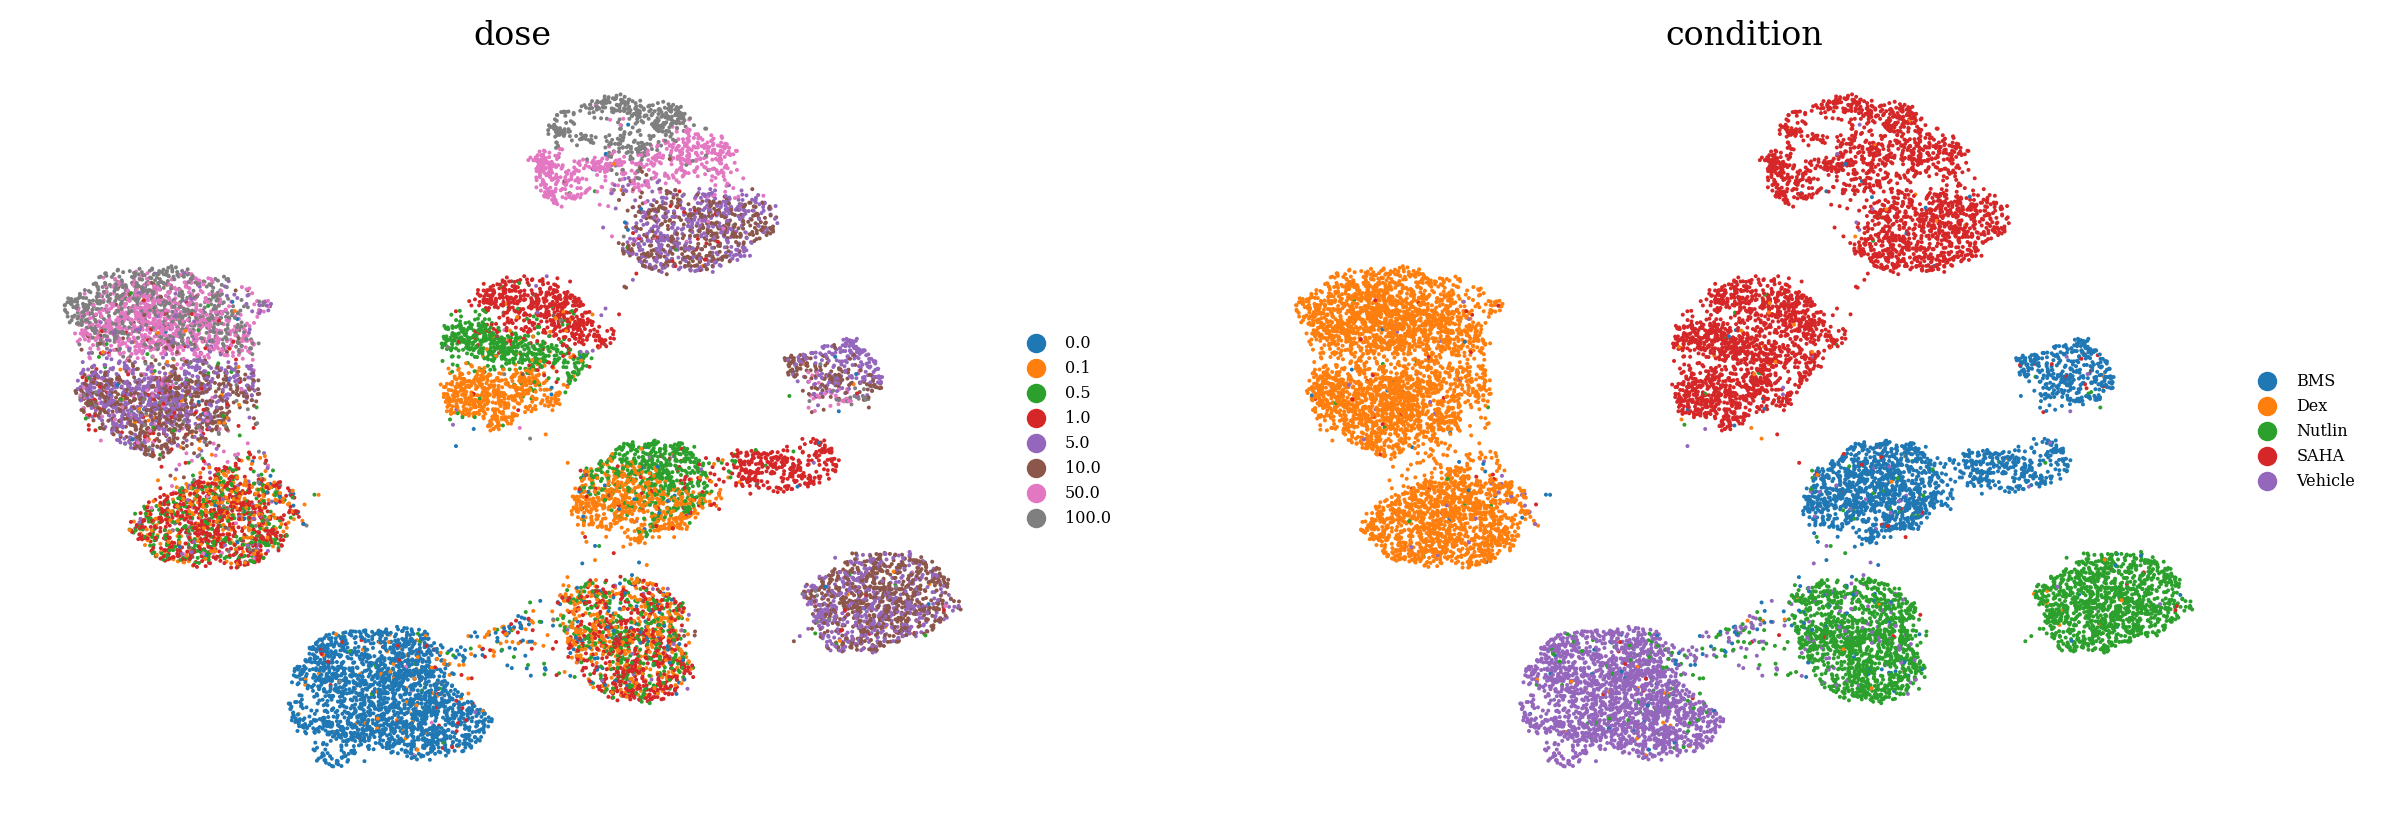

In [24]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition"], 
        ncols=2,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [25]:
from tardis._disentanglementmanager import DisentanglementManager as DM

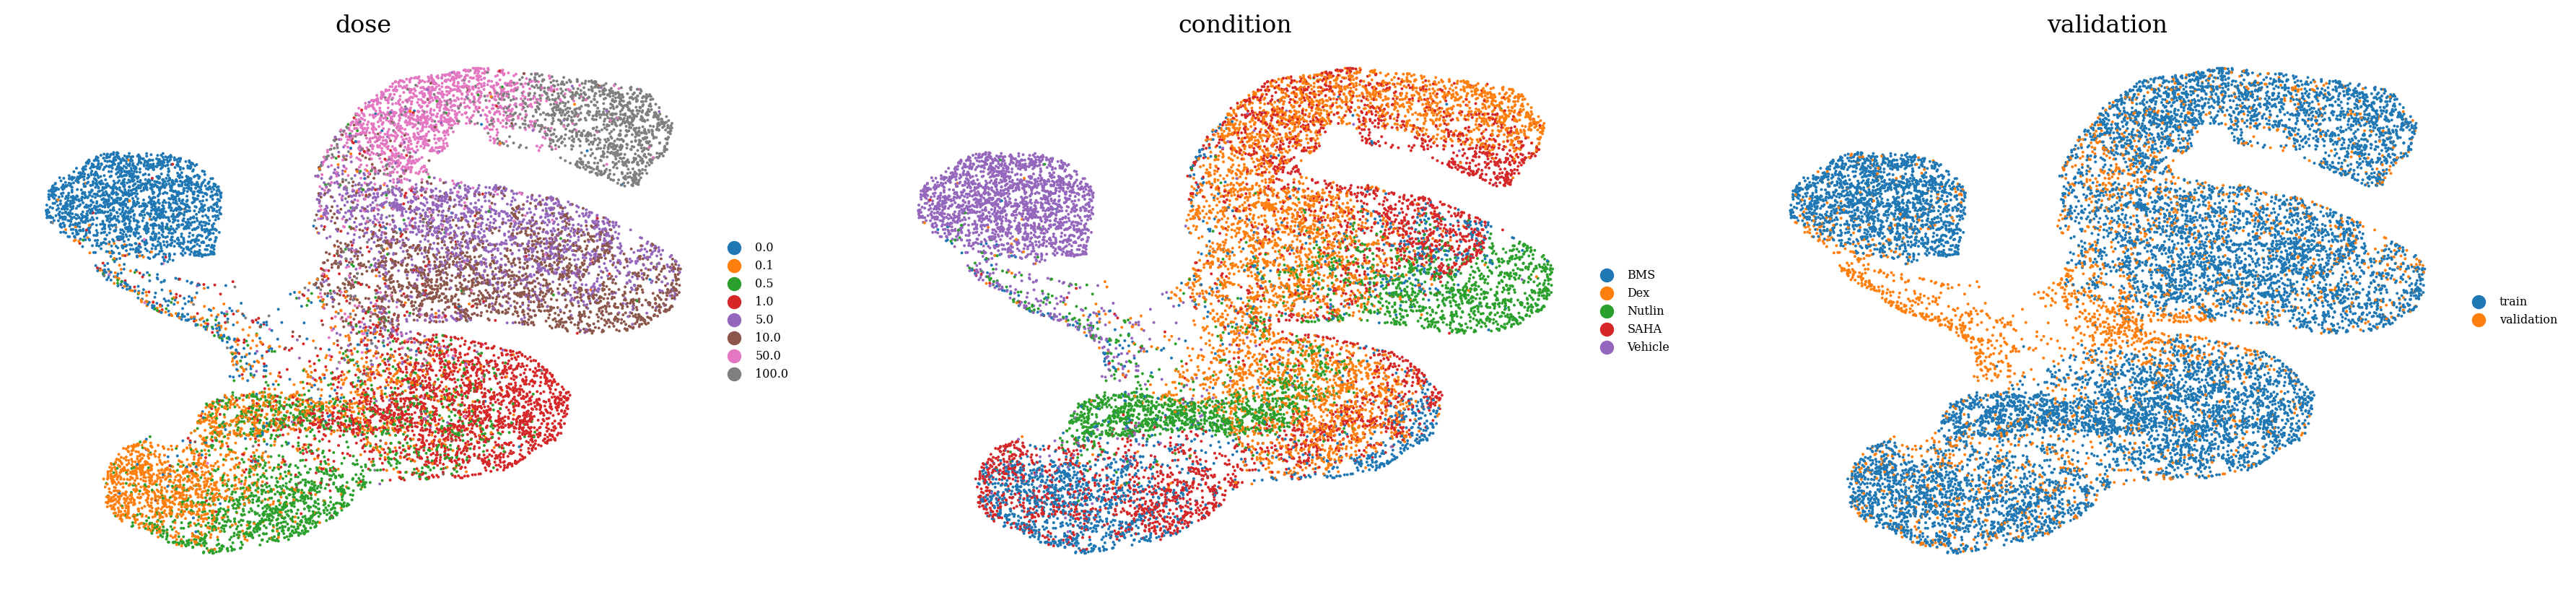

In [26]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key("dose_training").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition", "validation"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

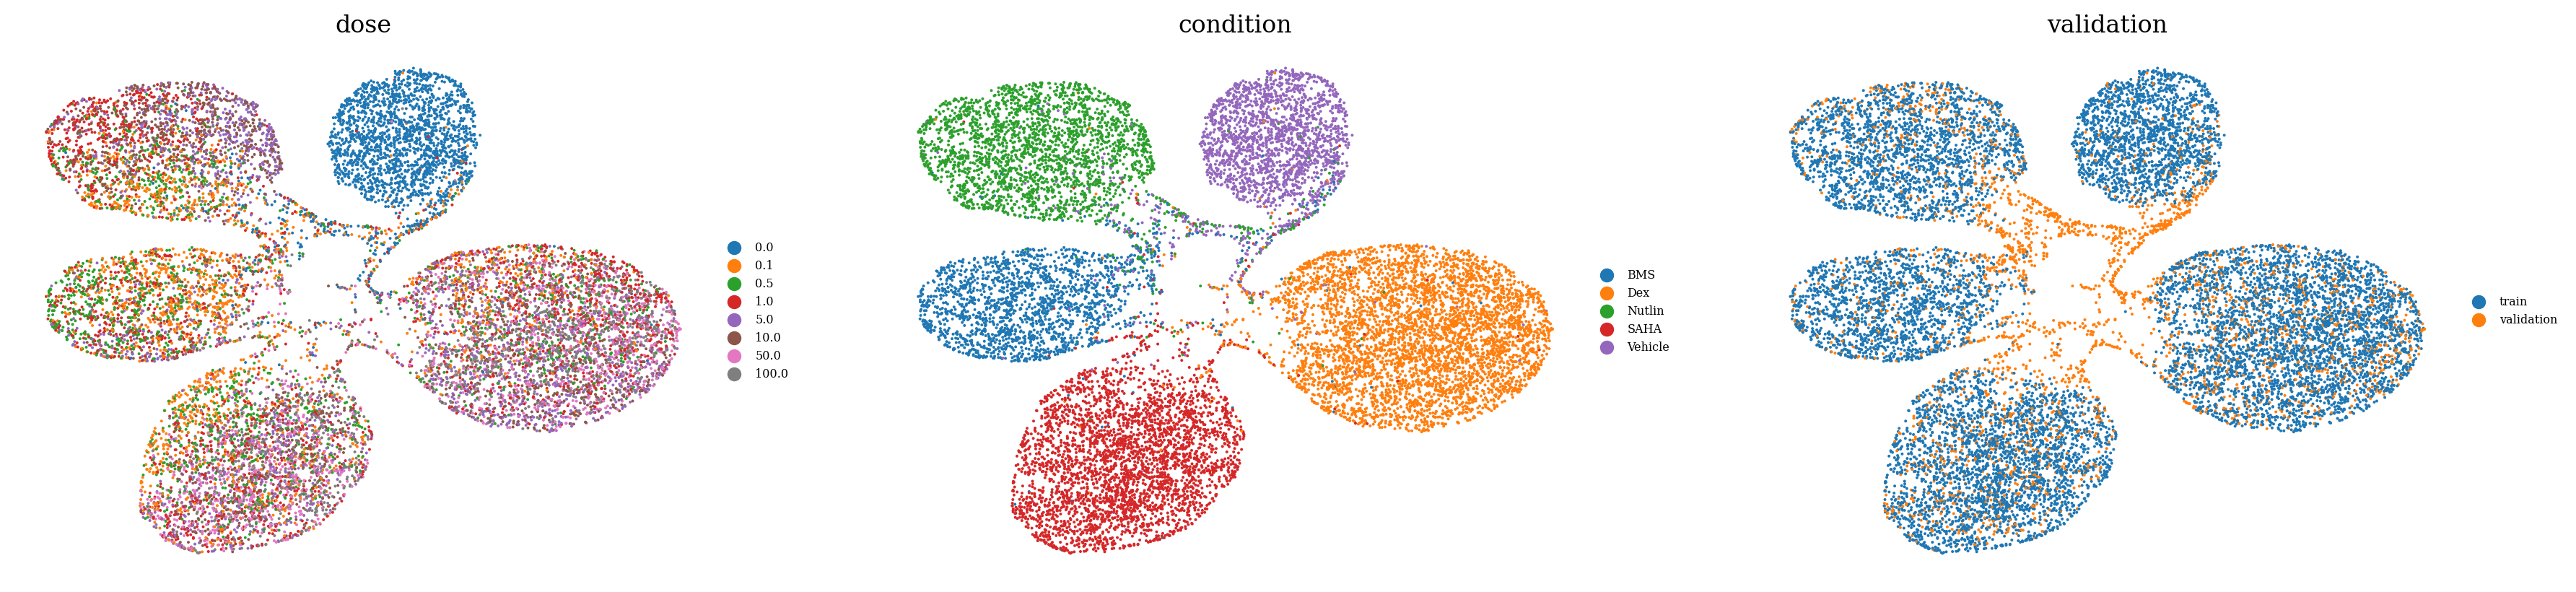

In [27]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key("condition").reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["dose", "condition", "validation"],
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [28]:
adata_main = ad.read_h5ad(adata_file_path)
adata_main.obs.loc[adata_main.obs["dose"] == "0.0", "dose_val"] = 0.0
d = {i: ind for ind, i in enumerate(sorted(adata_main.obs["dose"].astype(float).unique()))}
adata_main.obs["dose_training"] = [d[float(i)] for i in adata_main.obs["dose"]]

adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")

adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()

In [29]:
# latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main)[:, DM.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata_main.obs.copy())
latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main), obs=adata_main.obs.copy())
sc.pp.neighbors(latent_main, n_neighbors = 30)
sc.tl.umap(latent_main)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


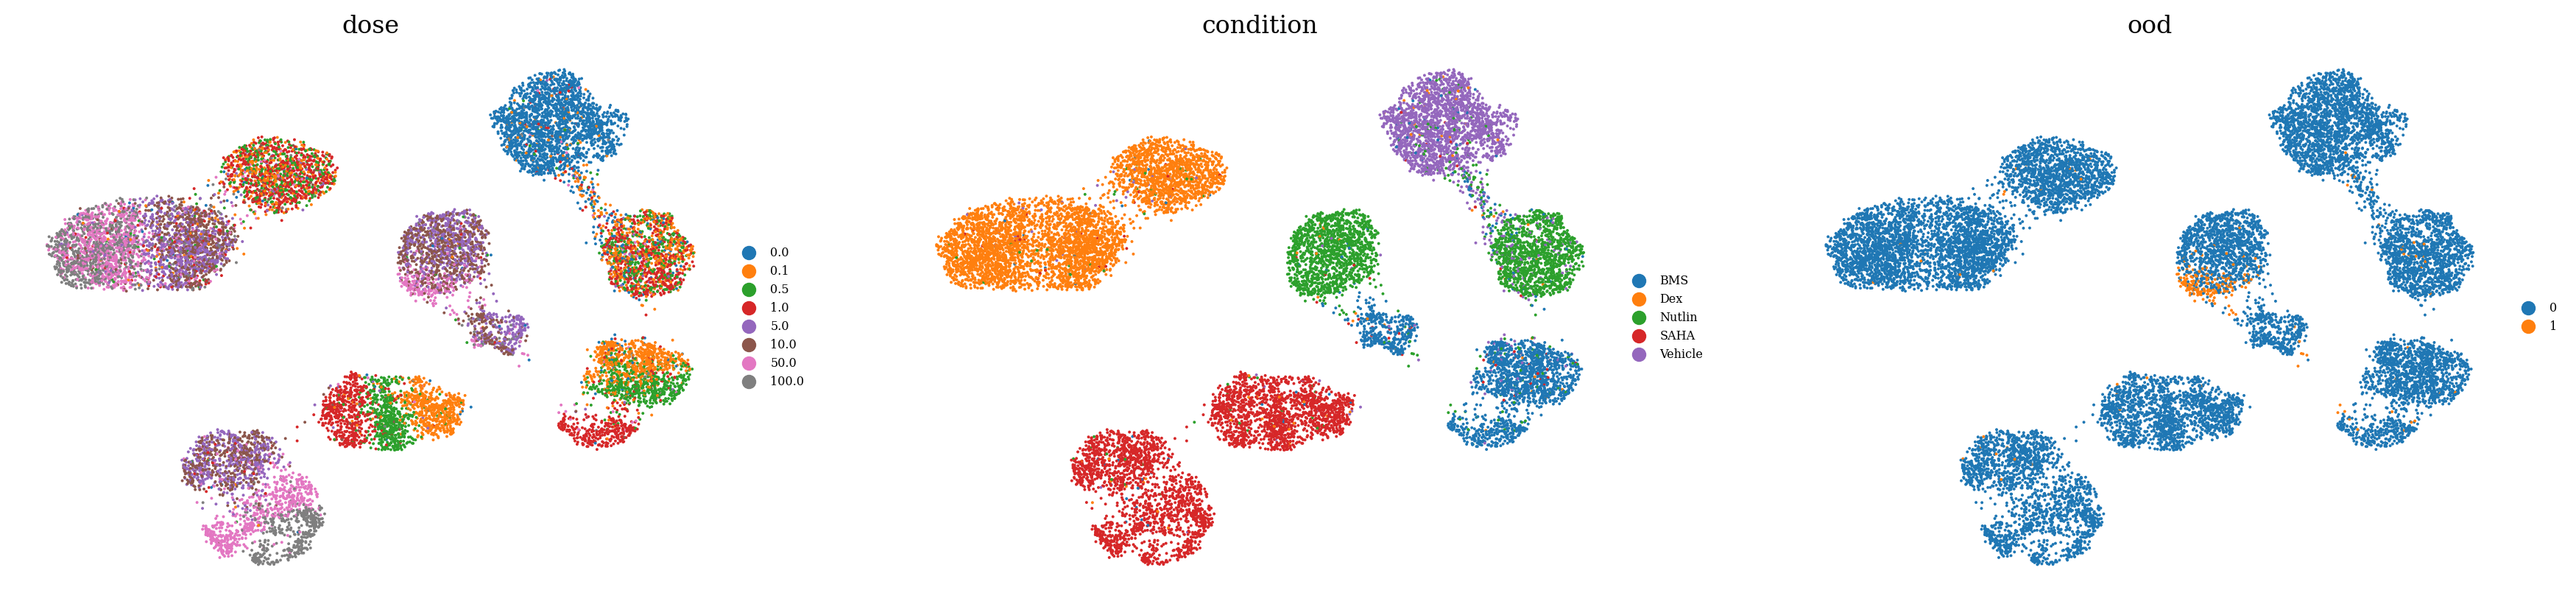

In [30]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_main, 
        color=["dose", "condition", "ood"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [31]:
k = "dose_training"

latent = ad.AnnData(X=vae.get_latent_representation(adata)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata_ood.obs.copy())
sc.pp.neighbors(latent_ood)
sc.tl.umap(latent_ood)
label_transfer(latent, latent_ood, cluster_list=[k], neighbors_count=30)
predicted = latent_ood.obs[f"transf_{k}"].astype(str).values
true = latent_ood.obs[k].astype(str).values

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


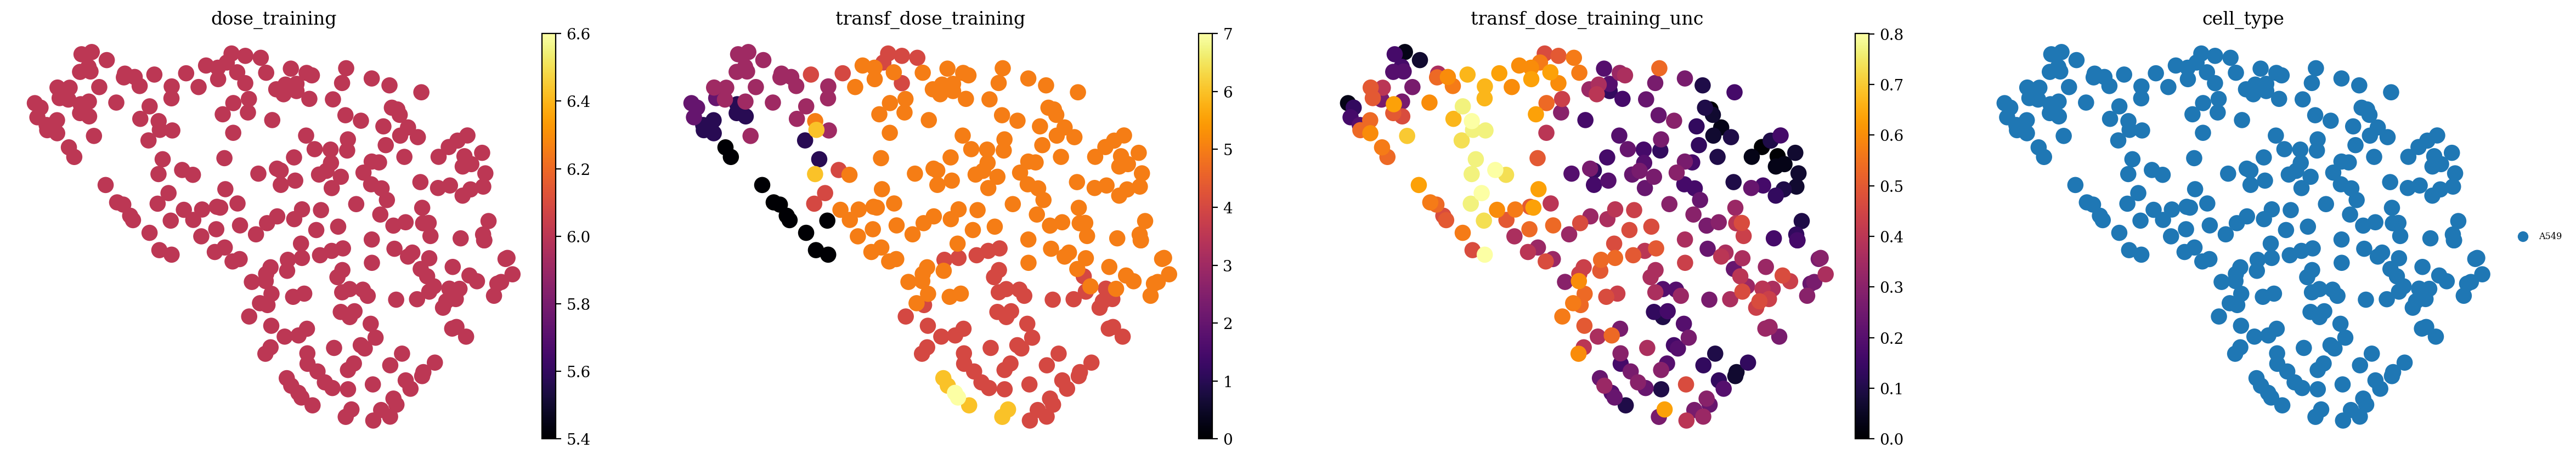

In [32]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_ood, 
        color=[k, f"transf_{k}", f"transf_{k}_unc", "cell_type"], 
        ncols=4,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [33]:
metrics = {}
metrics['accuracy'] = sklearn.metrics.accuracy_score(true, predicted)
metrics['precision_macro'] = sklearn.metrics.precision_score(true, predicted, average='macro', zero_division=0)
metrics['recall_macro'] = sklearn.metrics.recall_score(true, predicted, average='macro', zero_division=0)
metrics['f1_score_macro'] = sklearn.metrics.f1_score(true, predicted, average='macro', zero_division=0)
metrics['precision_micro'] = sklearn.metrics.precision_score(true, predicted, average='micro', zero_division=0)
metrics['recall_micro'] = sklearn.metrics.recall_score(true, predicted, average='micro', zero_division=0)
metrics['f1_score_micro'] = sklearn.metrics.f1_score(true, predicted, average='micro', zero_division=0)
metrics['precision_weighted'] = sklearn.metrics.precision_score(true, predicted, average='weighted', zero_division=0)
metrics['recall_weighted'] = sklearn.metrics.recall_score(true, predicted, average='weighted', zero_division=0)
metrics['f1_score_weighted'] = sklearn.metrics.f1_score(true, predicted, average='weighted', zero_division=0)
metrics['confusion_matrix'] = sklearn.metrics.confusion_matrix(true, predicted)
metrics

{'accuracy': 0.026415094339622643,
 'precision_macro': 0.125,
 'recall_macro': 0.0033018867924528303,
 'f1_score_macro': 0.006433823529411765,
 'precision_micro': 0.026415094339622643,
 'recall_micro': 0.026415094339622643,
 'f1_score_micro': 0.026415094339622643,
 'precision_weighted': 1.0,
 'recall_weighted': 0.026415094339622643,
 'f1_score_weighted': 0.05147058823529412,
 'confusion_matrix': array([[  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [ 11,   9,   4,  22,  69, 141,   7,   2],
        [  0,   0,   0,   0,   0,   0,   0,   0]])}

In [34]:
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))

Baseline Accuracy: 0.14658024441293632


In [35]:
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))

Baseline Accuracy: 0.12551482006616704
